In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from requests import get
import json 
import os 
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

#Plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, IFrame
import seaborn as sns
import plotly.express as px

import folium #  conda install -c conda-forge folium
from folium import plugins
import geopandas as gpd

# Our helpers
from neural import prepare_future, predict_future # Wrapper to use RNNs
from helpfunc import *
from plots import *

# Foor retrieving prices of food
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import picos as pic # Library used to implement the convex optimization problem

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
path_dict = {'food_balance_africa': 'data/raw/FoodBalanceSheets_E_Africa_1.csv',
                'geoworld_json': 'data/raw/world-countries.json',
                'africa_supply_rnn': 'data/processed/africa_cal.pkl',
                'ages_calories_demand': 'data/raw/calories_demand.xlsx',
                'african_countries_list': "data/raw/african_countries.txt",
                'population_age_male': "data/raw/POPULATION_BY_AGE_MALE.xlsx",
                'population_age_female': "data/raw/POPULATION_BY_AGE_FEMALE.xlsx",
                'food_balance_europe': "data/raw/FoodBalanceSheets_E_Europe_1.csv",
                'europe_supply_rnn': 'data/processed/europe_cal.pkl',
                'european_countries_list': "data/raw/european_countries.txt", 
                'african_supply_map': 'visualization/africa_supply_map',
                'african_demand_anim': 'visualization/african_cal_diff_animation.html',
                'african_estimation_kcal': 'visualization/africa_est_kcal',
                'african_kcal_need': "visualization/african_kcal_need",
                 "european_supply_map":"visualization/european_supply_map",
                 "african_pop_growth":"visualization/african_pop_growth.html", 
                 'european_pop_growth': "visualization/european_pop_growth.html",
                 'european_estimation_kcal': 'visualization/europe_est_kcal',
                 'european_demand_anim': 'visualization/european_cal_diff_animation.html',
                 'european_kcal_surplus': "visualization/european_kcal_surplus",
                 'world_kcal_surplus': "visualization/world/world_kcal_surplus",
            }

In [31]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

# Determination of African countries with food deficit

## 1) How much human food resources are available in African countries?

### 1.1) Preprocessing

To answer this important question, we will need to import data from the **FAO Dataset**. More specifically, we will focus on the section **Food Balance Sheet** with respect to African countries only. 

In [32]:
food_balance_africa = pd.read_csv(path_dict['food_balance_africa'],encoding='latin-1');

Firstly, we will **remove** all the columns with title **"Y----F"** as they contain information about how the data was obtained (Calculated, Regression, Aggregate, FAO Estimation). In this context we will consider that FAO is a *highly renowned Agency* and hence we can assume these values are truthful without loss of generality. Furthermore we thought that it would be very handy to have numbers as columns representing years instead of **"Y----"**. We proceed on removing the letter **Y**. The helper functions `clean_Fs_and_years` does this cleaning on the dataframe.

In [33]:
food_balance_africa = clean_Fs_and_years(food_balance_africa)

Secondly, we replace all the **NAN** values with **0** as Item was not available.

In [34]:
food_balance_africa = food_balance_africa.fillna(0);

The third step to complete **the cleaning** of food_balance_africa consists of adapting names of countries in order to have consistency along our different dataframes. Since some countries changed their name over the years we will rename them. In particular, **Swaziland** to **Eswatini** and **South Africa** to **Southern Africa**. The function `replace_names_of_countries` takes the dataframe and the country names which should be replaced.

In [35]:
food_balance_africa = replace_names_of_countries(food_balance_africa, [('Swaziland', 'Eswatini'), ('South Africa', 'Southern Africa')])

Our Dataframe looks like this:

In [36]:
food_balance_africa.head()

Area Code     Area  Item Code                Item  Element Code  \
0          4  Algeria       2501          Population           511   
1          4  Algeria       2511  Wheat and products          5511   
2          4  Algeria       2511  Wheat and products          5611   
3          4  Algeria       2511  Wheat and products          5072   
4          4  Algeria       2511  Wheat and products          5911   

                         Element          Unit     1961     1962     1963  \
0  Total Population - Both sexes  1000 persons  11561.0  11845.0  12136.0   
1                     Production   1000 tonnes    686.0   1507.0   1590.0   
2                Import Quantity   1000 tonnes    469.0    501.0    374.0   
3                Stock Variation   1000 tonnes    353.0   -409.0   -408.0   
4                Export Quantity   1000 tonnes     46.0     12.0     33.0   

   ...     2004     2005     2006     2007     2008     2009     2010  \
0  ...  33461.0  33961.0  34507.0  35097.0  35725.0  36383.0  37063.0   
1  ...   2731.0   2415.0   2688.0   2319.0   1111.0   2953.0   2605.0   
2  ...   5123.0   5697.0   4987.0   4885.0   6508.0   5757.0   5109.0   
3  ...   -456.0   -606.0   -459.0     -1.0    156.0   -484.0    515.0   
4  ...      7.0     13.0      7.0     14.0     24.0     37.0     39.0   

      2011     2012     2013  
0  37763.0  38482.0  39208.0  
1   2555.0   3432.0   3299.0  
2   7487.0   6385.0   6343.0  
3  -1050.0   -350.0   -180.0  
4      5.0      5.0      2.0  

[5 rows x 60 columns]

Analysing our DataFrame *food_balance_africa* we can see that it's already well structured since it contains many key - value couples such as **Item Code - Item** and **Element Code - Element** . More specifically, we will take advantage of this structure to filter out only rows characterized by **Grand total** as an **Item** and **Food supply (kcal/capita/day)** as an **Element**. The corresponding key-values are **(Item Code, 2901) and (Element Code, 664)**.
A reference to the documentation in the [FAO Website](http://www.fao.org/faostat/en/#data/FBS) explains the legend for Element Code and Element Item extensively. 

In order to keep our original Dataframe *food_balance_africa* as a reference we create a new Dataframe *food_supply_africa* in which we just keep **countries** and **food supplies** for every **year**.

In [37]:
food_supply_africa = obtain_supply(food_balance_africa)

We can now group group by **Area** and see the supplies derived from each item available in countries for that particular year.

In [38]:
food_supply_africa = food_supply_africa.set_index("Area")
food_supply_africa.head()

1961    1962    1963    1964    1965    1966    1967    1968  \
Area                                                                           
Algeria       1619.0  1569.0  1528.0  1540.0  1591.0  1571.0  1647.0  1706.0   
Angola        1798.0  1819.0  1853.0  1862.0  1877.0  1890.0  1921.0  1856.0   
Benin         1736.0  1758.0  1703.0  1669.0  1812.0  1804.0  1833.0  1935.0   
Botswana      1976.0  1909.0  1972.0  2001.0  2005.0  1947.0  2010.0  2052.0   
Burkina Faso  1326.0  1308.0  1452.0  1555.0  1571.0  1560.0  1587.0  1602.0   

                1969    1970  ...    2004    2005    2006    2007    2008  \
Area                          ...                                           
Algeria       1705.0  1675.0  ...  2987.0  2958.0  3047.0  3041.0  3048.0   
Angola        1946.0  1965.0  ...  2030.0  2077.0  2119.0  2173.0  2245.0   
Benin         1871.0  1812.0  ...  2461.0  2435.0  2450.0  2564.0  2521.0   
Botswana      2013.0  2035.0  ...  2191.0  2198.0  2150.0  2166.0  2184.0   
Burkina Faso  1604.0  1546.0  ...  2505.0  2463.0  2559.0  2546.0  2588.0   

                2009    2010    2011    2012    2013  
Area                                                  
Algeria       3110.0  3142.0  3217.0  3272.0  3296.0  
Angola        2303.0  2345.0  2407.0  2384.0  2473.0  
Benin         2565.0  2555.0  2598.0  2610.0  2619.0  
Botswana      2199.0  2234.0  2273.0  2342.0  2326.0  
Burkina Faso  2639.0  2681.0  2664.0  2707.0  2720.0  

[5 rows x 53 columns]

In order to check for anomalies in our data, we would like to analyze the **timeline**. We therefore transpose the dataframe and plot the timeline of how food supply in different countries evolved. Legend was suppressed as it is too large.

In [39]:
food_supply_africa = food_supply_africa.transpose();

In [40]:
#converting the year from string to int
food_supply_africa.index = food_supply_africa.index.astype(int)

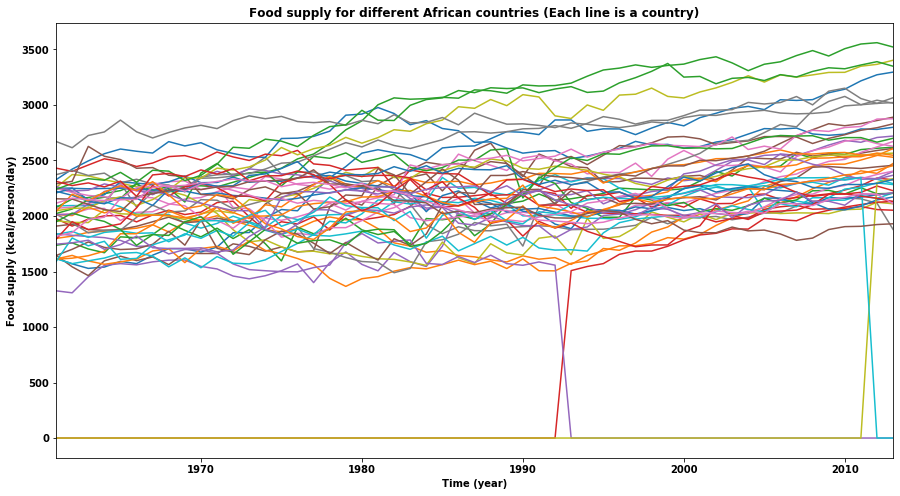

In [41]:
timeline_supply(food_supply_africa, "African")

This analysis shows that there are two inconsistencies. We therefore check for countries containing values equal to zero.

In [42]:
food_supply_africa.columns.values[(food_supply_africa == 0).any()]

array(['Ethiopia', 'Ethiopia PDR', 'Sudan', 'Sudan (former)'],
      dtype=object)

We notice that **Sudan** and **Ethiopia** appear twice as "Sudan" and "Sudan (former)" and "Ethiopia" and "Ethiopia PDR" respectively. This is due to the fact that South Sudan gained independence in 2011 (reference to https://en.wikipedia.org/wiki/South_Sudan), and the foundation of the Federal Democratic Republic of Ethiopia (reference to https://en.wikipedia.org/wiki/Ethiopia) in 1991. From then on, Ethiopia PDR was listed as Ethiopia. With food supply being consistently constant even after division, the newly introduced country "Sudan" is assumed to further on have accounted for both countries. For this reason, we will consider them to be one single country. 
Consequently, the two countries' data is merged into one continuous set each. The function `merge_countries` takes care of this, by substituting each key in dictionary (the second argument) with its value(s).

In [43]:
food_supply_africa = merge_countries(food_supply_africa, {'Sudan (former)': ['Sudan'], 'Ethiopia PDR': ['Ethiopia']})

Let's plot the newly generated data:

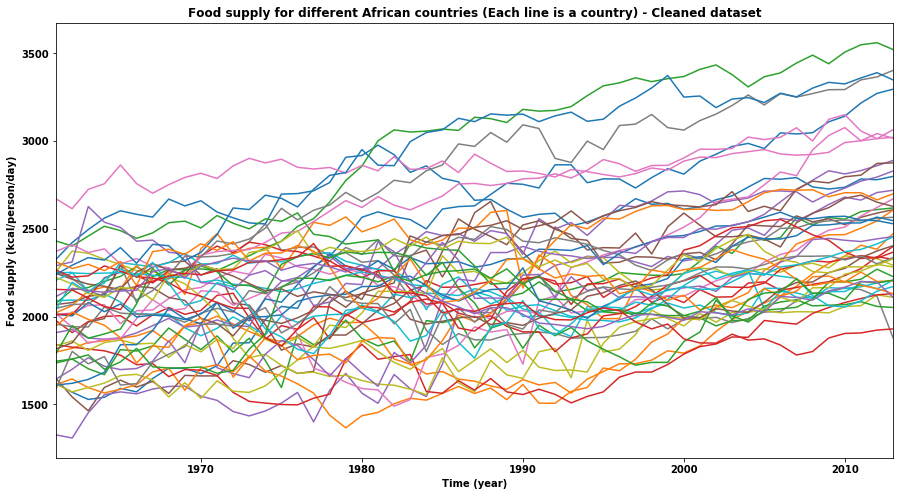

In [44]:
timeline_supply(food_supply_africa, "African", " - Cleaned dataset")

Next, we want to add more columns representing future years until 2020 to prepare cells for extrapolation to make predictions about possible scenarios. `prepare_future` is used for this.

In [45]:
# Adding columns for the new years
food_supply_africa = prepare_future(food_supply_africa, 2014, 2020)

### 1.2) Extrapolation
First of all, we want to simulate data until 2020 to match the population data. Furthermore, we also want to be able to make predicitions for individual countries to assess if they might run into food shortages in the near future.  
The prediction for the new years are done by using a "*Recurrent Neural Network (RNN)*" and a window of size 10. Basically what we will do here is using all the past history of each country (windowed in block of 10 years each) to run a neural network and try to predict the future behaviour (up to 2020). During our test we found that the neural networks are able to predict good estimations.  
As we don't want precise data, the **_estimations_** achieved by using ML are in this case more than acceptable for our purpose.  
*Credits*: We don't know much about RNN, so the network used here is adapted from the *Time series forecasting tutorial* on **Tensorflow**, available [here](https://www.tensorflow.org/tutorials/structured_data/time_series)  
*Note*: we already ran the networks and saved the results on Colab, running them each time requires more than an hour on Colab. For this reason, we just use the pickle here instead of running the network. This is achieved by the function `predict_future`.

In [46]:
food_supply_africa = predict_future(food_supply_africa, path_dict['africa_supply_rnn'])

Plotting the results:

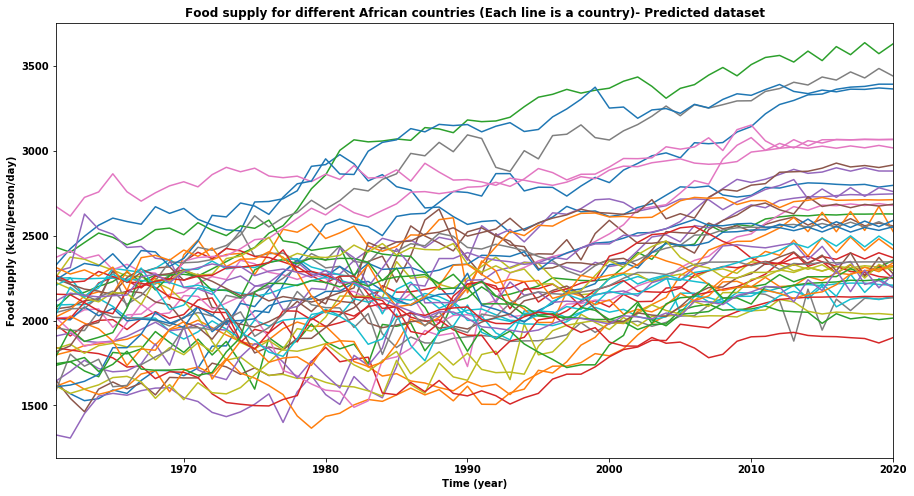

In [47]:
timeline_supply(food_supply_africa, "African", "- Predicted dataset")

When looking at the predicted period (after 2013), a linear approximation can be observed with some countries being forecasted to oscillate. This can be explained by the fact that the neural network method recognised a recurring pattern in the data and extrapolates this behaviour. Among all the tested methods, this one is expected to reproduce the most realistic data, as no odd developments can be observed.

### 1.3) Visualizing the data interactively

In [48]:
#Geographic coordinates for visualizing 
geojson_world = gpd.read_file(path_dict['geoworld_json'])
type(geojson_world)

geopandas.geodataframe.GeoDataFrame

We observe `geojson_world` is a **GeoDataFrame**. Let's see how the data are sorted:

In [49]:
geojson_world.head()

id                  name  \
0  AFG           Afghanistan   
1  AGO                Angola   
2  ALB               Albania   
3  ARE  United Arab Emirates   
4  ARG             Argentina   

                                            geometry  
0  POLYGON ((61.21082 35.65007, 62.23065 35.27066...  
1  MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...  
2  POLYGON ((20.59025 41.85540, 20.46317 41.51509...  
3  POLYGON ((51.57952 24.24550, 51.75744 24.29407...  
4  MULTIPOLYGON (((-65.50000 -55.20000, -66.45000...

We have to make sure that `geojson_world` has data for every country under our analysis. In this case, we need to check for every country in Africa and more specifically every country taken into account in `food_supply_africa`. Since the **name** in `geojson_world` is not a good index to match and we don't have any comparable **id** in `food_supply_africa` we have to do this job by hand, which is feasible since the size is small enough. As a result, we filter `geojson_world` to `geojson_africa`. Let's display this new GeoDataFrame.

In [50]:
african_country_codes = ["DZA","AGO","BEN","BWA","BFA","CMR","CAF","TCD","COD","CIV",
                         "DJI","EGY","SWZ","ETH","GAB","GMB","GHA","GNQ","GNB","KEN","LSO","LBR",
                         "MDG","MWI","MLI","MRT","MAR","MOZ","NAM","NER","NGA","RWA"
                         ,"SEN","SLE","ZAF","SDN","TGO","TUN","UGA","TZA","ZMB","ZWE"]

african_country_names = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
                         'Cameroon', 'Central African Republic', 'Chad', 'Congo',
                         "Côte d'Ivoire", 'Djibouti', 'Egypt', 'Eswatini','Ethiopia', 'Gabon',
                         'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho',
                         'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
                         'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Senegal',
                         'Sierra Leone', 'Southern Africa', 'Sudan', 'Togo',
                         'Tunisia', 'Uganda', 'United Republic of Tanzania', 'Zambia',
                         'Zimbabwe']

african_country_kv = pd.DataFrame({'codes': african_country_codes,
                                    'names': african_country_names
                                    })

geojson_africa = geojson_world[geojson_world.id.isin(african_country_codes)]
geojson_africa.head()

id                      name  \
1   AGO                    Angola   
13  BEN                     Benin   
14  BFA              Burkina Faso   
25  BWA                  Botswana   
26  CAF  Central African Republic   

                                             geometry  
1   MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...  
13  POLYGON ((2.69170 6.25882, 1.86524 6.14216, 1....  
14  POLYGON ((-2.82750 9.64246, -3.51190 9.90033, ...  
25  POLYGON ((25.64916 -18.53603, 25.85039 -18.714...  
26  POLYGON ((15.27946 7.42192, 16.10623 7.49709, ...

The ordered list **african_country_codes** contains all the countries available to be plotted as geometry is available. We found out manually that **Cabo Verde, Sao Tome and Principe and Mauritius** are not in this list. For the sake of simplicity, we will remove these three countries as they don't affect our analysis. 

In [51]:
food_supply_africa = food_supply_africa.drop(columns=["Cabo Verde","Mauritius","Sao Tome and Principe"])

Now we can move to plot the Food supply for each country. All of this is done in the `plot_map` function. This function plots a world map centered in the zone of interest with interactive values while scrolling over the individual.  
As we are particularly interested in the situation in *2020*, we'll plot our prediction of supply for this year in the notebook map. Could be interesting also to look at the evolving of the situation over the last 50 years, so we plot a map for each decade from 1970 to 2020.  
**_Note_: the map visualized here is just for 2020, if maybe will not load. If this happens, [click here](https://manuleo.github.io/mADAm_files/africa_supply_map2020.html)**  

The maps for the previous decade are available here:
- [1970](https://manuleo.github.io/mADAm_files/africa_supply_map1970.html)
- [1980](https://manuleo.github.io/mADAm_files/africa_supply_map1980.html)
- [1990](https://manuleo.github.io/mADAm_files/africa_supply_map1990.html)
- [2000](https://manuleo.github.io/mADAm_files/africa_supply_map2000.html)
- [2010](https://manuleo.github.io/mADAm_files/africa_supply_map2010.html)

In [52]:
# Used to generate, don't run it
legend_name = "Food supply (kcal/person/day)"
for year in range(1970, 2030, 10):
    africa_supply_map = plot_map(food_supply_africa.T, path_dict['geoworld_json'], \
    african_country_kv, year, "Blues", legend_name, legend_name, path_dict['african_supply_map'] + str(year) + ".html")
africa_supply_map

In [53]:
# Printing 2020 map
IFrame(src='https://manuleo.github.io/mADAm_files/africa_supply_map2020.html', width = 800, height=600)

In [54]:
save_map_data(geojson_africa, african_country_kv, food_supply_africa, "docs/json/africa_supply/africa_supply_{}.geojson", "docs/json/africa_supply/africa_supply_ticks.json")

By analyzing the trend over the decades, we discover that the situation in the African region **partially improved** over the years, especially if we compare the 2020 with the 1970.  
There are some countries, especially in North Africa, that improved their supplies by 1000 kcal. In contrast, the situation in the central-southern region is almost the same as 50 years ago. Another important point to see is that there is a bit of fluctuation of the values.

## 2) What is the ideal amount of kcal each African country needs?
In this first part, we compute **kcal demand** for males and females for every age group. Secondly, we will conduct an extensive analysis on **African demographics**. Finally, we will be able to combine kcal demand with African population data into a unique dataframe that will be the answer of our inital question: **What is the kcal demand of a regular person in order to be healthy?**

### 2.1) How many kilocalories does a regular person need daily?

First of all, we load the calories demand datasets scraped from the webpage [Calories](https://health.gov/dietaryguidelines/2015/guidelines/appendix-2/). This information will be matched with the population datsets to receive the total caloric demand in each country, each year.

In [55]:
male_calory_demand = pd.read_excel(path_dict['ages_calories_demand'], header = None, sheet_name = 0, names = ['age', 'sedentary', 'moderate', 'active'])

In [56]:
female_calory_demand = pd.read_excel(path_dict['ages_calories_demand'], header = None, sheet_name = 1, names = ['age', 'sedentary', 'moderate', 'active'])

In order to better work with the information we have collected, we will make some simplifications on the data. Mainly, we will:
- take the **active lifestyle** column in the calories demands database. According to the [World Health Organization](https://www.afro.who.int/health-topics/physical-activity), regular physical activity helps to maintain a healthy body and reduces the risk of disease.
- group the ages into ranges that match the ranges provided in the World Population Database

In [57]:
male_calories = male_calory_demand.drop(columns=['sedentary', 'moderate'])
female_calories = female_calory_demand.drop(columns=['sedentary', 'moderate'])
male_calories.rename(columns={'active':'input kcal'}, inplace=True)
female_calories.rename(columns={'active':'input kcal'}, inplace=True)

We have now obtained a caloric demand for simpler calculations in the future and stored in the two previous datasets.  
Now, we need a  way to match the age groups in this dataframe to the ones in the population database we obtained. As such, let's analyse how ages are represented in our caloric demand dataframes.

In [58]:
male_calories['age'].unique()

array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       '19-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50',
       '51-55', '56-60', '61-65', '66-70', '71-75', '76 and up', nan],
      dtype=object)

We can see that there are ranges of ages with different sizes (which makes sense, because different age groups have different caloric needs). The function `explode_age` returns the dataframe with one row per individual age.

We apply the function to our two dataframes:

In [59]:
male_calories = explode_age(male_calories)
female_calories = explode_age(female_calories)

In [60]:
male_calories['age'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101], dtype=int64)

Ages are now unique in each dataframe ( `male_calories` and `female_calories` ) and there's a caloric input value for each of them.

The last step to allow the match with the population database is to build the **same age groups** we have in that set. The `compress_ages` function takes care of the differences between datasets by grouping the **ages** into the same **ranges** as in the population dataset (and calculating the average needs).

We can lastly apply the function to the dataframes:

In [61]:
male_calories = compress_ages(male_calories)
female_calories = compress_ages(female_calories)

We also use the age group as new index and rename the columns:

In [62]:
male_calories.index.name = 'age_group'
male_calories = male_calories.rename(columns={0: 'input kcal'})
female_calories.index.name = 'age_group'
female_calories = female_calories.rename(columns={0: 'input kcal'})

Let's have a look at the result we have achieved and collected in our matchable dataframe `male_calories` and `female_calories`. The unit here is **kcal/person/day**.

In [63]:
male_calories.head()

input kcal
age_group             
0-4        1333.333333
5-9        1840.000000
10-14      2440.000000
15-19      3120.000000
20-24      3000.000000

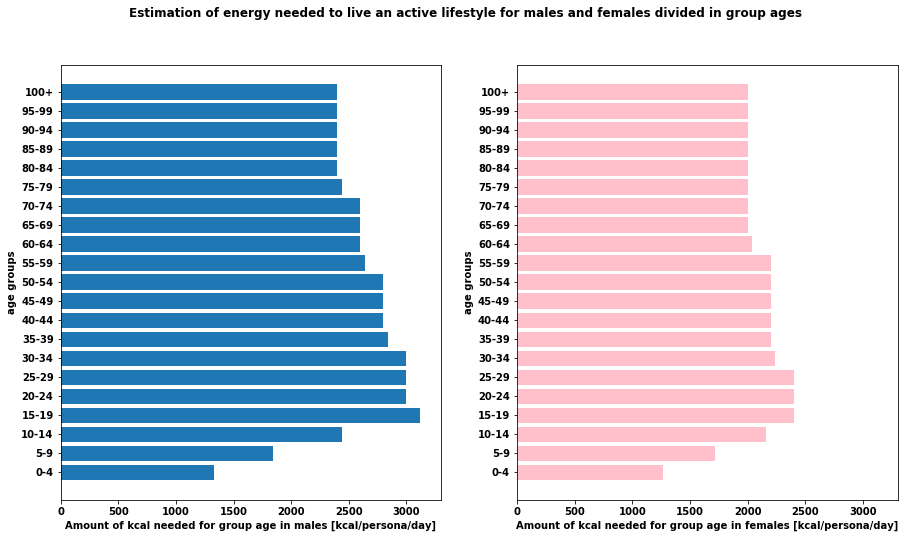

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].barh(male_calories.index, male_calories["input kcal"])
axes[1].barh(female_calories.index, female_calories["input kcal"],color="#ffc0cb")
axes[0].set_xlabel("Amount of kcal needed for group age in males [kcal/persona/day]")
fig.suptitle("Estimation of energy needed to live an active lifestyle for males and females divided in group ages")
axes[1].set_xlabel("Amount of kcal needed for group age in females [kcal/persona/day]")
axes[1].set_xlim(0, 3300)
axes[0].set_xlim(0, 3300)
axes[0].set_ylabel("age groups")
axes[1].set_ylabel("age groups");

As as we can see, in general, males need more calories than females. For both genders, the maximum demand occurs at the age of 15-30.

### 2.2) How many people live in Africa?

#### 2.2.1) Preprocessing

In this second part of our analysis, we load the list of **African countries**. Secondly, we load the **World Population Database** (United Nation) and therefore we obtain two dataframes: one for males and the other one for females.

In [65]:
with open (path_dict['african_countries_list'],'r') as af_c:
    af_countries = [line.rstrip() for line in af_c] #loading list

We need to check if the FAO Database contains data regarding **every country** in Africa. We will check the intersection with the list **af_countries**.

In [66]:
af_to_remove = list(set(af_countries) - set(food_supply_africa.columns.values))
print("List of countries for which no data is available: " + str(af_to_remove))

List of countries for which no data is available: ['Cabo Verde', "CÃ´te d'Ivoire", 'Libya', 'Somalia', 'Democratic Republic of the Congo', 'Mauritius', 'Mayotte', 'Equatorial Guinea', 'Burundi', 'Western Sahara', 'Sao Tome and Principe', 'Seychelles', 'RÃ©union', 'Comoros', 'Eritrea', 'South Sudan']


As expected, many countries were not present in the FAO Database. The countries to remove are the following: **Eritrea, Burundi, Comoros, Democratic Republic of the Congo, Equatorial Guinea, Libya, Seychelles, Western Sahara, South Sudan, and Somalia**. Furthermore, **Mayotte** and **Réunion** are French territory islands so they will be removed as well.

In [67]:
af_countries = [i for i in af_countries if not i in af_to_remove]
af_to_remove = list(set(af_countries)- set(food_supply_africa.columns.values))
print("List of countries for which no data is available: "+ str(af_to_remove))

List of countries for which no data is available: []


Now we can proceed to load the **population data** and clean it

In [68]:
#loading datasets
pop_male = pd.read_excel(path_dict['population_age_male'], sheet_name="ESTIMATES")
pop_female = pd.read_excel(path_dict['population_age_female'], sheet_name="ESTIMATES")

The function `clean_pop_df` takes care of all the required cleaning. What it does is removing all the unnecessary columns and retaining just the rows of the needed countries. Then it multiplies the value by 1000 (Since the population data is per 1000 people, all entries are multiplied by the same factor (1000) to return to the real value).

In [69]:
pop_male_africa = clean_pop_df(pop_male, af_countries)
pop_female_africa = clean_pop_df(pop_female, af_countries)

**World Population Database** (United Nation) is now loaded and cleaned. This preprocessing is necessary in order to sort things out for next more complex steps.  

Let's have a look at the final version of male population data grouped by age:

In [70]:
pop_male_africa.head()

country  year    0-4    5-9 10-14 15-19 20-24 25-29 30-34 35-39  ...  \
420  Djibouti  1950   6128   4593  3828  3247  2727  2266  1873  1538  ...   
421  Djibouti  1955   5556   5527  4487  3773  3168  2639  2186  1800  ...   
422  Djibouti  1960   7201   5360  5668  4640  3867  3218  2672  2203  ...   
423  Djibouti  1965  10888   7814  6324  6545  5316  4389  3642  3006  ...   
424  Djibouti  1970  15553  11828  9094  7514  7519  6072  4994  4120  ...   

    55-59 60-64 65-69 70-74 75-79 80-84 85-89 90-94 95-99 100+  
420   589   422   277   160    74    24     7     0     0    0  
421   696   506   337   198    94    33     7     0     0    0  
422   868   631   428   256   126    46    11     0     0    0  
423  1191   872   591   358   179    71    16     2     0    0  
424  1646  1208   826   503   259   102    24     3     0    0  

[5 rows x 23 columns]

#### 2.2.2) Interpolating the data on African population

In this context, the population dataframe for males **pop_male** and for females **pop_female** contains measurements of population censi, for years from 1950 to 2020 with a frequency of **5 years**. Next, data is interpolated in order to obtain values for intermediate years. 

For our interpolation method to work, we need to know if the population evolution in these intervals of 5 years is linear. In order to do so, we need to visualize the growth of the population for a group of countries (plotting all of them would be confusing). So we select **3 countries** randomly and plot a simple animation of the growth over time.  
*Note*: the code below is used to generate the HTML animation. If it doesn't load **click on [this link](https://manuleo.github.io/mADAm_files/african_pop_growth.html)**

In [71]:
IFrame(src='https://manuleo.github.io/mADAm_files/african_pop_growth.html', width = 1200, height=600)

In [72]:
# # Selecting countries

# countryrand = []
# n_countries = 3
# for i in range(0, n_countries):
#     countryrand.append(random.choice(pop_male_africa.country.drop_duplicates().values))

# fig = plt.figure()
# animator = animation.FuncAnimation(fig, timeline_country_gender, frames=(range(1950, 2025, 5)),\
#                                    fargs = (pop_male_africa, pop_female_africa, "30-34", countryrand), repeat=False)
# #HTML(animator.to_jshtml())

# with open(path_dict['african_pop_growth'], "w") as f:
#     print(animator.to_html5_video(), file=f)

The animation shows an almost linear growth for the 3 countries considered (with their respective scale), so we can continue with the interpolation.

Now we can apply our function `interpolate_years`, a simple linear interpolation, in order to obtain a frequency of **1 year**.

In [73]:
pop_male_africa = interpolate_years(pop_male_africa, 1950, 2020)
pop_female_africa = interpolate_years(pop_female_africa, 1950, 2020)

Let's see how the new dataframes for males and females population look like:

In [74]:
pop_male_africa.head()

country  year     0-4     5-9   10-14   15-19   20-24   25-29   30-34  \
0  Djibouti  1950  6128.0  4593.0  3828.0  3247.0  2727.0  2266.0  1873.0   
1  Djibouti  1951  6013.6  4779.8  3959.8  3352.2  2815.2  2340.6  1935.6   
2  Djibouti  1952  5899.2  4966.6  4091.6  3457.4  2903.4  2415.2  1998.2   
3  Djibouti  1953  5784.8  5153.4  4223.4  3562.6  2991.6  2489.8  2060.8   
4  Djibouti  1954  5670.4  5340.2  4355.2  3667.8  3079.8  2564.4  2123.4   

    35-39  ...  55-59  60-64  65-69  70-74  75-79  80-84  85-89  90-94  95-99  \
0  1538.0  ...  589.0  422.0  277.0  160.0   74.0   24.0    7.0    0.0    0.0   
1  1590.4  ...  610.4  438.8  289.0  167.6   78.0   25.8    7.0    0.0    0.0   
2  1642.8  ...  631.8  455.6  301.0  175.2   82.0   27.6    7.0    0.0    0.0   
3  1695.2  ...  653.2  472.4  313.0  182.8   86.0   29.4    7.0    0.0    0.0   
4  1747.6  ...  674.6  489.2  325.0  190.4   90.0   31.2    7.0    0.0    0.0   

   100+  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  

[5 rows x 23 columns]

In [75]:
pop_female_africa.head()

country  year     0-4     5-9   10-14   15-19   20-24   25-29   30-34  \
0  Djibouti  1950  6065.0  4583.0  3819.0  3238.0  2736.0  2295.0  1911.0   
1  Djibouti  1951  5948.6  4764.2  3949.6  3342.8  2824.4  2369.8  1973.8   
2  Djibouti  1952  5832.2  4945.4  4080.2  3447.6  2912.8  2444.6  2036.6   
3  Djibouti  1953  5715.8  5126.6  4210.8  3552.4  3001.2  2519.4  2099.4   
4  Djibouti  1954  5599.4  5307.8  4341.4  3657.2  3089.6  2594.2  2162.2   

    35-39  ...  55-59  60-64  65-69  70-74  75-79  80-84  85-89  90-94  95-99  \
0  1574.0  ...  655.0  487.0  334.0  202.0  100.0   34.0   11.0    2.0    0.0   
1  1627.2  ...  679.0  505.8  347.6  211.2  105.4   37.0   11.0    2.0    0.0   
2  1680.4  ...  703.0  524.6  361.2  220.4  110.8   40.0   11.0    2.0    0.0   
3  1733.6  ...  727.0  543.4  374.8  229.6  116.2   43.0   11.0    2.0    0.0   
4  1786.8  ...  751.0  562.2  388.4  238.8  121.6   46.0   11.0    2.0    0.0   

   100+  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  

[5 rows x 23 columns]

#### 2.2.3) Computing the total African population

Lastly, we will compute the total population per year. This new dataframe **pop_tot** will be useful for the next section of our analysis. `obtain_total_pop` does just this, combining the population in *pop_male_africa* and *pop_female_africa*.

In [76]:
pop_tot_africa = obtain_total_pop(pop_male_africa, pop_female_africa)

For the next analysis we will need to match this data with the `food_balance_africa`. We proceed to give to our population data the same shape as the other datasets by using the function `reshape_pop_dataframe`. 

In [77]:
pop_tot_africa = reshape_pop_dataframe(pop_tot_africa)

In [78]:
pop_tot_africa.head()

1950       1951       1952       1953       1954  \
Country                                                               
Algeria       8872250.0  9052656.0  9233062.0  9413468.0  9593874.0   
Angola        4548021.0  4647067.0  4746113.0  4845159.0  4944205.0   
Benin         2255222.0  2264896.0  2274570.0  2284244.0  2293918.0   
Botswana       412541.0   422703.4   432865.8   443028.2   453190.6   
Burkina Faso  4284455.0  4330995.0  4377535.0  4424075.0  4470615.0   

                   1955        1956        1957        1958        1959  ...  \
Country                                                                  ...   
Algeria       9774280.0  10030996.8  10287713.6  10544430.4  10801147.2  ...   
Angola        5043251.0   5125588.4   5207925.8   5290263.2   5372600.6  ...   
Benin         2303592.0   2329197.0   2354802.0   2380407.0   2406012.0  ...   
Botswana       463353.0    471229.0    479105.0    486981.0    494857.0  ...   
Burkina Faso  4517155.0   4579581.8   4642008.6   4704435.4   4766862.2  ...   

                    2011        2012        2013        2014        2015  \
Country                                                                    
Algeria       36727564.8  37477678.6  38227792.4  38977906.2  39728020.0   
Angola        24261873.6  25167500.2  26073126.8  26978753.4  27884380.0   
Benin          9474595.6   9749937.2  10025278.8  10300620.4  10575962.0   
Botswana       2013828.0   2040550.0   2067272.0   2093994.0   2120716.0   
Burkina Faso  16106292.0  16607373.0  17108454.0  17609535.0  18110616.0   

                    2016        2017        2018        2019        2020  
Country                                                                   
Algeria       40552624.6  41377229.2  42201833.8  43026438.4  43851043.0  
Angola        28880757.6  29877135.2  30873512.8  31869890.4  32866268.0  
Benin         10885409.2  11194856.4  11504303.6  11813750.8  12123198.0  
Botswana       2166897.8   2213079.6   2259261.4   2305443.2   2351625.0  
Burkina Faso  18669148.4  19227680.8  19786213.2  20344745.6  20903278.0  

[5 rows x 71 columns]

### 2.3) Estimantion of ideal human food demand in Africa 

Now we multiply each column of the population data for each matching `age_group` in the calories table (which is squeezed to enable multiplication, similar to transposing rows/columns of the dataset).  All of this is done in `get_calories_need`  
We obtain two datasets: `male_cal_need_africa` and `female_cal_need_africa` reporting total calories needed for **each country in each year per age group per gender**. 
The unit here is **kcal/day**.

In [79]:
male_cal_need_africa = get_calories_need(pop_male_africa, male_calories)
male_cal_need_africa.head()

country  year           0-4        5-9       10-14       15-19      20-24  \
0  Djibouti  1950  8.170667e+06  8451120.0   9340320.0  10130640.0  8181000.0   
1  Djibouti  1951  8.018133e+06  8794832.0   9661912.0  10458864.0  8445600.0   
2  Djibouti  1952  7.865600e+06  9138544.0   9983504.0  10787088.0  8710200.0   
3  Djibouti  1953  7.713067e+06  9482256.0  10305096.0  11115312.0  8974800.0   
4  Djibouti  1954  7.560533e+06  9825968.0  10626688.0  11443536.0  9239400.0   

       25-29      30-34      35-39  ...      55-59      60-64     65-69  \
0  6798000.0  5619000.0  4367920.0  ...  1554960.0  1097200.0  720200.0   
1  7021800.0  5806800.0  4516736.0  ...  1611456.0  1140880.0  751400.0   
2  7245600.0  5994600.0  4665552.0  ...  1667952.0  1184560.0  782600.0   
3  7469400.0  6182400.0  4814368.0  ...  1724448.0  1228240.0  813800.0   
4  7693200.0  6370200.0  4963184.0  ...  1780944.0  1271920.0  845000.0   

      70-74     75-79    80-84    85-89  90-94  95-99  100+  
0  416000.0  180560.0  57600.0  16800.0    0.0    0.0   0.0  
1  435760.0  190320.0  61920.0  16800.0    0.0    0.0   0.0  
2  455520.0  200080.0  66240.0  16800.0    0.0    0.0   0.0  
3  475280.0  209840.0  70560.0  16800.0    0.0    0.0   0.0  
4  495040.0  219600.0  74880.0  16800.0    0.0    0.0   0.0  

[5 rows x 23 columns]

In [80]:
#total calories female
female_cal_need_africa = get_calories_need(pop_female_africa, female_calories)
female_cal_need_africa.head()

country  year           0-4        5-9      10-14      15-19      20-24  \
0  Djibouti  1950  7.682333e+06  7882760.0  8249040.0  7771200.0  6566400.0   
1  Djibouti  1951  7.534893e+06  8194424.0  8531136.0  8022720.0  6778560.0   
2  Djibouti  1952  7.387453e+06  8506088.0  8813232.0  8274240.0  6990720.0   
3  Djibouti  1953  7.240013e+06  8817752.0  9095328.0  8525760.0  7202880.0   
4  Djibouti  1954  7.092573e+06  9129416.0  9377424.0  8777280.0  7415040.0   

       25-29      30-34      35-39  ...      55-59      60-64     65-69  \
0  5508000.0  4280640.0  3462800.0  ...  1441000.0   993480.0  668000.0   
1  5687520.0  4421312.0  3579840.0  ...  1493800.0  1031832.0  695200.0   
2  5867040.0  4561984.0  3696880.0  ...  1546600.0  1070184.0  722400.0   
3  6046560.0  4702656.0  3813920.0  ...  1599400.0  1108536.0  749600.0   
4  6226080.0  4843328.0  3930960.0  ...  1652200.0  1146888.0  776800.0   

      70-74     75-79    80-84    85-89   90-94  95-99  100+  
0  404000.0  200000.0  68000.0  22000.0  4000.0    0.0   0.0  
1  422400.0  210800.0  74000.0  22000.0  4000.0    0.0   0.0  
2  440800.0  221600.0  80000.0  22000.0  4000.0    0.0   0.0  
3  459200.0  232400.0  86000.0  22000.0  4000.0    0.0   0.0  
4  477600.0  243200.0  92000.0  22000.0  4000.0    0.0   0.0  

[5 rows x 23 columns]

Once we have the calories needed for both genders, we can aggregate the total caloric need of african countries into `total_cal_need_africa`. The function `obtain_total_cal_need` does just this, returning a dataframe with the calories needed for all the population of a country in a year, in the unit **kcal/year**.

In [81]:
total_cal_need_africa = obtain_total_cal_need(male_cal_need_africa, female_cal_need_africa)

Let's take a look at the total calories dataframe **total_cal**:

In [82]:
total_cal_need_africa.sort_values(by="Calories", ascending=False).head()

country  year      Calories
2342  Nigeria  2020  1.679755e+14
2341  Nigeria  2019  1.637743e+14
2340  Nigeria  2018  1.595730e+14
2339  Nigeria  2017  1.553718e+14
2338  Nigeria  2016  1.511706e+14

For the sake of consistency, we will now reshape our dataframe `total_cal` into a new one `total_cal_final` according to the same schema seen for `food_supply_africa`.

In [83]:
total_cal_need_africa = reshape_calories_df(total_cal_need_africa)

Drawing a sample of the final shaped dataframe total calories `total_cal_need_africa`:

In [84]:
total_cal_need_africa.head()

1950          1951          1952          1953  \
Country                                                                
Algeria       7.290425e+12  7.412354e+12  7.534284e+12  7.656213e+12   
Angola        3.721975e+12  3.797306e+12  3.872637e+12  3.947968e+12   
Benin         1.851458e+12  1.858390e+12  1.865323e+12  1.872255e+12   
Botswana      3.377080e+11  3.450761e+11  3.524442e+11  3.598122e+11   
Burkina Faso  3.538834e+12  3.574675e+12  3.610516e+12  3.646357e+12   

                      1954          1955          1956          1957  \
Country                                                                
Algeria       7.778143e+12  7.900072e+12  8.092341e+12  8.284610e+12   
Angola        4.023299e+12  4.098630e+12  4.159526e+12  4.220422e+12   
Benin         1.879187e+12  1.886119e+12  1.905149e+12  1.924180e+12   
Botswana      3.671803e+11  3.745484e+11  3.799093e+11  3.852703e+11   
Burkina Faso  3.682198e+12  3.718039e+12  3.765608e+12  3.813178e+12   

                      1958          1959  ...          2011          2012  \
Country                                   ...                               
Algeria       8.476879e+12  8.669149e+12  ...  3.150748e+13  3.205546e+13   
Angola        4.281318e+12  4.342214e+12  ...  1.941009e+13  2.013902e+13   
Benin         1.943210e+12  1.962241e+12  ...  7.691320e+12  7.921509e+12   
Botswana      3.906313e+11  3.959923e+11  ...  1.688976e+12  1.709664e+12   
Burkina Faso  3.860748e+12  3.908317e+12  ...  1.296491e+13  1.338135e+13   

                      2013          2014          2015          2016  \
Country                                                                
Algeria       3.260345e+13  3.315144e+13  3.369942e+13  3.433776e+13   
Angola        2.086796e+13  2.159689e+13  2.232582e+13  2.315305e+13   
Benin         8.151697e+12  8.381886e+12  8.612074e+12  8.874543e+12   
Botswana      1.730351e+12  1.751039e+12  1.771726e+12  1.812568e+12   
Burkina Faso  1.379779e+13  1.421422e+13  1.463066e+13  1.510462e+13   

                      2017          2018          2019          2020  
Country                                                               
Algeria       3.497610e+13  3.561444e+13  3.625278e+13  3.689112e+13  
Angola        2.398027e+13  2.480750e+13  2.563473e+13  2.646195e+13  
Benin         9.137011e+12  9.399479e+12  9.661947e+12  9.924415e+12  
Botswana      1.853409e+12  1.894250e+12  1.935091e+12  1.975932e+12  
Burkina Faso  1.557857e+13  1.605253e+13  1.652648e+13  1.700044e+13  

[5 rows x 71 columns]

Let's go on with a interactive visualization of the data in order to understand the trend over countries. The following map is based on data for **2020**.  
However, it's important also to understand what are the possible changing over time, so we plot the same map over the range from 1970 to 2020 (step of 10 years).  
**If the maps for 2020 doesn't show click [here](https://manuleo.github.io/mADAm_files/africa_est_kcal2020.html)**  
Link to the other maps:
- [1970](https://manuleo.github.io/mADAm_files/africa_est_kcal1970.html)
- [1980](https://manuleo.github.io/mADAm_files/africa_est_kcal1980.html)
- [1990](https://manuleo.github.io/mADAm_files/africa_est_kcal1990.html)
- [2000](https://manuleo.github.io/mADAm_files/africa_est_kcal2000.html)
- [2010](https://manuleo.github.io/mADAm_files/africa_est_kcal2010.html)

In [85]:
# Code used just for generating the map
for year in range(1970,2030,10):
    legend_name = "Estimation of kcal/year [10^11 kcal/year]"
    africa_kcal_est_map = plot_map(total_cal_need_africa.divide(10**11), path_dict['geoworld_json'], \
    african_country_kv, year, "Greens", legend_name, legend_name, path_dict['african_estimation_kcal'] + str(year) + ".html")
africa_kcal_est_map

In [86]:
IFrame(src='https://manuleo.github.io/mADAm_files/africa_est_kcal2020.html', width = 800, height=600)

In [87]:
save_map_data(geojson_africa, african_country_kv, total_cal_need_africa.divide(10**11).T, "docs/json/africa_need/africa_need_{}.geojson", "docs/json/africa_need/africa_need_ticks.json")

By looking at the **scale change** over the years, it's possible to note how the needs of the African population  have constantly grown (connected to the increase of population too). This is not reflected in the African food supply, that doesn't increase at the same rate as the population.

## 3) Which countries are in food deficit?
Next, an interesting comparison is introduced between the two dataframes we have obtained in the fist two parts of our analysis. More specifically, the analysis will take into account the total population dataframe `pop_tot_africa` and the `food_supply_africa`. With regard to the FAO Dataframe of food supply, we will need to transform the unit in **kcal/year** in order to compare results appropriately.

The function `obtain_difference` takes into account our dataframes to compute which countris have enough caloric food supply to actually meet their needs. 

In [88]:
caloric_difference_africa = obtain_difference(pop_tot_africa, food_supply_africa, total_cal_need_africa)
caloric_difference_africa.head()

1961        1962        1963        1964        1965  \
Algeria      -573.589919 -620.801820 -659.153014 -644.633318 -591.233516   
Angola       -413.161895 -391.881557 -357.607490 -348.339486 -333.077345   
Benin        -492.836248 -467.466793 -519.203353 -550.041004 -403.975119   
Botswana     -208.233159 -272.356799 -206.603106 -174.964398 -168.433620   
Burkina Faso -915.448084 -930.741495 -784.109191 -678.548155 -660.055530   

                    1966        1967        1968        1969        1970  ...  \
Algeria      -612.982117 -538.630181 -481.186136 -483.657494 -515.050972  ...   
Angola       -320.591047 -290.100518 -355.605811 -266.106978 -247.604067  ...   
Benin        -409.528255 -378.181242 -273.928090 -335.763279 -392.681714  ...   
Botswana     -225.305819 -161.230054 -118.202804 -156.220859 -133.281287  ...   
Burkina Faso -668.265460 -638.569119 -620.961863 -616.439348 -671.997508  ...   

                    2011        2012        2013        2014         2015  \
Algeria       866.671209  928.653501  959.361778  998.680650  1009.590805   
Angola        215.152631  191.672527  280.225775  186.029318   294.259093   
Benin         373.935633  384.061159  391.289648  386.664138   392.847960   
Botswana      -24.779281   46.535339   32.790121   49.163878    88.124217   
Burkina Faso  458.632137  499.472919  510.440182  517.817483   514.063968   

                     2016         2017         2018         2019         2020  
Algeria       1041.856405  1058.409442  1066.538096  1083.352529  1086.631007  
Angola         203.038770   292.560777   210.272579   277.137533   214.003164  
Benin          387.777835   390.545646   388.001273   387.055618   384.440686  
Botswana        68.644236   103.269109    65.282088    99.284178    67.992986  
Burkina Faso   518.852721   521.753299   516.341587   517.861824   517.405554  

[5 rows x 60 columns]

### 3.1) Visualizing the data

Let's start by doing a simple barplot of the deficit per persona/year in each country. As our main point of interest is the present, we will start with a graph showing next year sitution:

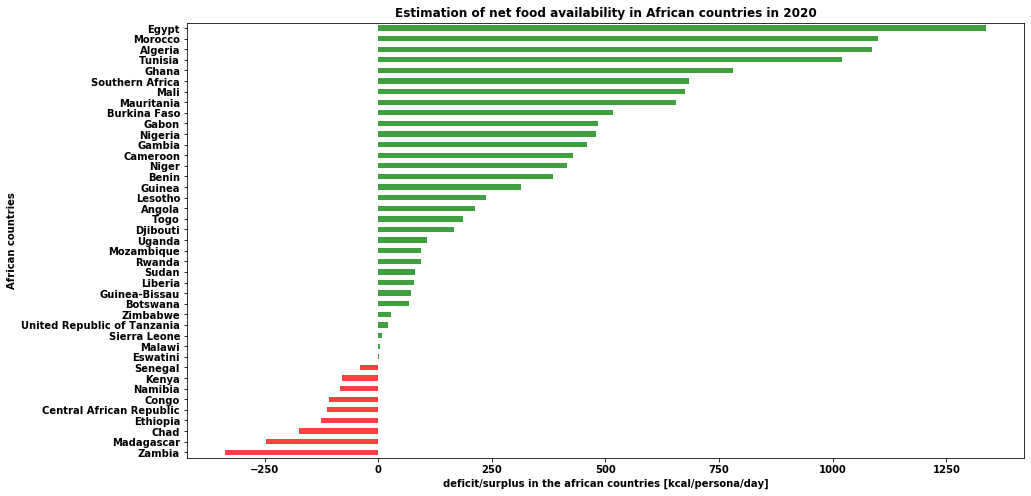

In [89]:
caloric_difference_africa_sorted = caloric_difference_africa[2020].sort_values()
p = caloric_difference_africa_sorted.plot(kind='barh', color=(caloric_difference_africa_sorted > 0).map({True: 'g', False: 'red'}),alpha=0.75, rot=0);
p.set_xlabel("deficit/surplus in the african countries [kcal/persona/day]")
p.set_ylabel("African countries")
plt.title('Estimation of net food availability in African countries in 2020' );

This plot already suggests that only by smart redistribution, Africa could sustain its own food demand. However, having the capabilities and know-how to efficiently set up a food aid operation is harder than it seems. European countries on the other hand have a lot more experience in this field, and they are expected to have an even higher amount of excess food, making it easier to provide for this whole operation. Therefore They will be considered to provide the difference in African countries.

For a better visualization, it is convenient to see the **evolution of the kcal demand** for all the years of interest. By using the `draw_demand_bar`, we wil plot the information for every year combined with an animation to move back and forth in time.  
**_Note_: the code below is used to generate the HTML animation. If the animation doesn't work inside the notebook, click on [this link](https://manuleo.github.io/mADAm_files/african_cal_diff_animation.html)**

In [90]:
# # # Code to generate the animation


# fig = plt.figure()
# animator = animation.FuncAnimation(fig, draw_demand_bar, frames=range(1961, 2021),\
#                                    fargs=(caloric_difference_africa, ),
#                                       repeat=False);
# #HTML(animator.to_jshtml())
# with open(path_dict['african_demand_anim'], "w") as f:
#     print(animator.to_html5_video(), file=f)

In [91]:
IFrame(src='https://manuleo.github.io/mADAm_files/african_cal_diff_animation.html', width = 1100, height=600)

As the animation shows, the African situation **sensitevely improved** over the last 60 years, starting from a share of **75%** of starving countries in 1961 to "just" **21%** in 2020.  
During the years the situation improved differently. The improvement was basic up to the nineties, than dramatically changed from 2000 to now.

Let's now move on to a more understandable map visualization. As usual, we are interested in **2020** for our endpoint, but also on the changing over the years.
**_Note_: if it doesn't show, the 2020 map can be found [here](https://manuleo.github.io/mADAm_files/african_kcal_need2020.html)**  
Links to the other years:
- [1970](https://manuleo.github.io/mADAm_files/african_kcal_need1970.html)
- [1980](https://manuleo.github.io/mADAm_files/african_kcal_need1980.html)
- [1990](https://manuleo.github.io/mADAm_files/african_kcal_need1990.html)
- [2000](https://manuleo.github.io/mADAm_files/african_kcal_need2000.html)
- [2010](https://manuleo.github.io/mADAm_files/african_kcal_need2010.html)

In [92]:
legend_name = "Estimation of kcal/persona/day deficit"
for year in range(1970,2030,10):
    bins = [min(caloric_difference_africa[year]), 0, 200, 450, max(caloric_difference_africa[year])]
    african_kcal_need_map = plot_map(caloric_difference_africa, path_dict['geoworld_json'], \
    african_country_kv, year, "RdYlGn", legend_name, legend_name, path_dict['african_kcal_need'] + str(year) + ".html", bins)
african_kcal_need_map

In [93]:
IFrame(src='https://manuleo.github.io/mADAm_files/african_kcal_need2020.html', width = 800, height=600)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/African_countries_by_GDP_%28PPP%29_per_capita_in_2017.png/1024px-African_countries_by_GDP_%28PPP%29_per_capita_in_2017.png" height="400" width="400" style="float: left; margin-right: 10px;">  

We found an analysis <a href="https://en.wikipedia.org/wiki/List_of_African_countries_by_GDP_(PPP)_per_capita">here</a> about the GDP (Gross Domestic Product) in African countries, which we think can be a good way to evaluate the correctness of our analysis. We show to the left the heat map of Africa in terms of each countries GDP per capita.

Observing the evolution over the last 50 years allow us to better understand and comment the animation above. As we can see from the 1970 map, almost all Africa lived in starving condition with the lowest peak in Guinea-Bissau (at huge deficit of 700 kcal/persona/day needed).

Individual case studies prove the data's accuracy. For example, the Ethiopian famine in the 80's is impressively reproduced and manifests itself as Ethiopia drops to the lowest rank. In general, a very positive development can be observed, as more and more countries manage to reach a surplus regime every single decade, with the highest increase occurring just recently in the last 10 years. 

Ever since 2001, more than half of the examined countries show a net surplus. As of 2019, all of the countries in red were determined to be either war-riddled or politically fragile. Exceptions to the rule are Namibia and Eswatini, which both boast a relatively high GDP per capita (ranked 10th and 11th for the African continent, respectively). Thus, the only explanation would be inequality amongst the population or insufficient distribution of available resources. 



# Determination of European countries with food surplus

## 1) How much human food resources are available for European countries?

### 1.1) Preprocessing

To answer this important question, we will need to import data from the **FAO Dataset**. More specifically, we will focus on the section **Food Balance Sheet** with respect to European countries only. 

In [94]:
food_balance_europe = pd.read_csv(path_dict['food_balance_europe'],encoding='latin-1', low_memory=False);

European countries will be analysed following the same strategy we used for African countries in order to be consistent also in the way by which we assess whether countries are in deficit or have a surplus. To start off, we will:
- **remove** all the columns with title **"Y----F"**.
- **replace** all the **NAN** values with **0** as Item was not available.

In [95]:
food_balance_europe = clean_Fs_and_years(food_balance_europe)
food_balance_europe = food_balance_europe.fillna(0);

The third step to complete **the cleaning** of food_balance_europe consists on adapting names of countries in order to have consistency along our different dataframes.

The easiest of these changes that we observe in our dataframe is **The former Yugoslav Republic of Macedonia** should become **North Macedonia**.

In [96]:
food_balance_europe = replace_names_of_countries(food_balance_europe, [("The former Yugoslav Republic of Macedonia", "North Macedonia")])

Our Dataframe looks like this:

In [97]:
food_balance_europe.head()

Area Code     Area  Item Code                Item  Element Code  \
0          3  Albania       2501          Population           511   
1          3  Albania       2511  Wheat and products          5511   
2          3  Albania       2511  Wheat and products          5611   
3          3  Albania       2511  Wheat and products          5072   
4          3  Albania       2511  Wheat and products          5911   

                         Element          Unit    1961    1962    1963  ...  \
0  Total Population - Both sexes  1000 persons  1669.0  1719.0  1771.0  ...   
1                     Production   1000 tonnes    98.0   146.0    62.0  ...   
2                Import Quantity   1000 tonnes   182.0    89.0   110.0  ...   
3                Stock Variation   1000 tonnes   -52.0    -4.0    56.0  ...   
4                Export Quantity   1000 tonnes     0.0     0.0     0.0  ...   

     2004    2005    2006    2007    2008    2009    2010    2011    2012  \
0  3216.0  3196.0  3180.0  3166.0  3157.0  3151.0  3150.0  3154.0  3162.0   
1   253.0   260.0   231.0   250.0   335.0   333.0   295.0   293.0   300.0   
2   465.0   417.0   414.0   406.0   355.0   343.0   362.0   389.0   377.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     2.0     0.0     0.0     2.0     0.0     0.0     0.0     4.0     4.0   

     2013  
0  3173.0  
1   294.0  
2   360.0  
3     0.0  
4     4.0  

[5 rows x 60 columns]

Given the European countries analysis, and since the structure of this dataset is equivalent to that one, we can again obtain the pairs **(Item Code, 2901) and (Element Code, 664)** for our Europe analysis.

In [98]:
food_supply_europe = obtain_supply(food_balance_europe)

We can now group by **Area** and see the supplies derived from each item available in countries for each particular year.

In [99]:
food_supply_europe = food_supply_europe.set_index("Area")
food_supply_europe.head()

1961    1962    1963    1964    1965    1966    1967  \
Area                                                                         
Albania             2223.0  2242.0  2156.0  2270.0  2254.0  2254.0  2262.0   
Austria             3191.0  3193.0  3248.0  3270.0  3220.0  3232.0  3194.0   
Belarus                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Belgium                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Belgium-Luxembourg  2923.0  2908.0  3007.0  3061.0  2966.0  3067.0  3088.0   

                      1968    1969    1970  ...    2004    2005    2006  \
Area                                        ...                           
Albania             2343.0  2404.0  2415.0  ...  2792.0  2874.0  2855.0   
Austria             3221.0  3153.0  3217.0  ...  3606.0  3640.0  3719.0   
Belarus                0.0     0.0     0.0  ...  2901.0  2987.0  3084.0   
Belgium                0.0     0.0     0.0  ...  3722.0  3716.0  3716.0   
Belgium-Luxembourg  3032.0  3156.0  3068.0  ...     0.0     0.0     0.0   

                      2007    2008    2009    2010    2011    2012    2013  
Area                                                                        
Albania             2860.0  2947.0  2993.0  3076.0  3132.0  3184.0  3193.0  
Austria             3737.0  3717.0  3723.0  3724.0  3735.0  3739.0  3768.0  
Belarus             3186.0  3200.0  3126.0  3196.0  3400.0  3400.0  3250.0  
Belgium             3713.0  3702.0  3697.0  3707.0  3720.0  3715.0  3733.0  
Belgium-Luxembourg     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 53 columns]

In order to check for anomalies in our data, we would like to analyze the **timeline**. We therefore transpose the dataframe and plot the timeline of how food supply in different countries evolved. Legend was suppressed as it is too large.

In [100]:
food_supply_europe = food_supply_europe.transpose();

In [101]:
#converting the year from string to int
food_supply_europe.index = food_supply_europe.index.astype(int)

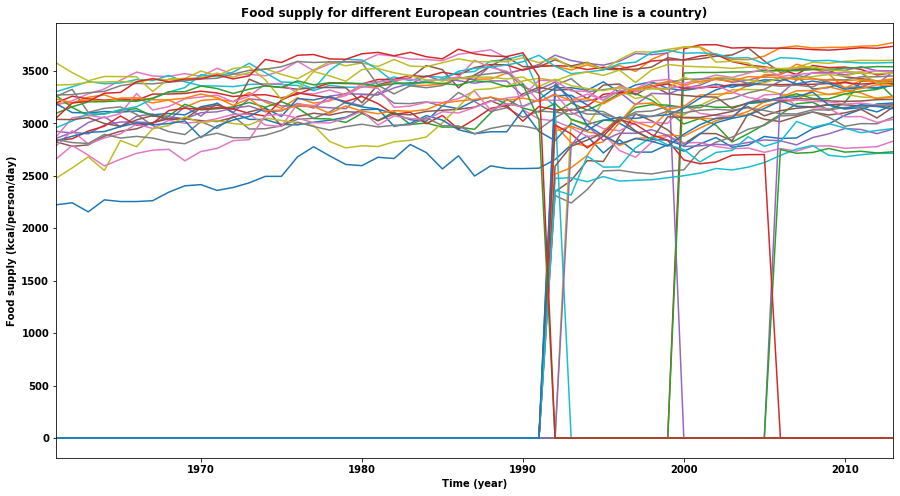

In [102]:
timeline_supply(food_supply_europe, "European")

We can observe a similar situation in this graph as we did in the African countries analysis. As such, we can assume that some countries may have changed names or maybe some other situations occured, which caused countries data to stop being recorded/collected. 

Let's then see which countries have zeros in the values for food supplies.

In [103]:
food_supply_europe.columns.values[(food_supply_europe == 0).any()]

array(['Belarus', 'Belgium', 'Belgium-Luxembourg',
       'Bosnia and Herzegovina', 'Croatia', 'Czechia', 'Czechoslovakia',
       'Estonia', 'Latvia', 'Lithuania', 'Luxembourg', 'Montenegro',
       'Republic of Moldova', 'Russian Federation', 'Serbia',
       'Serbia and Montenegro', 'Slovakia', 'Slovenia', 'North Macedonia',
       'Ukraine', 'USSR', 'Yugoslav SFR'], dtype=object)

Respecting the cronology, we observe that there were some countries on which data stopped being collected, as well as others from which data started being collected after the initial collection year of 1950. After some research on these countries, we found out that:
- **USSR** (Union of Soviet Socialist Republics) was a union of a lot of countries, some of which were not even located in Europe. The Union was dissolved in 26 December 1991, and so the countries **Belarus**, **Ukraine**, **Estonia**, **Republic of Moldova**, **Russian Federation**, **Latvia**, **Lithuania** are the European countries that became independent in Europe.
- **Yugoslav SFR** was made up of the countries that became **Bosnia and Herzegovina**, **Croatia**, **Serbia and Montenegro**, **North Macedonia**, **Slovenia**, all of which obtained their independence between 25 June 1991 - 27 April 1992
- **Czechoslovakia** was dissoluted in 1 January 1993, after a period called The Velvet Revolution (because of the peaceful ways), and split into the two countries **Czechia** and **Slovakia**
- **Serbia and Montenegro** separated themselves in 2006, breaking up the last union still recognized as a successor of Yougoslavia
- **Belgium-Luxembourg** (2003) does not have a main reason to exist, as there is no major event happening in 2003 that would justify the mixing of the two countries. Our understanding lead us to believe this was probably just a grouping created in FAO when collecting the data from the two countries.

Let's then take care of all these cases..

In [104]:
countries_to_merge = {'USSR': ['Belarus', 'Ukraine', 'Estonia', 'Republic of Moldova', 'Russian Federation', 'Latvia', 'Lithuania'], 
                         'Yugoslav SFR': ['Bosnia and Herzegovina', 'Croatia', 'Serbia and Montenegro', 'North Macedonia', 'Slovenia'],
                         'Czechoslovakia': ['Czechia', 'Slovakia'],
                         'Serbia and Montenegro': ['Serbia', 'Montenegro'],
                         'Belgium-Luxembourg': ['Luxembourg', 'Belgium']}
food_supply_europe = merge_countries(food_supply_europe, countries_to_merge)

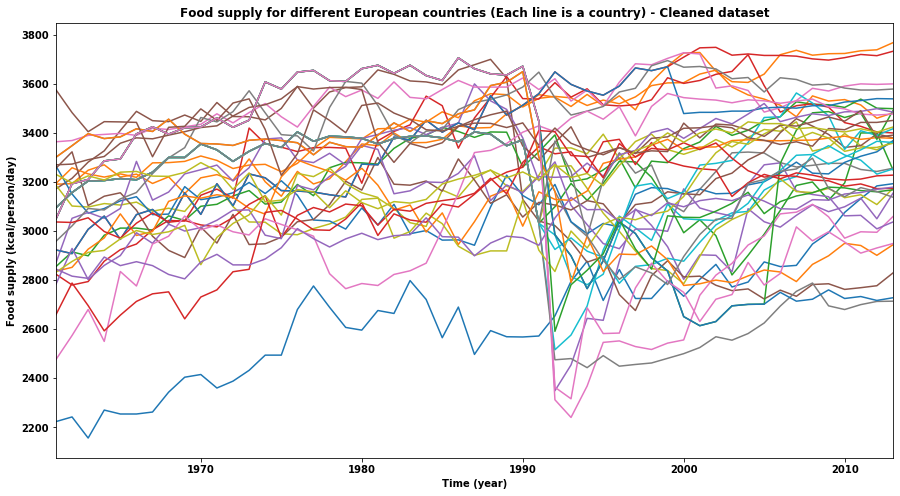

In [105]:
timeline_supply(food_supply_europe, "European", " - Cleaned dataset")

We observe a drop in the *food supply* from most countries that came from the former USSR, which we find to be interesting. While it might not be the case for all of these countries, some of them are vey poor and as such, when separated from the world power that was the USSR, their ability to provide and produce for themselves may have dropped significantly, which is coherent with what we observe. As such, we continue our analysis with these values.

### 1.2) Interpolation

Next, we want to add more columns representing future years until 2020 to prepare cells for extrapolation to make predictions about possible scenarios.

In [106]:
food_supply_europe = prepare_future(food_supply_europe, 2014, 2020)

In [107]:
food_supply_europe = predict_future(food_supply_europe, path_dict['europe_supply_rnn'])

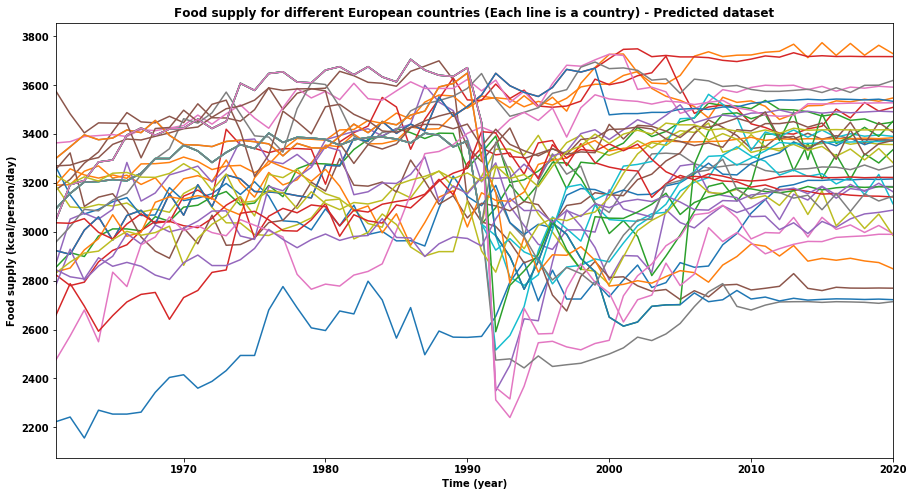

In [108]:
timeline_supply(food_supply_europe, "European", " - Predicted dataset")

Similar to the analysis of African countries, the same conclusions can be drawn about using the neural network method. 

Visualizing our results with a interactive heatmap:

In [109]:
european_country_codes = ["ALB","AUT","BLR","BEL","BIH","BGR","HRV","CZE","DNK","EST","FIN","FRA","DEU","GRC","HUN","ISL","IRL",
                          "ITA","LVA","LTU","LUX","MALTAMISSING","MNE","NLD","NOR","POL","PRT","MDA","ROU","RUS","SRB","SWK",
                          "SVN","ESP","SWE","CHE","MKD","UKR","GBR"]
european_country_names = food_supply_europe.T.index.values


european_country_kv = pd.DataFrame({'codes': european_country_codes,
                                    'names': european_country_names
                                    })

geojson_europe = geojson_world[geojson_world.id.isin(european_country_codes)]
geojson_europe.head()

id                    name  \
2   ALB                 Albania   
9   AUT                 Austria   
12  BEL                 Belgium   
16  BGR                Bulgaria   
18  BIH  Bosnia and Herzegovina   

                                             geometry  
2   POLYGON ((20.59025 41.85540, 20.46317 41.51509...  
9   POLYGON ((16.97967 48.12350, 16.90375 47.71487...  
12  POLYGON ((3.31497 51.34578, 4.04707 51.26726, ...  
16  POLYGON ((22.65715 44.23492, 22.94483 43.82379...  
18  POLYGON ((19.00549 44.86023, 19.36803 44.86300...

We notice, after our manual analysis on the countries that **Malta** is not displayed in the json. Hence, we won't consider it for our analysis

In [110]:
food_supply_europe = food_supply_europe.drop(columns=["Malta"])

Moving into the plot of the European countries to see their actual and past supply. 
**_Note_: the map for 2020 (in case it doesn't load) is available [here](https://manuleo.github.io/mADAm_files/european_supply_map2020.html)**  
Links to other years:
- [1970](https://manuleo.github.io/mADAm_files/european_supply_map1970.html)
- [1980](https://manuleo.github.io/mADAm_files/european_supply_map1980.html)
- [1990](https://manuleo.github.io/mADAm_files/european_supply_map1990.html)
- [2000](https://manuleo.github.io/mADAm_files/european_supply_map2000.html)
- [2010](https://manuleo.github.io/mADAm_files/european_supply_map2010.html)

In [111]:
# Plotting
legend_name = "Food supply in Europe (kcal/person/day)"
for year in range(1970, 2030, 10):
    europe_supply_map = plot_map(food_supply_europe.T, path_dict['geoworld_json'], \
    european_country_kv, year, "Blues", legend_name, legend_name, path_dict['european_supply_map'] + str(year) + ".html", bins=9)
europe_supply_map

In [112]:
IFrame(src='https://manuleo.github.io/mADAm_files/european_supply_map2020.html', width = 1000, height=600)

In [114]:
save_map_data(geojson_europe, european_country_kv, food_supply_europe, "docs/json/europe_supply/europe_supply_{}.geojson", "docs/json/europe_supply/europe_supply_ticks.json", bins=6)

Analyzing the data shows a trend **scaled up but mostly similar** African case. The available food supply in Europe over the last 50 years remained mostly the same, with an available supply between 2500 to 3800 kcal/persona/day.  
Interesting to note the drop the ex USSR had in 2000 after the division, drop already emerged during the previous cleaning of the dataset.

## 2) What is the ideal amount of kcal each European country needs?
Once again, we do a very similar analysis on European countries as we did for the African ones.

### 2.1) How many people live in Europe?

#### 2.1.1) Preprocessing

In this second part of our analysis, we load the list of **European countries**. Secondly, we load the **World Population Database** (United Nation) and therefore we obtain two dataframes: one for males and the other one for females.

In [86]:
with open (path_dict["european_countries_list"],'r') as eu_c:
    eu_countries = [line.rstrip() for line in eu_c] #loading list

We need to check if the FAO Database contains data regarding **every country** in Europe. We will check the intersection with the list `eu_countries`.

In [87]:
eu_to_remove = list(set(eu_countries) - set(food_supply_europe.columns.values))
print("List of countries for which no data is available: " + str(eu_to_remove))

List of countries for which no data is available: ['Malta', 'Channel Islands']


Because there are less countries in Europe, and also because most European countries are part of ONU, we expected most countries to be present in both the FAO database and the population database. These **Channel Islands** are a small set of islands in the English Channel, and because they are so small, we can safely remove them from our scope of interest.

In [88]:
eu_countries = [i for i in eu_countries if not i in eu_to_remove]
eu_to_remove = list(set(eu_countries) - set(food_supply_europe.columns.values))
print("List of countries for which no data is available: " + str(eu_to_remove))

List of countries for which no data is available: []


We now obtain the population for each gender in all european countries.

In [89]:
pop_male_europe = clean_pop_df(pop_male, eu_countries)
pop_female_europe = clean_pop_df(pop_female, eu_countries)

Let's have a look at the final version of male population data grouped by age:

In [90]:
pop_male_europe.head()

country  year     0-4     5-9   10-14   15-19   20-24   25-29   30-34  \
3135  Belarus  1950  333700  282651  395174  382562  361905  237761  150660   
3136  Belarus  1955  418684  315056  264730  374177  357223  337374  219617   
3137  Belarus  1960  491730  406036  305601  255607  360905  342271  323037   
3138  Belarus  1965  448162  482745  398975  299589  248620  350831  331524   
3139  Belarus  1970  368381  450207  485335  400660  299407  247750  348188   

       35-39  ...   55-59   60-64   65-69  70-74  75-79  80-84  85-89 90-94  \
3135  206475  ...  138445  124045   99216  68726  41415  19537   7648  2113   
3136  136496  ...  128674  111772   95381  70127  42393  19507   8196  2262   
3137  208441  ...  150864  108601   89962  70827  45805  21818   8211  2371   
3138  311625  ...  158297  130151   89304  68499  47682  24484   9262  2393   
3139  327625  ...  147426  140703  110454  70311  47732  27537  10041  2554   

     95-99 100+  
3135   365   35  
3136   415   47  
3137   420   50  
3138   448   52  
3139   418   51  

[5 rows x 23 columns]

#### 2.1.2) Interpolation

Similarly to the analysis performed on Africa, we once again interpolate the years with a frequency of **5 years** in *pop_male_europe*, to have a frequency of 1 year. Before doing so, we check again if the evolution in these 5 years intervals occurs in a linear manner.  
**_Note_: as usual, if the animation is not visible in the notebook, click [here](https://manuleo.github.io/mADAm_files/european_pop_growth.html)**

In [91]:
IFrame(src='https://manuleo.github.io/mADAm_files/european_pop_growth.html', width = 1200, height=600)

In [92]:
# # Selecting countries
# countryrand = []
# n_countries = 2
# for i in range(0, n_countries):
#     countryrand.append(random.choice(pop_male_europe.country.drop_duplicates().values))

# fig = plt.figure()
# animator = animation.FuncAnimation(fig, timeline_country_gender, frames=(range(1950, 2025, 5)),\
#                                    fargs = (pop_male_europe, pop_female_europe, "30-34", countryrand), repeat=False)
# #HTML(animator.to_jshtml())

# with open(path_dict['european_pop_growth'], "w") as f:
#     print(animator.to_html5_video(), file=f)

Even if the growth is not so linear as a whole as before, the animation clearly shows that it is linear inside each group of 5 year. As our interpolation works by interpolating on each of these groups, we can proceed with it

In [93]:
pop_male_europe = interpolate_years(pop_male_europe, 1950, 2020)
pop_female_europe = interpolate_years(pop_female_europe, 1950, 2020)

Let's see how the new dataframes for males and females population look like:

In [94]:
pop_male_europe.head()

country  year       0-4       5-9     10-14     15-19     20-24     25-29  \
0  Belarus  1950  333700.0  282651.0  395174.0  382562.0  361905.0  237761.0   
1  Belarus  1951  350696.8  289132.0  369085.2  380885.0  360968.6  257683.6   
2  Belarus  1952  367693.6  295613.0  342996.4  379208.0  360032.2  277606.2   
3  Belarus  1953  384690.4  302094.0  316907.6  377531.0  359095.8  297528.8   
4  Belarus  1954  401687.2  308575.0  290818.8  375854.0  358159.4  317451.4   

      30-34     35-39  ...     55-59     60-64    65-69    70-74    75-79  \
0  150660.0  206475.0  ...  138445.0  124045.0  99216.0  68726.0  41415.0   
1  164451.4  192479.2  ...  136490.8  121590.4  98449.0  69006.2  41610.6   
2  178242.8  178483.4  ...  134536.6  119135.8  97682.0  69286.4  41806.2   
3  192034.2  164487.6  ...  132582.4  116681.2  96915.0  69566.6  42001.8   
4  205825.6  150491.8  ...  130628.2  114226.6  96148.0  69846.8  42197.4   

     80-84   85-89   90-94  95-99  100+  
0  19537.0  7648.0  2113.0  365.0  35.0  
1  19531.0  7757.6  2142.8  375.0  37.4  
2  19525.0  7867.2  2172.6  385.0  39.8  
3  19519.0  7976.8  2202.4  395.0  42.2  
4  19513.0  8086.4  2232.2  405.0  44.6  

[5 rows x 23 columns]

In [95]:
pop_female_europe.head()

country  year       0-4       5-9     10-14     15-19     20-24     25-29  \
0  Belarus  1950  325456.0  287716.0  420006.0  403120.0  424672.0  338168.0   
1  Belarus  1951  338789.2  291637.0  389910.6  402225.4  415571.6  350871.6   
2  Belarus  1952  352122.4  295558.0  359815.2  401330.8  406471.2  363575.2   
3  Belarus  1953  365455.6  299479.0  329719.8  400436.2  397370.8  376278.8   
4  Belarus  1954  378788.8  303400.0  299624.4  399541.6  388270.4  388982.4   

      30-34     35-39  ...     55-59     60-64     65-69     70-74    75-79  \
0  223359.0  326549.0  ...  178569.0  183039.0  152746.0  119379.0  85709.0   
1  242416.2  302527.8  ...  179256.4  177849.8  153480.6  119761.2  85312.8   
2  261473.4  278506.6  ...  179943.8  172660.6  154215.2  120143.4  84916.6   
3  280530.6  254485.4  ...  180631.2  167471.4  154949.8  120525.6  84520.4   
4  299587.8  230464.2  ...  181318.6  162282.2  155684.4  120907.8  84124.2   

     80-84    85-89   90-94   95-99   100+  
0  39512.0  20284.0  7706.0  1924.0  293.0  
1  41588.0  19740.8  7352.0  1810.6  277.8  
2  43664.0  19197.6  6998.0  1697.2  262.6  
3  45740.0  18654.4  6644.0  1583.8  247.4  
4  47816.0  18111.2  6290.0  1470.4  232.2  

[5 rows x 23 columns]

#### 2.1.3) Computing total European population

Lastly, we will compute the total population per year. This new dataframe **pop_tot** will be useful for the next section of our analysis.

In [96]:
pop_tot_europe = obtain_total_pop(pop_male_europe, pop_female_europe)

For the next analysis we will need to match this data with the `food_balance_europe`. We proceed to give to our population data the same shape as the other dataset

In [97]:
pop_tot_europe = reshape_pop_dataframe(pop_tot_europe)

In [98]:
pop_tot_europe.head()

1950       1951       1952       1953       1954  \
Country                                                                         
Albania                 1263164.0  1294529.4  1325894.8  1357260.2  1388625.6   
Austria                 6936442.0  6939834.4  6943226.8  6946619.2  6950011.6   
Belarus                 7745004.0  7745446.2  7745888.4  7746330.6  7746772.8   
Belgium                 8637521.0  8687471.8  8737422.6  8787373.4  8837324.2   
Bosnia and Herzegovina  2661296.0  2716296.8  2771297.6  2826298.4  2881299.2   

                             1955       1956       1957       1958       1959  \
Country                                                                         
Albania                 1419991.0  1463211.0  1506431.0  1549651.0  1592871.0   
Austria                 6953404.0  6976877.8  7000351.6  7023825.4  7047299.2   
Belarus                 7747215.0  7822748.2  7898281.4  7973814.6  8049347.8   
Belgium                 8887275.0  8943292.2  8999309.4  9055326.6  9111343.8   
Bosnia and Herzegovina  2936300.0  2994172.8  3052045.6  3109918.4  3167791.2   

                        ...        2011        2012        2013        2014  \
Country                 ...                                                   
Albania                 ...   2936528.0   2925027.0   2913526.0   2902025.0   
Austria                 ...   8463689.4   8517433.8   8571178.2   8624922.6   
Belarus                 ...   9424345.6   9428115.2   9431884.8   9435654.4   
Belgium                 ...  11008574.2  11078413.4  11148252.6  11218091.8   
Bosnia and Herzegovina  ...   3650254.8   3595031.6   3539808.4   3484585.2   

                              2015        2016        2017        2018  \
Country                                                                  
Albania                  2890524.0   2887979.2   2885434.4   2882889.6   
Austria                  8678667.0   8744213.6   8809760.2   8875306.8   
Belarus                  9439424.0   9441403.4   9443382.8   9445362.2   
Belgium                 11287931.0  11348268.0  11408605.0  11468942.0   
Bosnia and Herzegovina   3429362.0   3399652.6   3369943.2   3340233.8   

                              2019        2020  
Country                                         
Albania                  2880344.8   2877800.0  
Austria                  8940853.4   9006400.0  
Belarus                  9447341.6   9449321.0  
Belgium                 11529279.0  11589616.0  
Bosnia and Herzegovina   3310524.4   3280815.0  

[5 rows x 71 columns]

## 3) Estimantion of ideal human food demand in Europe 

Now we multiply each column of the population data for each matching `age_group` in the calories table (that here we squeeze to allow the multiplication, similar to a transpose rows/columns of the dataset).  
We obtain two datasets: `male_cal_need_europe` and `female_cal_need_europe` reporting total calories needed for **each country in each year per age group per gender**. 
The unit here is **kcal/day**.

In [99]:
#total calories male
male_cal_need_europe = get_calories_need(pop_male_europe, male_calories)
male_cal_need_europe.head()

country  year           0-4          5-9        10-14         15-19  \
0  Belarus  1950  4.449333e+08  520077840.0  964224560.0  1.193593e+09   
1  Belarus  1951  4.675957e+08  532002880.0  900567888.0  1.188361e+09   
2  Belarus  1952  4.902581e+08  543927920.0  836911216.0  1.183129e+09   
3  Belarus  1953  5.129205e+08  555852960.0  773254544.0  1.177897e+09   
4  Belarus  1954  5.355829e+08  567778000.0  709597872.0  1.172664e+09   

          20-24        25-29        30-34        35-39  ...        55-59  \
0  1.085715e+09  713283000.0  451980000.0  586389000.0  ...  365494800.0   
1  1.082906e+09  773050800.0  493354200.0  546640928.0  ...  360335712.0   
2  1.080097e+09  832818600.0  534728400.0  506892856.0  ...  355176624.0   
3  1.077287e+09  892586400.0  576102600.0  467144784.0  ...  350017536.0   
4  1.074478e+09  952354200.0  617476800.0  427396712.0  ...  344858448.0   

         60-64        65-69        70-74        75-79       80-84       85-89  \
0  322517000.0  257961600.0  178687600.0  101052600.0  46888800.0  18355200.0   
1  316135040.0  255967400.0  179416120.0  101529864.0  46874400.0  18618240.0   
2  309753080.0  253973200.0  180144640.0  102007128.0  46860000.0  18881280.0   
3  303371120.0  251979000.0  180873160.0  102484392.0  46845600.0  19144320.0   
4  296989160.0  249984800.0  181601680.0  102961656.0  46831200.0  19407360.0   

       90-94     95-99      100+  
0  5071200.0  876000.0   84000.0  
1  5142720.0  900000.0   89760.0  
2  5214240.0  924000.0   95520.0  
3  5285760.0  948000.0  101280.0  
4  5357280.0  972000.0  107040.0  

[5 rows x 23 columns]

In [100]:
#total calories female
female_cal_need_europe = get_calories_need(pop_female_europe, female_calories)
female_cal_need_europe.head()

country  year           0-4          5-9        10-14        15-19  \
0  Belarus  1950  4.122443e+08  494871520.0  907212960.0  967488000.0   
1  Belarus  1951  4.291330e+08  501615640.0  842206896.0  965340960.0   
2  Belarus  1952  4.460217e+08  508359760.0  777200832.0  963193920.0   
3  Belarus  1953  4.629104e+08  515103880.0  712194768.0  961046880.0   
4  Belarus  1954  4.797991e+08  521848000.0  647188704.0  958899840.0   

          20-24        25-29        30-34        35-39  ...        55-59  \
0  1.019213e+09  811603200.0  500324160.0  718407800.0  ...  392851800.0   
1  9.973718e+08  842091840.0  543012288.0  665561160.0  ...  394364080.0   
2  9.755309e+08  872580480.0  585700416.0  612714520.0  ...  395876360.0   
3  9.536899e+08  903069120.0  628388544.0  559867880.0  ...  397388640.0   
4  9.318490e+08  933557760.0  671076672.0  507021240.0  ...  398900920.0   

         60-64        65-69        70-74        75-79       80-84       85-89  \
0  373399560.0  305492000.0  238758000.0  171418000.0  79024000.0  40568000.0   
1  362813592.0  306961200.0  239522400.0  170625600.0  83176000.0  39481600.0   
2  352227624.0  308430400.0  240286800.0  169833200.0  87328000.0  38395200.0   
3  341641656.0  309899600.0  241051200.0  169040800.0  91480000.0  37308800.0   
4  331055688.0  311368800.0  241815600.0  168248400.0  95632000.0  36222400.0   

        90-94      95-99      100+  
0  15412000.0  3848000.0  586000.0  
1  14704000.0  3621200.0  555600.0  
2  13996000.0  3394400.0  525200.0  
3  13288000.0  3167600.0  494800.0  
4  12580000.0  2940800.0  464400.0  

[5 rows x 23 columns]

Once we have the calories needed for both gender, we can add them together easily to achieve total calories needed for **each country in each year**, and we collect them in the dataframe `total_cal_need_europe`. The unit is **kcal/year**. All of this is done by the `obtain_total_cal_need` function

In [101]:
total_cal_need_europe = obtain_total_cal_need(male_cal_need_europe, female_cal_need_europe)

Let's take a look at total calories dataframe **total_cal**:

In [102]:
total_cal_need_europe.sort_values(by="Calories", ascending=False).head()

country  year      Calories
547  Russian Federation  2000  1.277543e+14
546  Russian Federation  1999  1.277413e+14
545  Russian Federation  1998  1.277284e+14
544  Russian Federation  1997  1.277154e+14
543  Russian Federation  1996  1.277024e+14

For the sake of consistency, we will now reshape our dataframe `total_cal_need_europe` according to the same schema seen for `food_supply_europe`.

In [103]:
total_cal_need_europe = reshape_calories_df(total_cal_need_europe)

Drawing a sample of the final shaped dataframe total calories `total_cal`:

In [104]:
total_cal_need_europe.head()

1950          1951          1952  \
Country                                                            
Albania                 1.041791e+12  1.067157e+12  1.092523e+12   
Austria                 5.906169e+12  5.912127e+12  5.918085e+12   
Belarus                 6.581842e+12  6.573869e+12  6.565896e+12   
Belgium                 7.440138e+12  7.475404e+12  7.510669e+12   
Bosnia and Herzegovina  2.207555e+12  2.252332e+12  2.297108e+12   

                                1953          1954          1955  \
Country                                                            
Albania                 1.117889e+12  1.143255e+12  1.168621e+12   
Austria                 5.924043e+12  5.930001e+12  5.935959e+12   
Belarus                 6.557924e+12  6.549951e+12  6.541978e+12   
Belgium                 7.545935e+12  7.581201e+12  7.616467e+12   
Bosnia and Herzegovina  2.341885e+12  2.386662e+12  2.431439e+12   

                                1956          1957          1958  \
Country                                                            
Albania                 1.202214e+12  1.235807e+12  1.269400e+12   
Austria                 5.950704e+12  5.965449e+12  5.980194e+12   
Belarus                 6.585445e+12  6.628913e+12  6.672380e+12   
Belgium                 7.656335e+12  7.696202e+12  7.736070e+12   
Bosnia and Herzegovina  2.479545e+12  2.527652e+12  2.575759e+12   

                                1959  ...          2011          2012  \
Country                               ...                               
Albania                 1.302993e+12  ...  2.558970e+12  2.551603e+12   
Austria                 5.994939e+12  ...  7.368272e+12  7.414042e+12   
Belarus                 6.715847e+12  ...  8.184568e+12  8.171641e+12   
Belgium                 7.775938e+12  ...  9.508244e+12  9.565091e+12   
Bosnia and Herzegovina  2.623865e+12  ...  3.196515e+12  3.144872e+12   

                                2013          2014          2015  \
Country                                                            
Albania                 2.544237e+12  2.536870e+12  2.529503e+12   
Austria                 7.459812e+12  7.505582e+12  7.551352e+12   
Belarus                 8.158714e+12  8.145787e+12  8.132860e+12   
Belgium                 9.621938e+12  9.678785e+12  9.735632e+12   
Bosnia and Herzegovina  3.093230e+12  3.041587e+12  2.989945e+12   

                                2016          2017          2018  \
Country                                                            
Albania                 2.526050e+12  2.522597e+12  2.519144e+12   
Austria                 7.603258e+12  7.655163e+12  7.707068e+12   
Belarus                 8.125860e+12  8.118860e+12  8.111861e+12   
Belgium                 9.787514e+12  9.839396e+12  9.891278e+12   
Bosnia and Herzegovina  2.963127e+12  2.936309e+12  2.909492e+12   

                                2019          2020  
Country                                             
Albania                 2.515691e+12  2.512237e+12  
Austria                 7.758973e+12  7.810878e+12  
Belarus                 8.104861e+12  8.097861e+12  
Belgium                 9.943160e+12  9.995042e+12  
Bosnia and Herzegovina  2.882674e+12  2.855856e+12  

[5 rows x 71 columns]

We can proceed to plot the results inside a map visualization. The most interesting one is as usual the **2020**, but also analyzing past years is crucial to understanding how the trend changed. 
**_Note_: the link to 2020 in case it won't show up is available [here](https://manuleo.github.io/mADAm_files/europe_est_kcal2020.html)**  
Links for other years:
- [1970](https://manuleo.github.io/mADAm_files/europe_est_kcal1970.html)
- [1980](https://manuleo.github.io/mADAm_files/europe_est_kcal1980.html)
- [1990](https://manuleo.github.io/mADAm_files/europe_est_kcal1990.html)
- [2000](https://manuleo.github.io/mADAm_files/europe_est_kcal2000.html)
- [2010](https://manuleo.github.io/mADAm_files/europe_est_kcal2010.html)

In [105]:
for year in range(1970,2030,10):
    legend_name = "Estimation of kcal/year [10^11 kcal/year]"
    europe_kcal_est_map = plot_map(total_cal_need_europe.divide(10**11), path_dict['geoworld_json'], \
    european_country_kv, year, "YlGn", legend_name, legend_name, path_dict['european_estimation_kcal'] + str(year) + ".html", bins=9)
europe_kcal_est_map

In [106]:
IFrame(src='https://manuleo.github.io/mADAm_files/europe_est_kcal2020.html', width = 1000, height=600)

In [107]:
save_map_data(geojson_europe, european_country_kv, total_cal_need_europe.divide(10**11).T, "docs/json/europe_need/europe_need_{}.geojson", "docs/json/europe_need/europe_need_ticks.json", bins=9)

As we can see, the increasing in population is reflected in increasing of needed kcal in Europe.

## 4) Which countries have more than they need? 
In this Europe evaluation, we flip the scope of our analysis completely. While in the case of Africa, we want to know which countries need most help (as in, are not producing enough to sustainably survive), for Europe we want to find out which countries are producing more food internally than what they need. The point of this analysis is to find out who could help the African countries in need, by giving away some of their production, while still keeping at least a minimum to be healthy.

As with the African analysis, this analysis will take into account the total population dataframe `pop_tot` and the `food_supply_europe`. With regards to the FAO Dataframe of food supply, we will need to transform the unit into **kcal/year** in order to compare results appropriately.

In [108]:
caloric_difference_europe = obtain_difference(pop_tot_europe, food_supply_europe, total_cal_need_europe)

In [109]:
caloric_difference_europe.head()

1961        1962        1963         1964  \
Albania                 -13.834758    6.437203  -78.364674    36.765861   
Austria                 865.618730  870.779595  928.899367   953.978842   
Belarus                 815.470694  877.200747  923.935723   925.675488   
Belgium                 588.233931  574.260475  674.274851   729.277274   
Bosnia and Herzegovina  777.060508  918.659699  933.346142  1007.115164   

                               1965         1966         1967         1968  \
Albania                   21.834368    17.419790    21.230166    98.248729   
Austria                  907.018796   919.030973   881.043010   908.054910   
Belarus                  933.419914   921.544550   945.798567   999.178346   
Belgium                  635.267953   734.632818   754.010615   696.401193   
Bosnia and Herzegovina  1012.962422  1111.095960  1136.325436  1102.647323   

                               1969         1970  ...         2011  \
Albania                  155.460337   162.851283  ...   744.528672   
Austria                  840.066677   904.078311  ...  1349.864434   
Belarus                  992.680403  1041.301381  ...  1020.686503   
Belgium                  818.804401   729.220090  ...  1353.664146   
Bosnia and Herzegovina  1125.058265  1124.555066  ...   734.831924   

                               2012         2013         2014         2015  \
Albania                  794.041235   800.534160   815.804774   812.927833   
Austria                 1354.192008  1383.515474  1328.758610  1390.383215   
Belarus                 1025.394254   880.098242   996.816638   857.158851   
Belgium                 1349.523251  1368.371593  1353.634612  1357.850225   
Bosnia and Herzegovina   653.334435   759.915028   738.663968   795.658111   

                               2016         2017         2018         2019  \
Albania                  818.292383   817.404589   821.619756   821.669430   
Austria                 1339.989372  1390.463523  1343.677415  1386.151286   
Belarus                  958.721120   859.469478   966.582382   931.484184   
Belgium                 1354.710149  1355.474792  1354.426316  1354.660523   
Bosnia and Herzegovina   749.993127   789.841469   782.711656   800.878745   

                               2020  
Albania                  824.708041  
Austria                 1353.341990  
Belarus                  988.133970  
Belgium                 1354.457022  
Bosnia and Herzegovina   800.331316  

[5 rows x 60 columns]

In [110]:
caloric_difference_europe[caloric_difference_europe[2020].values < 0].index

Index([], dtype='object')

When running the exact same analysis on European countries as we did in African ones, it's interesting to observe that in Europe, no country at all is producing less than what they actually need. As such, every single European country's suplly is actually greater than its demand, and should in theory be able to solve the hunger issue in Africa.  

### 4.1) Visualizing the data

We can now proceed to the same visualization we did before, this time with the scope of **visualizing the 2020 situation and evaluating if there has been a deficit of kcal over the past years**

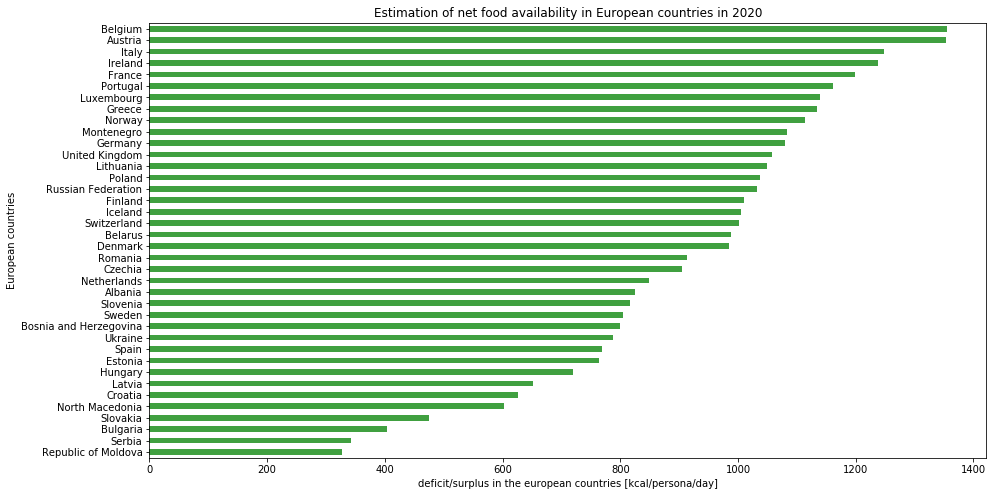

In [111]:
caloric_difference_europe_sorted = caloric_difference_europe[2020].sort_values()
p = caloric_difference_europe_sorted.plot(kind='barh', color=(caloric_difference_europe_sorted > 0).map({True: 'g', False: 'red'}),alpha=0.75, rot=0);
p.set_xlabel("deficit/surplus in the european countries [kcal/persona/day]")
p.set_ylabel("European countries")
plt.title('Estimation of net food availability in European countries in 2020' );

As already noticed before, European countries boast a very high surplus of food supplied. We can now use the animation we used before to assess the situation over the past years and see if Europe had deficits:

In [112]:
# fig = plt.figure()
# animator = animation.FuncAnimation(fig, draw_demand_bar, frames=range(1961, 2021),\
#                                    fargs=(caloric_difference_europe, ),
#                                       repeat=False);
# #HTML(animator.to_jshtml())
# with open(path_dict['european_demand_anim'], "w") as f:
#     print(animator.to_html5_video(), file=f)

In [113]:
IFrame(src='https://manuleo.github.io/mADAm_files/european_cal_diff_animation.html', width = 1200, height=600)

As we can see, **Europe has experienced high affluence periods** since 1961. Over the past 50 years, only in three years some countries presented a really small deficit in calories:
- Albania in 1961 and 1963
- Moldova, Macedonia and Croatia directly after their independence (this situation already emerged during the food supply analysis)

Finally, we draw a map of the European situation. Year **2020** is as usual the most important one, especially for Europe, as we are interested in their actual surplus for the rest of our analysis and because there has been basically no significant change over the last 50 years.  
**_Note_: map for 2020 is available [here](https://manuleo.github.io/mADAm_files/european_kcal_surplus2020.html)**  
Links for other years:
- [1970](https://manuleo.github.io/mADAm_files/european_kcal_surplus1970.html)
- [1980](https://manuleo.github.io/mADAm_files/european_kcal_surplus1980.html)
- [1990](https://manuleo.github.io/mADAm_files/european_kcal_surplus1990.html)
- [2000](https://manuleo.github.io/mADAm_files/european_kcal_surplus2000.html)
- [2010](https://manuleo.github.io/mADAm_files/european_kcal_surplus2010.html)

In [114]:
legend_name = "Estimation of kcal/persona/day surplus"
for year in range(1970,2030,10):
    europe_kcal_surplus_map = plot_map(caloric_difference_europe, path_dict['geoworld_json'], \
    european_country_kv, year, "Greens", legend_name, legend_name, path_dict['european_kcal_surplus'] + str(year) + ".html", bins=8)
europe_kcal_surplus_map

In [115]:
IFrame(src='https://manuleo.github.io/mADAm_files/european_kcal_surplus2020.html', width = 1000, height=600)

As a consequence of the welfare in which Europe is leaving since the post wars period, the available surplus hasn't changed a lot over the years. However, a little increase is notable since 1970 to now.  
With the information we gathered so far, we can proceed to a **comparison between Africa and Europe**, to then move on to an analysis on which European countries could potentially help African countries in need.

# Which European countries can help Africa?

We have easily noticed that in Europe, every country has more food than what they need to healthily survive. We will now plot a map that shows this difference more noticeably.

In [116]:
afr_eu_country_kv = european_country_kv.copy()
afr_eu_country_kv = afr_eu_country_kv.append(african_country_kv)

afr_eu_country_kv = afr_eu_country_kv.sort_values(by='names')

geojson_afr_eu = geojson_world[geojson_world.id.isin(afr_eu_country_kv.codes)]
geojson_afr_eu.head()

id     name                                           geometry
1   AGO   Angola  MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...
2   ALB  Albania  POLYGON ((20.59025 41.85540, 20.46317 41.51509...
9   AUT  Austria  POLYGON ((16.97967 48.12350, 16.90375 47.71487...
12  BEL  Belgium  POLYGON ((3.31497 51.34578, 4.04707 51.26726, ...
13  BEN    Benin  POLYGON ((2.69170 6.25882, 1.86524 6.14216, 1....

In [117]:
caloric_difference_world = pd.concat([caloric_difference_africa, caloric_difference_europe])
caloric_difference_world = caloric_difference_world.sort_index()

Below we plot the surplus/deficit of calories in Africa and Europe in the year of **2020**, for the comparison mentioned before.

In [118]:
legend_name = "Estimation of kcal/persona/day surplus"
bins = [min(caloric_difference_world[2020]), 0, 300, 600, 900, max(caloric_difference_world[2020])]
afr_eu_kcal_surplus_map = plot_map(caloric_difference_world, path_dict['geoworld_json'], \
afr_eu_country_kv, year, "RdYlGn", legend_name, legend_name, path_dict['world_kcal_surplus'] + str(2020) + ".html", bins)
afr_eu_kcal_surplus_map

In [119]:
IFrame(src='https://manuleo.github.io/mADAm_files/world/world_kcal_surplus2020.html', width = 1100, height=800)

In [120]:
save_map_data(geojson_afr_eu, afr_eu_country_kv, caloric_difference_world.T, "docs/json/cal_world/cal_world_{}.geojson", "docs/json/cal_world/cal_world_ticks.json",\
              bins=[0, 300, 600, 900], year_start = 2020)

This map illustrates the previously stated assumption that Europe is in a much better food situation than African countries in general. This is obviously observed by checking that there are no countries in Europe with a color "lower" than yellow-ish green, while in Africa we observe multiple countries colored in orange and even red! These african countries which don't have enough food to feed some of their citizens are the ones we consider to be in most dire need of help, and thus we will try to come up with opportunities of how to help them in the future.   
Another interesting thing to observe is that there seems to be a line dividing the hunger in the world in North and South. By looking at the plots generated by the above cell (located in *visualization/world*), we notice that this line has been going more and more south over the decades, which means that the hunger situation is slowly being solved as years go by. The main reason we think that such a line exists and it's going south is that the countries in the north of Africa are developing more rapidly than their subsaharan counterparts, and are subsequently able to provide better quality of life for their citizens.

Furthermore, comparing the countries in Europe which have the highest surplus to the African countries with the highest deficit would be of interest as well. We consider the countries in need of help as those that do not have a surplus of at least **300** kcal/person/day (orange and red in the map). This selection makes sense because the values we calculate are averaged over the whole population, and if a country has a low surplus, it may mean that a big slice of the population are still starving.

In [121]:
# The countries with deficit in calories
african_countries_to_help = caloric_difference_africa[caloric_difference_africa[2020].values < 300][2020].sort_values(ascending = False)
number_of_need_of_help = len(african_countries_to_help.index)

In [122]:
# The countries in Europe with highest surplus in calories
caloric_difference_highest_europe = caloric_difference_europe[2020].sort_values(ascending=False).head(number_of_need_of_help).sort_values(ascending=True)

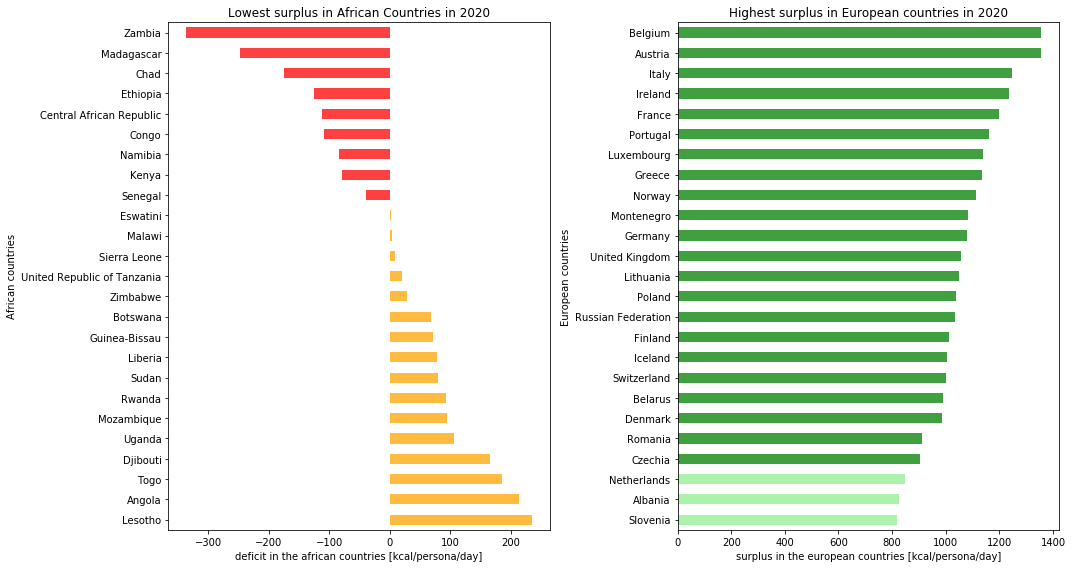

In [123]:
grid = plt.GridSpec(1,2)

# negative african countries
plt.subplot(grid[0, 0]);
p = african_countries_to_help.plot(kind='barh', color=(african_countries_to_help > 0).map({True: 'orange', False: 'red'}),alpha=0.75, rot=0);
p.set_xlabel("deficit in the african countries [kcal/persona/day]")
p.set_ylabel("African countries")
plt.title('Lowest surplus in African Countries in 2020' )

# highest surplus europe countries
plt.subplot(grid[0, 1]);
p1 = caloric_difference_highest_europe.plot(kind='barh', color=(caloric_difference_highest_europe > 900).map({True: 'g', False: 'lightgreen'}),alpha=0.75, rot=0);
p1.set_xlabel("surplus in the european countries [kcal/persona/day]")
p1.set_ylabel("European countries")
plt.title('Highest surplus in European countries in 2020' )

plt.tight_layout()
plt.show()

By looking at the difference between the country most in need **Zambia** and the country with the highest surplus **Belgium**, we see that Belgium alone has way more extra food than the lacking countries need individually. As such, we think that an interesting analysis to be made is which European countries could solve African hunger on their own. Below we analyse how much Africa needs in total, and how much Belgium alone "can" provide.

In [124]:
need_in_africa = abs(african_countries_to_help[african_countries_to_help.values < 0].sum())
print("African countries with a deficit need {0:.2f} extra kcal/person/day in total to solve hunger.".format(need_in_africa))

African countries with a deficit need 1306.82 extra kcal/person/day in total to solve hunger.


In [125]:
print("Belgium has {0:.2f} kcal/person/day over their basic needs.".format(caloric_difference_highest_europe['Belgium']))

Belgium has 1354.46 kcal/person/day over their basic needs.


These numbers need to be multiplied by the countries' population to allow for direct comparison! We can say however that each person in Belgium could help one person/day in each of the most starving countries in Africa, while still maintaining some extra kcals (around 300 kcal). We proceed to do the analysis on the total caloric need for the starving countries we picked out (less than 0 kcal/person/day).

In [126]:
# the african countries with negative surplus
deficit_africa = pd.DataFrame(african_countries_to_help[african_countries_to_help.values < 0])

# european countries with highest surplus (per person)
caloric_surplus_europe_high = pd.DataFrame(caloric_difference_europe[2020].sort_values(ascending=False).head(len(deficit_africa.index)).sort_values(ascending=True))

In [127]:
total_need_africa = deficit_africa.merge(pop_tot_africa[2020], left_index=True, right_index=True)
total_need_africa['Total deficit (kcal/year)'] = total_need_africa['2020_x'] * total_need_africa['2020_y']*365
total_need_africa = total_need_africa.drop(columns=['2020_x', '2020_y']).sort_values(by='Total deficit (kcal/year)', ascending=False)
total_need_africa

Total deficit (kcal/year)
Namibia                               -7.753115e+10
Central African Republic              -1.973362e+11
Congo                                 -2.194120e+11
Senegal                               -2.408757e+11
Chad                                  -1.049659e+12
Kenya                                 -1.541405e+12
Zambia                                -2.260161e+12
Madagascar                            -2.498640e+12
Ethiopia                              -5.256981e+12

In [128]:
total_extra_europe = caloric_surplus_europe_high.merge(pop_tot_europe[2020], left_index=True, right_index=True)
total_extra_europe['Total surplus (kcal/year)'] = total_extra_europe['2020_x'] * total_extra_europe['2020_y']*365
total_extra_europe = total_extra_europe.drop(columns=['2020_x', '2020_y']).sort_values(by='Total surplus (kcal/year)')
total_extra_europe

Total surplus (kcal/year)
Luxembourg               2.603685e+11
Norway                   2.203824e+12
Ireland                  2.230506e+12
Greece                   4.316255e+12
Portugal                 4.321679e+12
Austria                  4.448890e+12
Belgium                  5.729637e+12
Italy                    2.754328e+13
France                   2.854461e+13

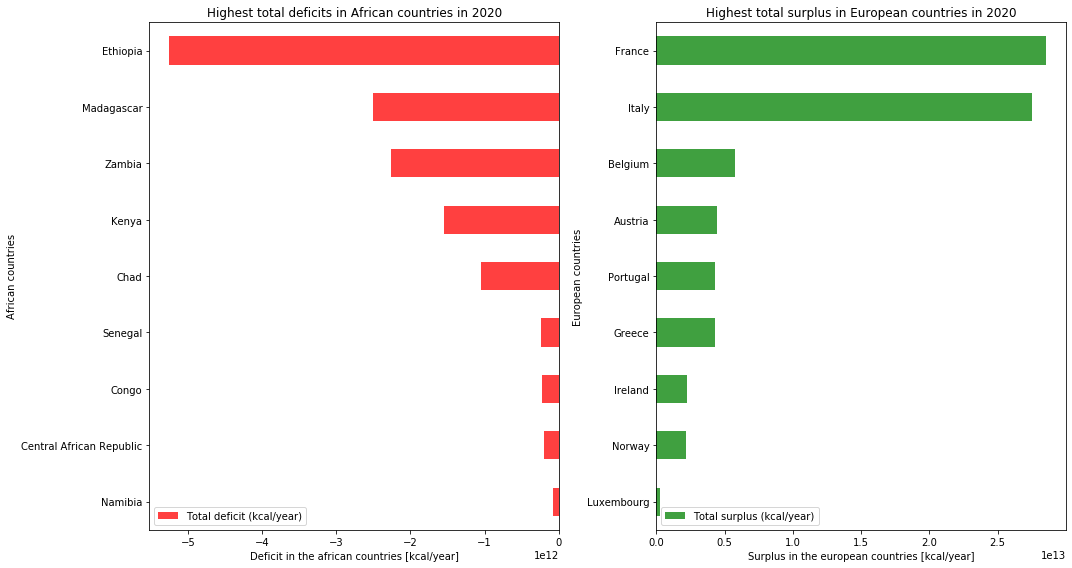

In [129]:
grid = plt.GridSpec(1,2);

ax0 = plt.subplot(grid[0, 0]);
total_need_africa.plot(kind='barh', color='r',alpha=0.75, rot=0, ax = ax0 );
plt.xlabel("Deficit in the african countries [kcal/year]")
plt.ylabel("African countries")
plt.title('Highest total deficits in African countries in 2020' )
ax1 = plt.subplot(grid[0, 1]);

total_extra_europe.plot(kind='barh', color='g',alpha=0.75, rot=0, ax = ax1);
plt.xlabel("Surplus in the european countries [kcal/year]")
plt.ylabel("European countries")
plt.title('Highest total surplus in European countries in 2020' )

plt.tight_layout()
plt.show()

We now see that **France** is actually the one with highest total surplus (of the ones with highest surplus per person). This is due to the fact that France has a much higher population than Belgium does. Following now is the repetition of the previous analysis if France alone could solve the sum of African deficits.

In [130]:
need_in_africa = abs(total_need_africa['Total deficit (kcal/year)'].sum())
print("African countries with a deficit need {0:.2E} extra kcal/year in total to solve hunger.".format(need_in_africa))

African countries with a deficit need 1.33E+13 extra kcal/year in total to solve hunger.


In [131]:
surplus_france = total_extra_europe['Total surplus (kcal/year)']['France']
print("France has {0:.2E} kcal/year over their basic needs.".format(surplus_france))

France has 2.85E+13 kcal/year over their basic needs.


From this analysis, we see that the total surplus in France is **over double** of the sum of deficits in African countries. This result shows that the European countries with a high surplus per person are indeed very capable of feeding a large percentage of starving people in Africa.

The final interesting analysis we want to look into is the actual total surplus in each European country. From that, we choose the countries that have the highest of total surplus (multiply the surplus per person by the country population) and then we choose the ones with the highest values.

In [132]:
total_europe = pd.DataFrame(caloric_difference_europe[2020]).merge(pop_tot_europe[2020], left_index=True, right_index=True)
total_europe['Total surplus (kcal/year)'] = total_europe['2020_x'] * total_europe['2020_y']*365
total_europe = total_europe.drop(columns=['2020_x', '2020_y']).sort_values(by='Total surplus (kcal/year)', ascending=False).head(len(deficit_africa.index)).sort_values(by='Total surplus (kcal/year)')
total_europe

Total surplus (kcal/year)
Romania                          6.409110e+12
Ukraine                          1.256577e+13
Spain                            1.312546e+13
Poland                           1.432861e+13
United Kingdom                   2.619960e+13
Italy                            2.754328e+13
France                           2.854461e+13
Germany                          3.301847e+13
Russian Federation               5.501934e+13

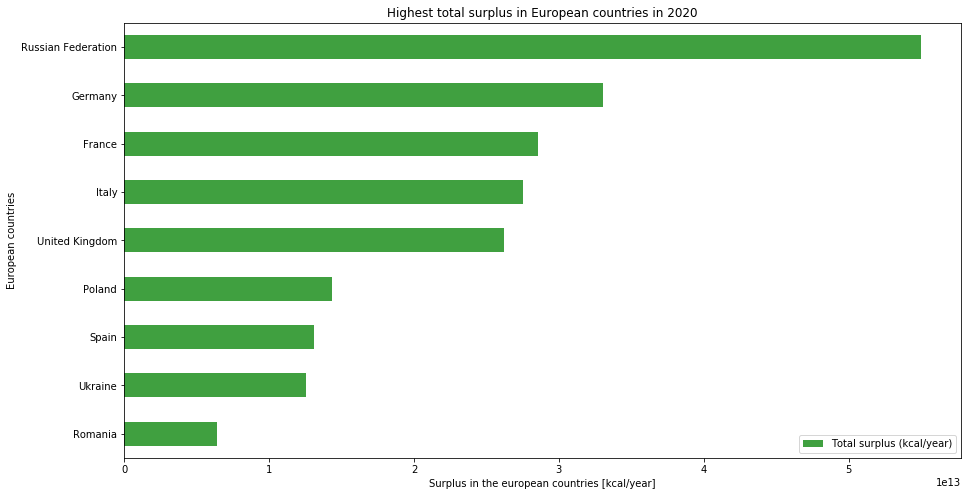

In [133]:
p1 = total_europe.plot(kind='barh', color='g',alpha=0.75, rot=0);
p1.set_xlabel("Surplus in the european countries [kcal/year]")
p1.set_ylabel("European countries")
plt.title('Highest total surplus in European countries in 2020' )
plt.show()

Because the **Russian Federation** has such a high population, we see that, even though its surplus/person is not very high compared to other European countries, the total surplus in the full country will actually overrrule the other countries' surplus. For the sake of consistency, we print below the actual total surplus of **Russian Federation** and compare it to the total deficit in Africa.

In [134]:
print("African countries with a deficit need {0:.2E} extra kcal/year in total to solve hunger.".format(need_in_africa))

African countries with a deficit need 1.33E+13 extra kcal/year in total to solve hunger.


In [135]:
total_surplus_russia = total_europe['Total surplus (kcal/year)']['Russian Federation']
print("The Russian Federation has {0:.2E} kcal/year over their basic needs.".format(total_surplus_russia))

The Russian Federation has 5.50E+13 kcal/year over their basic needs.


From this shift in first seeing the total country's surplus, we arrive to the conclusion that the **Russian Federation** alone has a whopping **5 times** bigger surplus than what is needed to solve hunger in the African countries with a deficit.  
With this analysis, we're able to see that Europe is very likely able to solve the hunger issue in Africa by giving up a **small fraction** of the extra calories that are not currently being put to use.

### A summing up to now  

The results we came up with are satisfactory as they **accurately reproduce what was expected**. They also allowed for interesting analysis. We decided to conduct an analysis on Europe too as it's interesting to see how much spare food would be available for redistribution, as European countries are more likely to be able to provide help. Furthermore, it was decided to restrict further analysis to 2020 as the interest is in the contemporary situation. **Nine African countries** were found to show an overall deficit in supply, meaning unlike other African countries, they are not capable of solving their issues themselves.

## Next steps until Milestone 3

1. **Split the nutrition supply into macronutrients**, in order to do so we will use the FAO food supply dataset, this time by choosing the protein and fat supply (the charbohydrates will be derived by using _total_carbo (computed basing on kcal) - (fat + supply)_. Then we will compute the needed amounts of these nutrients with the use of a simple approximation on the already computed kcal (55% charbo/ 25% proteins/ 20% fat) and we will compute the difference between the two. In this sense, the analysis will be **fairly similar** to what we already did.  
2. After achieving this information, we can compute what are the **best final products that can represent African needs** over all the three macronutrients (and the total kcals needed). In order to do so, we will produce a ranking of products that best match each of the three drivers. Once we have this, we can sample a bunch of products and decide to use them to produce a _"simple diet"_ for African countries.
3. We then will decide **how Europe should send products to Africa**. As a first approximation, we will aggregate African countries and the same will be done for European ones. In this sense, the Europe as a whole won't be any problem to send products to Africa. We will need to consider the amount of food supply in the whole europe using another time the FAO dataset.
4. Having decided which products we should send from Europe and attested that we can send them, we'll find **which countries should receive which food items and in what quantities** (considering their surplus and deficit).
    - At this point, we will decide if proceeding with the simple approximation up to the end or not. Our plan now start to move from seeing the European countries as a whole (first approximation) to a second, more in-depth step were we will decide **how to redistribute the aid sending** among all the considered European countries. This step will be done by considering the total supply available in each country in absolute value and then scale it taking into account the population. This will allow to define **a share** for the products.
5. **Final visualization steps and data story**
    - Improve the **visualization methods** already used and come up with new ones. As example, we would introduce maps changing over time for the fist part of the analysis instead of sticking them to a single year. Also, the animations will be developed in Javascript, allowing the user to enjoy the visualization experience with **real-time manipulations of the data**.
    - In parallel to the visualization improvement, we will develop a data story that **presents the issue we want to solve**, and propose **our way to solve it**. The data story we'll propose will probably follow the main points of the analysis we have done so far about Africa vs Europe supply, and from this baseline we'll move to the "simple diet" introduction.

# Optimizing the distribution of products from Europe to Africa

The idea of optimizing the distribution of products from Europe to Africa presupposes the knowledge of the countries that will help and the countries that will be helped. In this context, we have chosen that helper European countries will be **Italy, France, Germany, United Kingdom, Spain**. This decision is justified by different reasons:
- The total surplus of Europe is 2 orders of magnitude higher than the deficit in Africa. We will take this results and adapt it to the scope of our analysis. More specifically, this simplification will allow to stress the fact that **the problem of African starvation can come to an end by the hand of just few countries and not necessarily the whole world**.
- During the analysis of food prices we were not able to scrape costs of every food item in every european country. The decision is then to narrow it down.
- The choice will be tested with a GWP analysis on the richest European countries that should be involved in the scope of helping Africa.

As regards African countries, our plan is to primarily help countries showing a deficit predicted by our initial model. In addition, we will extend the scope to other African countries that shows a weak surplus. As such, we set the threshold of **300kcal/persona/day** for the food availability. If a country is below this upper bound it will be helped to reach it. For the sake of completeness, we want to let the reader know that our model is accurate in many ways but still doesn't take into account of different phenomena that can altarate our values such as **wealth distribution**, **civil wars**, **climate disasters**,etc. 

## 1) How much African countries really need to solve the hunger problem?

Let's have a look at the countries we need to help:

In [136]:
af_real_deficit = np.abs(300 - african_countries_to_help)
af_real_deficit = af_real_deficit.to_frame()
af_real_deficit.tail()

2020
Central African Republic  411.940700
Ethiopia                  425.280446
Chad                      475.076246
Madagascar                547.213290
Zambia                    636.827454

Plotting the countries vs the amount of kilocalories they need to recevive in order to reach an desired availability of **300kcal/persona/day**:

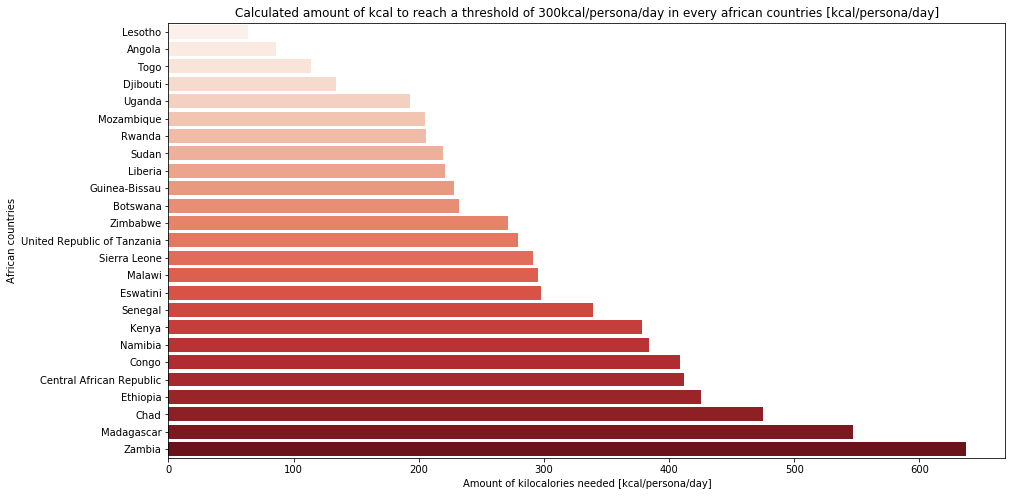

In [137]:
sns.barplot(y="index", x=2020, data=af_real_deficit.reset_index(), palette="Reds")
plt.xlabel("Amount of kilocalories needed [kcal/persona/day]")
plt.ylabel("African countries")
plt.title("Calculated amount of kcal to reach a threshold of 300kcal/persona/day in every african countries [kcal/persona/day]");

In the plot above we see how the darker red coloured countries like **Zambia**, **Madagascar** and **Chad** are most in need. The situation here is flipped so the reader must pay attention to the context of this plot to fully understand the meaning. <br><br>
Now we will scale the problem to its real dimensions,*i.e.* we will multiply these values for the population of each country respecetively and for 365 day/year. The results keep the structure but the unit of values will be **kcal/year**.

In [138]:
af_real_deficit_tot = af_real_deficit.merge(pop_tot_africa[2020], left_index=True, right_index=True)
af_real_deficit_tot['Total deficit (kcal/year)'] = af_real_deficit_tot['2020_x'] * af_real_deficit_tot['2020_y']*365
af_real_deficit_tot = af_real_deficit_tot.drop(columns=['2020_x', '2020_y']).sort_values(by='Total deficit (kcal/year)', ascending=False)
af_real_deficit_tot.head()

Total deficit (kcal/year)
Ethiopia                                  1.784549e+13
Kenya                                     7.429362e+12
United Republic of Tanzania               6.083874e+12
Madagascar                                5.530806e+12
Zambia                                    4.273204e+12

## 2) GDP Analysis on European countries

Since we have set the number of countries that will be "the helper", now we want to understand how much they should contribute individually to the cause. In particular, the scope is to define an index by which we will weight the contribution of each European country. According to this [website](https://www.thebalance.com/gdp-per-capita-formula-u-s-compared-to-highest-and-lowest-3305848), "the **GDP per capita is a measure of a country's economic output** that accounts for its number of people. It is a good measurement of a country's standard of living". This looks like exactly what we are looking for. Starting from the GDP per capita, it will be relatively easy to compute an **effective weight for how prosperous a country is**. The goal here is to **determine a measure for how much countries should give up of their surplus** and the idea is to model the optimization problem in order to **penalize countries with highest GDP that should indeed contribute the most**.
We will show initally all the countries but then narrow it down as mentioned before.

We load the dataset from the FAO on **Macro Statistics and Key Indicators**:

In [139]:
gdp_europe = pd.read_csv("data/raw/Macro-Statistics_Key_Indicators_E_Europe.csv")
gdp_europe.head(2)

Area Code     Area  Item Code                    Item  Element Code  \
0          3  Albania      22008  Gross Domestic Product          6109   
1          3  Albania      22008  Gross Domestic Product          6110   

                Element      Unit         Y1970 Y1970F              Y1970N  \
0  Value Local Currency  millions  11327.885280      X  Data from UNSD AMA   
1             Value US$  millions   2265.577056      X  Data from UNSD AMA   

   ...              Y2014N         Y2015 Y2015F              Y2015N  \
0  ...  Data from UNSD AMA  1.434307e+06      X  Data from UNSD AMA   
1  ...  Data from UNSD AMA  1.138692e+04      X  Data from UNSD AMA   

          Y2016 Y2016F              Y2016N         Y2017 Y2017F  \
0  1.475251e+06      X  Data from UNSD AMA  1.552983e+06      X   
1  1.188368e+04      X  Data from UNSD AMA  1.303936e+04      X   

               Y2017N  
0  Data from UNSD AMA  
1  Data from UNSD AMA  

[2 rows x 151 columns]

We are interested in the **Gross Domestic Product in US Dollars**. We now filter down for Element Code and Item Code. In particular **Item Code** equal to **22008** corresponds to "Gross Domestic Product" and **Element Code** equal **22008** corresponds to "Value US$"

In [140]:
#filtering element code and item code
gdp_europe = gdp_europe[(gdp_europe["Element Code"]==6110) & (gdp_europe["Item Code"]==22008)]

A short note on the dataset: the most recent observation is for 2017 and in our analysis many times we predicted the data up to 2020 if not available. In this case, we decide not to do it since we are not interested in the exact value of GDP, but rather to an index. Therefore, we accept the error as it will be neglegible.

We clean now a little bit our dataframe in order to delete information we don't need:

In [141]:
#Delete all the columns but Area and Y2017, set the index as Area (name of the country)
gdp_europe = gdp_europe[["Area","Y2017"]].set_index("Area")
#Rename column
gdp_europe = gdp_europe.rename(columns={"Y2017": "GDP [millions US$]"})
#Drop Malta as its not in our scope
gdp_europe = gdp_europe.drop("Malta")
#Filter down to the coutries in our main list european_country_kv
gdp_europe = gdp_europe[gdp_europe.index.isin(european_country_kv.names)]
gdp_europe.head()

GDP [millions US$]
Area                                      
Albania                       13039.355905
Austria                      416835.975860
Belarus                       54441.189058
Belgium                      494763.551890
Bosnia and Herzegovina        18169.075913

Let's visualize quickly this result:

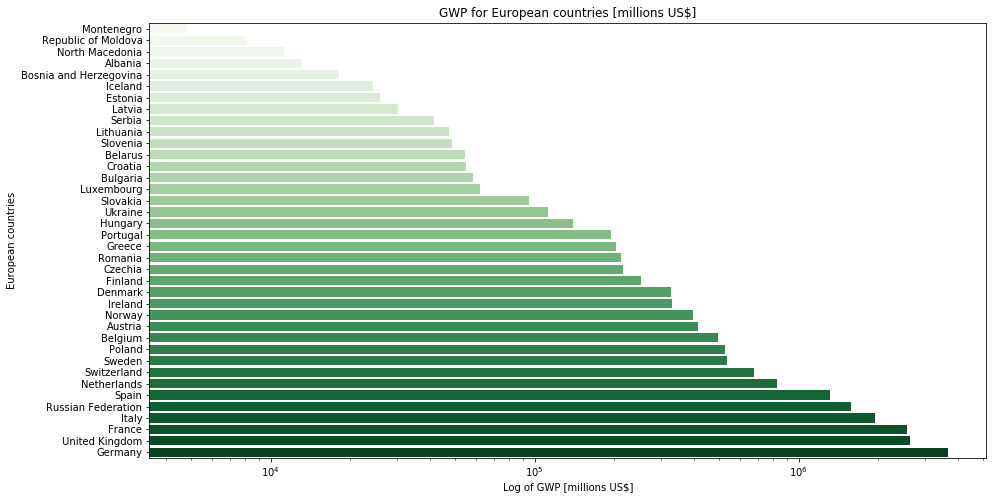

In [142]:
p = sns.barplot(y="Area", x="GDP [millions US$]",\
            data=gdp_europe.sort_values(by="GDP [millions US$]",ascending=True).reset_index()\
            ,palette="Greens")
p.set(xscale="log") #we use log axis because we are are more interested in the order of magnitude than the exact value
plt.xlabel("Log of GWP [millions US$]")
plt.ylabel("European countries")
plt.title("GWP for European countries [millions US$]");

As we can see **Germany, United Kingdom, France, Italy and Spain are the countries with highest GDP in Europe**. This justifies perfectly our design choice of narrowing down the helper countries to these five. Since we are not taking into account of population, Russian Federation shows up in the list of richest countries. Let's analyse now what happens if we divide by population. We expect that Switzerland and Luxembourg will be at the top of the list while Russian Federation will lose positions.

In [143]:
#create dataframe gdp_capita
gdp_capita = pd.DataFrame(index=gdp_europe.index)
#retrieve population data
pop_tot_2020 = pop_tot_europe[[2020]]
#dividing gwp for population
gdp_capita["GDP 100kUS$/capita"] = gdp_europe.values/pop_tot_2020.values*1000
gdp_capita.head()

GDP 100kUS$/capita
Area                                      
Albania                           4.531015
Austria                          46.282197
Belarus                           5.761386
Belgium                          42.690245
Bosnia and Herzegovina            5.537976

Plotting the results:

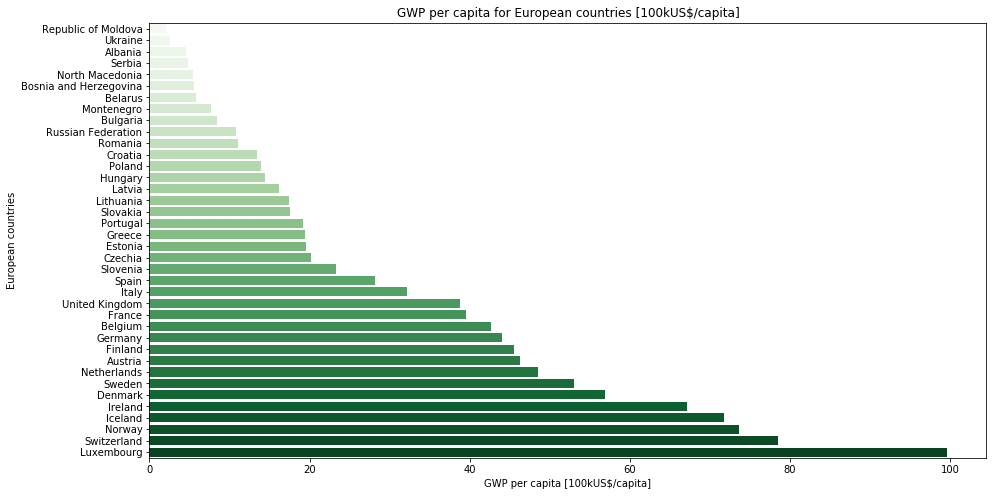

In [144]:
p = sns.barplot(y="Area", x="GDP 100kUS$/capita",\
            data=gdp_capita.sort_values(by="GDP 100kUS$/capita",ascending=True).reset_index()\
            ,palette="Greens")
plt.xlabel("GWP per capita [100kUS$/capita]")
plt.ylabel("European countries")
plt.title("GWP per capita for European countries [100kUS$/capita]");

Our expectations are met. Switzerland and Luxembourg are the richest countries if considered the well-being of every person. Frow now on we will consider **the GWP per capita as the weight indicating at what extent countries should contribute to the African cause**. 

## 3) Modelling the optmization problem

In this chapter we will introduce **a method to redistribute food among African countries** that are in need. The idea behind the implementation is to **minimize the amount of food that has to be delivered** by our five best european contries. While minimizing, we will have to respect the demand constraint as well as the constraint on food availability of each European country. It is very important to model our problem in a way that richest countries with an higher food availability will have to give up more and viceversa. It is now way more clear where the analysis on GWP will come in handy.

The objective function to be minimized is a **quadratic non-negative weighted sum of food [kcal/year]**. More spefically, the weights we designed take into account both of GWP of a country and the food availability [kcal/year]. The modelling choice is justified by the fact that a rich country with a large surplus should contribute more than a relatively poor country with less possibilities.

The problem we want to model is a **Quadratic Program with Linear Constraints** a.k.a **QP**. The choice of a quadratic objective function is due the fact that we will need to evenely distribute the resources and this means that weights will have to increase quadratically with the amount of food given away. It makes sense to say that the more a country gives away of its surplus, the less the same country should contribute further if other countries didn't countribute at all yet.

In particular:
- $Y$ is a matrix in $R^{mxn}$ in which $m$ is the number of European countries and $n$ is the number of African countries. Each entry $y_{ij}$ of the matrix $Y\in{R^{mxn}}$ is the amount [kcal/year] of kilocalories that the European country $i\in{1,...,m}$ will have to send to the African country $j\in{1,...,n}$
- The weights will be in the interval $[-1,1]$. Initally we normalize the GWP per capita of every european country. Afterwards, we will calculate the gwp_inverse = (1-gwp_normalized). The final weight is computed by multiplying the food surplus for gwp_inverse. The number obtained will be the measure by which the logic "The richest gives more" is respected. We will name the weights $w\in{R^{mx1}}$.
- The objective function is $\sum_{i=1}^{m}\sum_{j=1}^{n}{w_jy_{ij}^2 + w_jy_{ij}}$
- The constraints can be considered a restriction on the value that our decision variable will assume. By restricting the feasibile set we will impose the following limits: 
  - non-negativity of food [kcal/year] sent
  - supply and demand must be met according to European country surplus and African countries deficit.
  - even distribution of resources


The first step is then to normalize the GWP in order to scale them in the interval $[-1,1]$:

In [145]:
scaler = MinMaxScaler()
scaler.fit(gdp_capita.values.reshape(-1,1)) #Min Max of sklearn used
gdp_europe_capita_scaled = pd.DataFrame(index=gdp_capita.index) #create new dataframe
gdp_europe_capita_scaled["GDP 100kUS$/capita"] = np.round_(scaler.transform(gdp_capita.values.reshape(-1,1)),6) #round values in order to have clean numbers
gdp_europe_capita_scaled.head()

GDP 100kUS$/capita
Area                                      
Albania                           0.025796
Austria                           0.453856
Belarus                           0.038410
Belgium                           0.417029
Bosnia and Herzegovina            0.036120

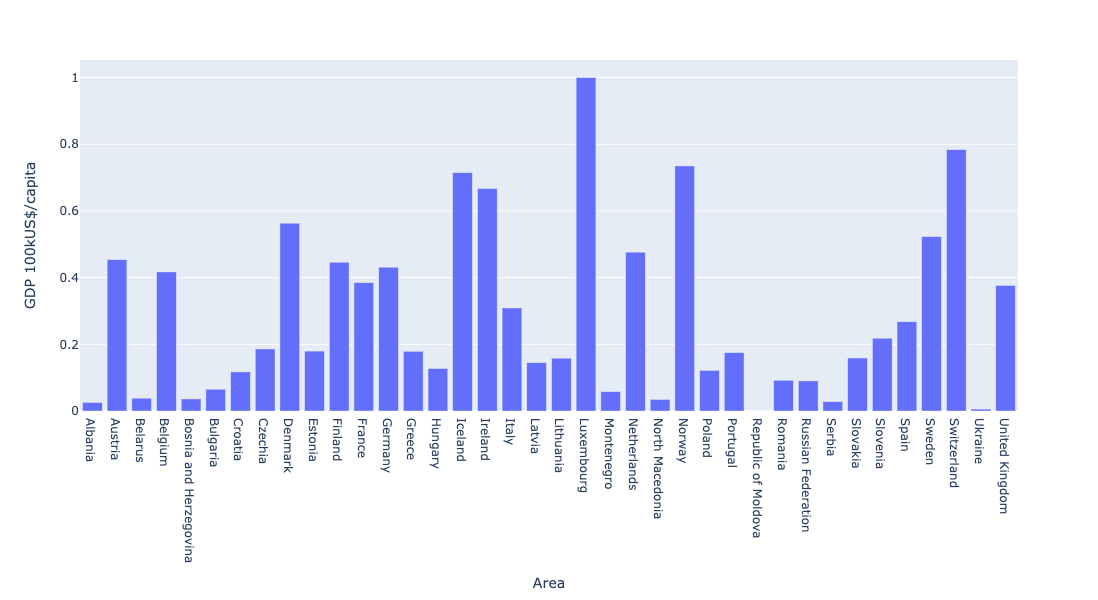

In [146]:
fig = px.bar(gdp_europe_capita_scaled.reset_index(), x='Area', y='GDP 100kUS$/capita')
fig.show()

We narrow down to the countries shown below in `best_countries`:

In [147]:
best_countries = ["Italy","France","Spain","United Kingdom","Germany"]

Let's see the scaled GDPs of our best countries:

In [148]:
gdp_europe_capita_scaled.loc[best_countries]

GDP 100kUS$/capita
Area                              
Italy                     0.308962
France                    0.384979
Spain                     0.267551
United Kingdom            0.376729
Germany                   0.431279

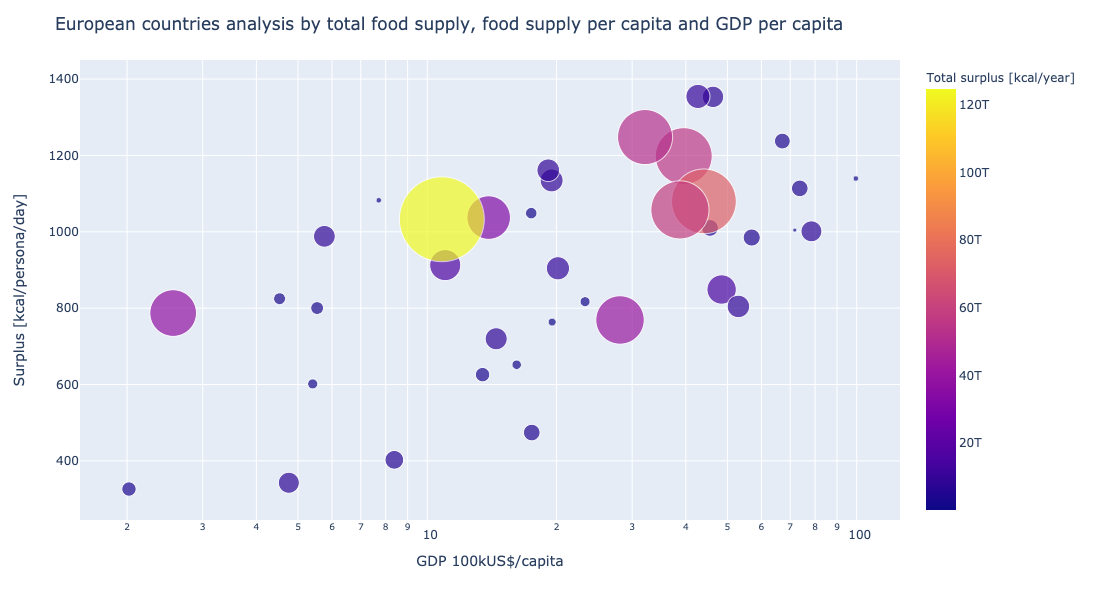

In [386]:
plot_df = pd.DataFrame(index= caloric_difference_europe.index)
plot_df["Total surplus [kcal/year]"] = total_cal_need_europe[2020]
plot_df["Surplus [kcal/persona/day]"] = caloric_difference_europe[2020]
plot_df["GDP 100kUS$/capita"] = gdp_capita["GDP 100kUS$/capita"]
plot_df = np.round(plot_df,2)
fig = px.scatter(plot_df, y="Surplus [kcal/persona/day]", x="GDP 100kUS$/capita", size="Total surplus [kcal/year]",\
                 color="Total surplus [kcal/year]", hover_name=plot_df.index, log_x=True, size_max=60)
fig.update_layout(
    title = "European countries analysis by total food supply, food supply per capita and GDP per capita",
    hoverlabel_align = 'right')
fig.show()

Create auxiliary dataframes to store the coefficients:
- `europe_plus_val` and `europe_plus_index` will store respectively the european surplus and the corresponding names of the countries
- `africa_deficit_val` and `africa_deficit_indx` will store respectively the african defict and the corresponding names of the countries
- `gdp_europe_val` and `gdp_europe_index` will store respectively the gwp normalized of european countries and the corresponding names of the countries

In [149]:
europe_plus_val = total_europe.loc[best_countries].astype(float).values
europe_plus_index = total_europe.loc[best_countries].index
africa_deficit_val= np.abs(af_real_deficit_tot.values).astype(float)
africa_deficit_index = af_real_deficit_tot.index
gdp_europe_val = gdp_europe_capita_scaled.loc[best_countries].astype(float).values
gdp_europe_index = gdp_europe_capita_scaled.loc[best_countries].index

According to the [documentation](https://picos-api.gitlab.io/picos/tutorial.html) of the library **PICOS** we adopted to solve the problem, **QUADRATIC PROGRAMS** can't be implemented yet. As a consequence, we will model the problem with a matlab function **QPSolverEuropeAfrica** that is located on the repository. It is possibile to run matlab functions on jupyter notebooks by importing **matlab.engine**. The function is then called and executed by a temporary matlab kernel created in the jupyter session.
In Matlab, it is possibile to use YALMIP which is a very useful translator of the problem to different solvers. We have an academic free license of GUROBI which is a quite famous solver and we will go for it.

In [150]:
import matlab.engine
euc = europe_plus_val; #european countries surplus matrix size 1xm
afc = africa_deficit_val; #african countries deficit matrix size 1xn
gwp = 1-gdp_europe_val; # gwp
#Casting to matlab variables
euc = matlab.double(euc.tolist())
afc = matlab.double(afc.tolist())
gwp = matlab.double(gwp.tolist())
#Start matlab engine
eng = matlab.engine.start_matlab()
#Initializing QPSolverEuropeAfrica that will store the outputs of the matlab function
QPSolverEuropeAfrica = eng.QPSolverEuropeAfrica(euc,afc,gwp,nargout=1)
#Quitting the matlab engine
eng.quit()

In [151]:
#PICKLE
#food_opt_distribution_df.to_pickle('data/processed/food_opt_distribution_df.pkl') #create pickle
food_opt_distribution_df = pd.read_pickle('data/processed/food_opt_distribution_df.pkl')

The optimization was successful. We will store them in the dataframe `food_opt_distribution_df`. Let's have a look at them:

In [152]:
food_opt_distribution =  np.round(np.asarray(QPSolverEuropeAfrica),4)
food_opt_distribution_df= pd.DataFrame(data=food_opt_distribution,index = europe_plus_index, columns=africa_deficit_index)
food_opt_distribution_df.head()

Ethiopia         Kenya  United Republic of Tanzania  \
Italy           3.309959e+12  1.377777e+12                 1.128190e+12   
France          3.719690e+12  1.548689e+12                 1.268253e+12   
Spain           3.122538e+12  1.299598e+12                 1.064122e+12   
United Kingdom  3.670387e+12  1.528123e+12                 1.251399e+12   
Germany         4.022919e+12  1.675176e+12                 1.371909e+12   

                  Madagascar        Zambia         Sudan        Uganda  \
Italy           1.025596e+12  7.923125e+11  6.504120e+11  5.984561e+11   
France          1.152979e+12  8.908609e+11  7.314214e+11  6.730436e+11   
Spain           9.673289e+11  7.472343e+11  6.133565e+11  5.643380e+11   
United Kingdom  1.137651e+12  8.790027e+11  7.216737e+11  6.640686e+11   
Germany         1.247251e+12  9.637936e+11  7.913740e+11  7.282437e+11   

                        Chad    Mozambique       Senegal  ...         Congo  \
Italy           5.279925e+11  4.332332e+11  3.844247e+11  ...  1.524224e+11   
France          5.938707e+11  4.873991e+11  4.325579e+11  ...  1.718800e+11   
Spain           4.978583e+11  4.084565e+11  3.624075e+11  ...  1.435221e+11   
United Kingdom  5.859437e+11  4.808814e+11  4.267661e+11  ...  1.695387e+11   
Germany         6.426252e+11  5.274857e+11  4.681798e+11  ...  1.862799e+11   

                Central African Republic       Liberia       Namibia  \
Italy                       1.343460e+11  7.543230e+10  6.563087e+10   
France                      1.515692e+11  8.537378e+10  7.436089e+10   
Spain                       1.264677e+11  7.088484e+10  6.163756e+10   
United Kingdom              1.494968e+11  8.417754e+10  7.331042e+10   
Germany                     1.643157e+11  9.273118e+10  8.082172e+10   

                        Togo      Botswana  Guinea-Bissau      Eswatini  \
Italy           6.366816e+10  3.657805e+10   3.001846e+10  2.303602e+10   
France          7.215559e+10  4.171712e+10   3.434677e+10  2.650129e+10   
Spain           5.978582e+10  3.422732e+10   2.803860e+10  2.145092e+10   
United Kingdom  7.113431e+10  4.109874e+10   3.382595e+10  2.608432e+10   
Germany         7.843688e+10  4.552040e+10   3.755002e+10  2.906583e+10   

                     Lesotho      Djibouti  
Italy           8.877370e+09  8.567958e+09  
France          1.059262e+10  1.024497e+10  
Spain           8.092775e+09  7.800856e+09  
United Kingdom  1.038623e+10  1.004317e+10  
Germany         1.186203e+10  1.148607e+10  

[5 rows x 25 columns]

Let's compute now the total amount that every European country has to give up to save Africa:

In [153]:
#summing over rows of optimal_distribution_df 
eu_countries_giveup = food_opt_distribution.sum(axis=1)
#storing results in a new dataframe eu_countries_giveup
eu_countries_giveup = pd.DataFrame({'Total giveup [kcal/year]': eu_countries_giveup}, index=best_countries)
eu_countries_giveup.head()

Total giveup [kcal/year]
Italy                       1.201073e+13
France                      1.351072e+13
Spain                       1.132461e+13
United Kingdom              1.333023e+13
Germany                     1.462081e+13

# Finding the right ingredients to provide

## 1) A first look inside the possible food

The following dataframe we obtained has nutritional information about the most varied food products there are. The information we are most interested in for our analysis. per product, are:
* **Food Group** - A generalized group in which the product is inserted
* **Food Name** - The name of the product itself
* **Protein (g)** - The amount of grams of proteins in a 100g serving
* **Carbohydrates (g)** - The amount of grams of carbohydrates in a 100g serving
* **Fat (g)** - The amount of grams of fat in a 100g serving

In [155]:
#load dataset USDA-Food
usda_foods = pd.read_excel("data/raw/USDA-Food.xlsx", sheet_name=0)
food_properties = pd.DataFrame(usda_foods[['Food Group', 'Food Name', 'Protein (g)', 'Carbohydrates (g)', 'Fat (g)']])
food_properties.head()

Food Group                   Food Name  Protein (g)  \
0  Dairy and Egg Products              Butter, salted         0.85   
1  Dairy and Egg Products  Butter, whipped, with salt         0.49   
2  Dairy and Egg Products       Butter oil, anhydrous         0.28   
3  Dairy and Egg Products                Cheese, blue        21.40   
4  Dairy and Egg Products               Cheese, brick        23.24   

   Carbohydrates (g)  Fat (g)  
0               0.06    81.11  
1               2.87    78.30  
2               0.00    99.48  
3               2.34    28.74  
4               2.79    29.68

In [156]:
#checking size of the database
food_properties.index.size

6347

There are a lot of possible product inside this database, but many of them could be unsuitable for our purpose. As for the first task, we check the available _'**Food Group'**_ and remove the ones we won't need.  
We plot them for a clear understanding.

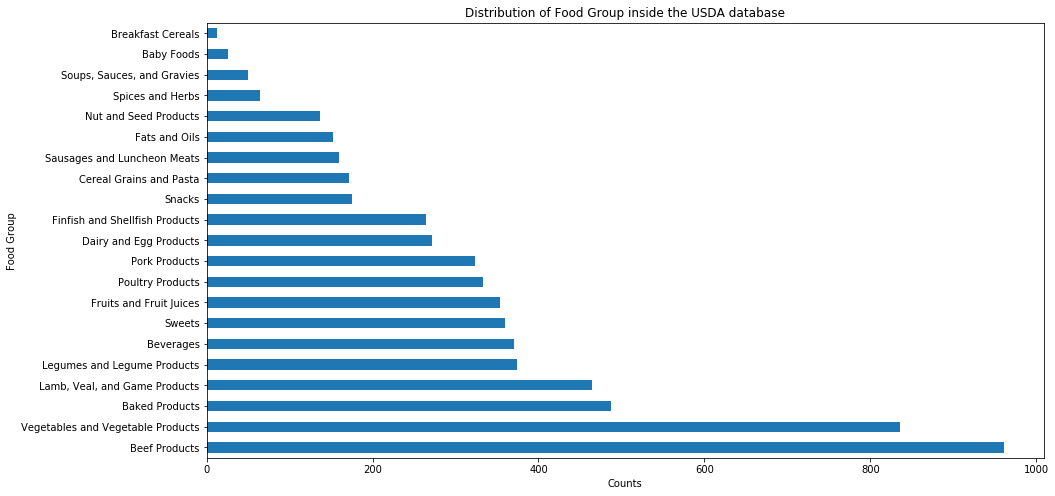

In [157]:
food_properties["Food Group"].value_counts().plot(kind="barh")
plt.title("Distribution of Food Group inside the USDA database")
plt.xlabel("Counts")
plt.ylabel("Food Group");

As expected, **not all most viable products are necessarily healthy. Also, other are not suitable for our purpose** (like, as example *"Baby Food"*). Therefore, we will no longer consider the following items:
- Sweets
- Beverages
- Snacks 
- Baked Products
- Spices and Herbs  
- Nut and Seed Products
- Dairy and Egg Products
- Breakfast Cereals
- Baby Foods
- Soups, Sauces, and Gravies
- Spices and Herbs
- Nut and Seed Products
- Fats and Oils

In [158]:
not_suit = ["Sweets","Snacks","Beverages", "Baked Products","Spices and Herbs", "Nut and Seed Products", \
            "Dairy and Egg Products", "Breakfast Cereals", "Baby Foods", "Soups, Sauces, and Gravies", \
           "Spices and Herbs", "Nut and Seed Products", "Fats and Oils"]
food_properties = food_properties[~food_properties["Food Group"].isin(not_suit)].reset_index(drop=True)
food_properties.head()

Food Group                                          Food Name  \
0  Poultry Products  Chicken, broiler, rotisserie, BBQ, breast meat...   
1  Poultry Products  Chicken, broilers or fryers, meat and skin and...   
2  Poultry Products  Chicken, broilers or fryers, meat and skin and...   
3  Poultry Products  Chicken, broilers or fryers, meat and skin and...   
4  Poultry Products  Chicken, broilers or fryers, meat and skin and...   

   Protein (g)  Carbohydrates (g)  Fat (g)  
0        28.04               0.00     3.57  
1        18.33               0.13    14.83  
2        22.84               9.03    17.53  
3        28.57               3.27    15.27  
4        26.78               0.06    13.27

New check on dimension:

In [159]:
food_properties.index.size

4240

By a first look to the head of the dataset we also understand that the `USDA-Food` contains many processed products. As we are interested in *raw* products for our analysis, we filter only this one:

In [160]:
food_properties = food_properties[food_properties["Food Name"].str.contains("raw")]
food_properties.index.size

1283

We have a set of **1283** products from which we have to choose the possible diet.  
We keep this dataset as it is for now and move to the next part.

## 2) Consider the producer prices
An important feature in our next choice of products will be **the cost of producing the products** inside the European countries. For this reason, we introduce now **two new datasets** and we use them to filter more the `USDA-Food` ones.  
The new datasets are:
- [EU_prices_for_representative](https://ec.europa.eu/info/food-farming-fisheries/farming/facts-and-figures/markets/prices/price-monitoring-sector/eu-prices-selected-representative-products_en) by the European Commission
- [FAO Producer prices](http://www.fao.org/faostat/en/#data/PP) (in particular we use the data for cereal and vegetables prices) 

We use the two of them because just the one from FAO is not complete enough for our purpose.  
*Note*: FAO data are from 2014 to 2018, while EU_prices will go from 2014 to 2019. We assume these prices to be ok even if they are from a different period because there are no available data online. We simply decide to pick the most recent price for each available product.

In [161]:
# loading the new datasets
eu_prices = pd.read_csv("data/raw/europe_food_prices.csv", usecols=["Category", "Product desc", "Unit", "Country", "Period", "MP Market Price"])\
            .rename(columns={"Product desc": "Product", "MP Market Price":"Price"})
eu_prices.head(1)

Category  Product                     Unit Country  Period   Price
0  Animal Products  Chicken  €/100 kg carcass weight      AT  201910  268.11

In order to have reasonable prices, we consider only the last five years, from 2014 to october 2019:

In [162]:
eu_prices = eu_prices[eu_prices.Period.between(201400, 201910)]

Check the availability inside this dataset:

In [163]:
eu_prices.Product.unique()

array(['Chicken', 'Raw Milk', 'SMP', 'WMP', 'Whey Powder', 'Butter',
       'Butter Oil', 'Emmental', 'Cheddar', 'Edam', 'Gouda', 'Apricots',
       'Avocados', 'Cherries', 'Lemons', 'Clementines', 'Strawberries',
       'Kiwis', 'Mandarins', 'Melons', 'Nectarines', 'Oranges',
       'Watermelons', 'Peaches', 'Pears', 'Apples Braeburn',
       'Apples Boskoop', 'Apples Cox', 'Apples Elstar', 'Apples Fuji',
       'Apples Gala', 'Apples Golden', 'Apples Granny', 'Apples Idared',
       'Apples Jonagold', 'Apples Red', 'Apples Shampion', 'Plums',
       'Grapes', 'Satsumas', 'Garlic', 'Asparagus', 'Eggplants',
       'Cabbages', 'Carrots', 'Mushrooms', 'Cauliflowers', 'Cucumbers',
       'Courgettes', 'Beans', 'Lettuces', 'Leeks', 'Onions', 'Peppers',
       'Tomatoes Cherry', 'Tomatoes Trusses', 'Tomatoes Round',
       'Feed Oats', 'Milling Oats', 'Feed Wheat', 'Bread Wheat',
       'Durum Wheat', 'Feed Maize', 'Malting Barley', 'Feed Barley',
       'Feed Rye', 'Bread Rye', 'Lampante 

There is a good number of representatives from all the categories we have in the `USDA-Food`, but we miss an important source of carbohydrates: rice. Also, there is no meat present in the database.  
For this reason, we go to scrape these information from FAO:

In [164]:
fao_prices = pd.read_csv("data/raw/fao_cereal_meat_prices_201418.csv", usecols=["Area", "Item", "Value", "Year"])
fao_prices

Area    Item  Year  Value
0            Albania  Barley  2014  431.4
1            Albania  Barley  2015  341.4
2            Albania  Barley  2016  319.7
3            Albania  Barley  2017  303.6
4            Albania  Barley  2018  302.2
...              ...     ...   ...    ...
1976  United Kingdom   Wheat  2014  256.7
1977  United Kingdom   Wheat  2015  189.4
1978  United Kingdom   Wheat  2016  162.0
1979  United Kingdom   Wheat  2017  158.3
1980  United Kingdom   Wheat  2018  218.8

[1981 rows x 4 columns]

*Note*: FAO data are in USD/ton 

At this point we need to restrict our product analysis. In the **_Which European countries can help Africa?_** section we defined the countries with the highest surplus in Europe, that are able to help Africa only by giving away a small fraction of their surplus.  
From the previous classification we remove now the *Russian Federation*, because it has a huge surplus and would be able to solve the African problem (and we want a fair share between the richest European countries), together with *Poland, Ukraine* and *Romania*, because they are smaller nations.  
At this point we have build the set of **top 5 countries that will help Africa: France, Italy, United Kingdom, Germany** and **Spain**.

In [165]:
# defining countries
best_countries = ["France", "Italy", "United Kingdom", "Germany", "Spain"]
best_countries_code = ["FR", "IT", "UK", "DE", "ES"] # codes for the eu_prices

# filtering our datasets
eu_prices = eu_prices[eu_prices.Country.isin(best_countries_code)]
fao_prices = fao_prices[fao_prices.Area.isin(best_countries)]

Considering only the most recent prices in the FAO cereal dataset

In [166]:
fao_prices = fao_prices.sort_values("Year", ascending=False).groupby(["Area", "Item"])\
                      .first().reset_index().drop(columns="Year")

Let's take a look to the products in the FAO **cereal** dataset now

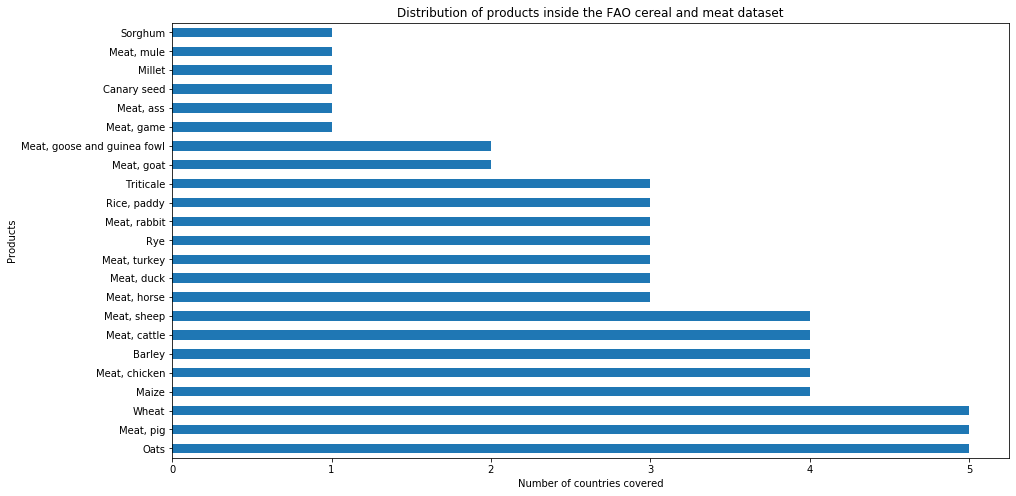

In [167]:
fao_prices.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO cereal and meat dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

Two fundamental problems emerge here: we don't have the price for rice and meat (**cattle**) in all the countries of interest, **we need to impute them**  
We start with the rice.  
In order to do so, what we do now is try to find a correlation between the product we have in **all the countries** (*Wheat* and *Oats*) and the rice.

In [168]:
rice_df = fao_prices[fao_prices.Item=="Rice, paddy"]
rice_df = rice_df.merge(fao_prices, on="Area")
rice_df = rice_df[rice_df.Item_y.str.contains("Wheat|Oats")]
rice_df["Coeff"] = rice_df.Value_x/rice_df.Value_y
rice_df.sort_values("Item_y")

Area       Item_x  Value_x Item_y  Value_y     Coeff
11  France  Rice, paddy    372.0   Oats    145.7  2.553191
19   Italy  Rice, paddy    403.7   Oats    272.3  1.482556
37   Spain  Rice, paddy    344.6   Oats    171.3  2.011675
15  France  Rice, paddy    372.0  Wheat    195.0  1.907692
21   Italy  Rice, paddy    403.7  Wheat    233.9  1.725951
42   Spain  Rice, paddy    344.6  Wheat    217.3  1.585826

In [169]:
mean_coeff_oats = rice_df[rice_df["Item_y"] == "Oats"].Coeff.mean()
mean_coeff_wheat = rice_df[rice_df["Item_y"] == "Wheat"].Coeff.mean()
print("The mean coefficient for oats is", mean_coeff_oats)
print("The mean coefficient for wheat is", mean_coeff_wheat)

The mean coefficient for oats is 2.0158076390008994
The mean coefficient for wheat is 1.7398232052849225


As the wheat seems to be the product with less fluctuation, we take this one for our imputation.

In [170]:
wheat_germany = fao_prices[(fao_prices.Area == "Germany") & (fao_prices.Item=="Wheat")].Value.values[0]
row_germ = pd.DataFrame(np.array([["Germany", "Rice, paddy", '%.1f'%(mean_coeff_wheat*wheat_germany)]]), columns=["Area", "Item", "Value"])
wheat_uk = fao_prices[(fao_prices.Area == "United Kingdom") & (fao_prices.Item=="Wheat")].Value.values[0]
row_uk = pd.DataFrame(np.array([["United Kingdom", "Rice, paddy", '%.1f'%(mean_coeff_wheat*wheat_uk)]]), columns=["Area", "Item", "Value"])
fao_prices = fao_prices.append(row_germ)
fao_prices = fao_prices.append(row_uk).reset_index(drop=True)

In [171]:
fao_prices[fao_prices.Item=="Barley"]

Area    Item  Value
0           France  Barley  195.1
16         Germany  Barley  195.4
39           Spain  Barley  203.7
60  United Kingdom  Barley  197.4

For the meat case, we first look to the countries for which we have data (considering the most general case: cattle, that we consider to be beef)

In [172]:
fao_prices[fao_prices.Item=="Meat, cattle"]

Area          Item   Value
2           France  Meat, cattle  4549.5
18         Germany  Meat, cattle  4033.1
43           Spain  Meat, cattle  2774.8
61  United Kingdom  Meat, cattle  5328.2

We need to impute the price for Italy:
- For Italy we can look [here](https://www.bordbia.ie/farmers-growers/farmers/prices-markets/eu-world-cattle-prices/?country=Italy). Taking a price average we have a price of 3.42€/kg

We need to multiply this price by **1.10** (actual exchange EUR/USD) and 1000 (to consider tons)

In [173]:
meat_italy = pd.DataFrame(np.array([["Italy", "Meat, cattle", '%.1f'%(3.42*1.10*1000)]]), columns=["Area", "Item", "Value"])
fao_prices = fao_prices.append(meat_italy).reset_index(drop=True)

For pork, we already have all the data so no need to impute.

Reprint the plot to see the final product in the FAO dataset:

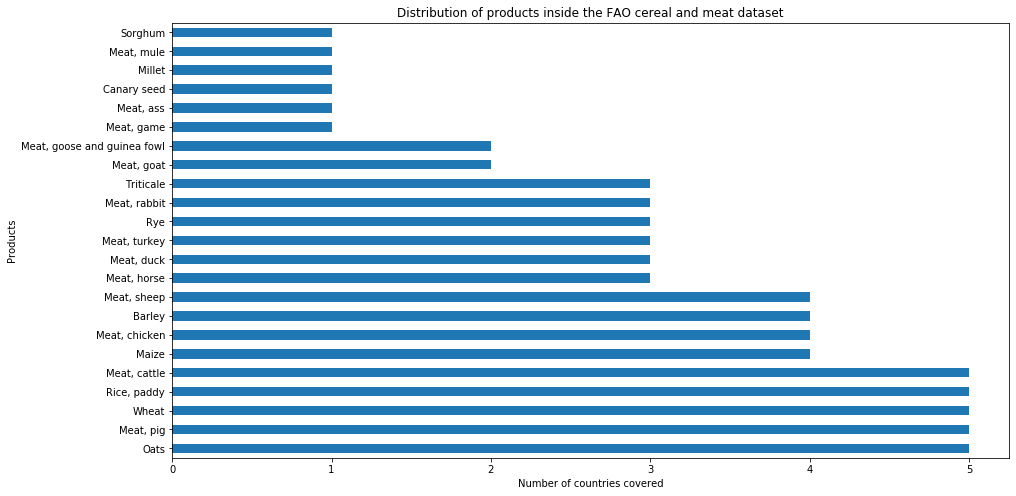

In [174]:
fao_prices.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO cereal and meat dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

We need to report all in a single unit in `eu_prices`

In [175]:
eu_prices.Unit.unique()

array(['€/100 kg carcass weight', '€/100 kg', '€/100 kg net weight',
       '€/t', '€/100 Kg'], dtype=object)

As we are working with large amount of data and FAO as data in USD/tons, we take everything as EUR/ton (multiply 10) and multiply by **1.10** (EUR/USD change)

In [176]:
eu_prices.loc[eu_prices['Unit'].str.contains('100'), 'Price'] = eu_prices.loc[eu_prices['Unit'].str.contains('100'), 'Price']\
                                                                .apply(lambda x: x*1.10*10)
eu_prices = eu_prices.drop(columns="Unit")

We now assess, as we did for the `fao_prices`, if the prices we have are correctly represented among all our countries.  
First step we do to this end is to keep only the most recent data for each product inside each country.

In [177]:
eu_prices = eu_prices.sort_values("Period", ascending=False).groupby(["Country", "Category", "Product"])\
                      .first().reset_index().drop(columns="Period")

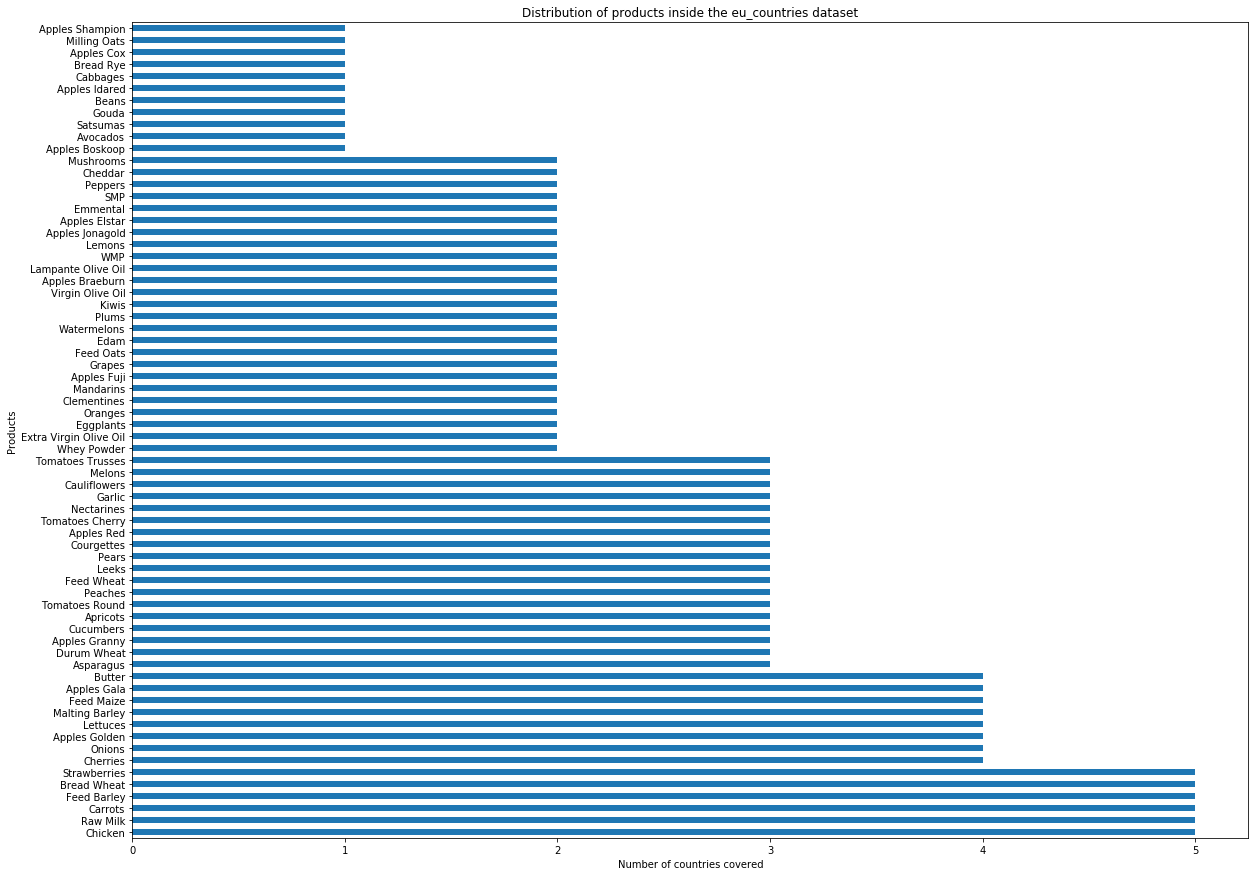

In [178]:
plt.figure(figsize=(20, 15))
eu_prices.Product.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the eu_countries dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

In [179]:
eu_prices.Product = eu_prices.Product.apply(lambda x: "Apples" if "Apples" in x else x)
eu_prices.Product = eu_prices.Product.apply(lambda x: "Tomatoes" if "Tomatoes" in x else x)
eu_prices.Product = eu_prices.Product.apply(lambda x: "Bread" if "Bread" in x else x)

In [180]:
# dropping and readd them
apples_eu = eu_prices[eu_prices.Product=="Apples"].groupby(["Country", "Category", "Product"]).agg("mean").reset_index()
eu_prices = eu_prices[~(eu_prices["Product"]=="Apples")].reset_index(drop=True)
tomatoes_eu = eu_prices[eu_prices.Product=="Tomatoes"].groupby(["Country", "Category", "Product"]).agg("mean").reset_index()
eu_prices = eu_prices[~(eu_prices["Product"]=="Tomatoes")].reset_index(drop=True)
bread_eu = eu_prices[eu_prices.Product=="Bread"].groupby(["Country", "Category", "Product"]).agg("mean").reset_index()
eu_prices = eu_prices[~(eu_prices["Product"]=="Bread")].reset_index(drop=True)
eu_prices = eu_prices.append(apples_eu)
eu_prices = eu_prices.append(tomatoes_eu)
eu_prices = eu_prices.append(bread_eu)

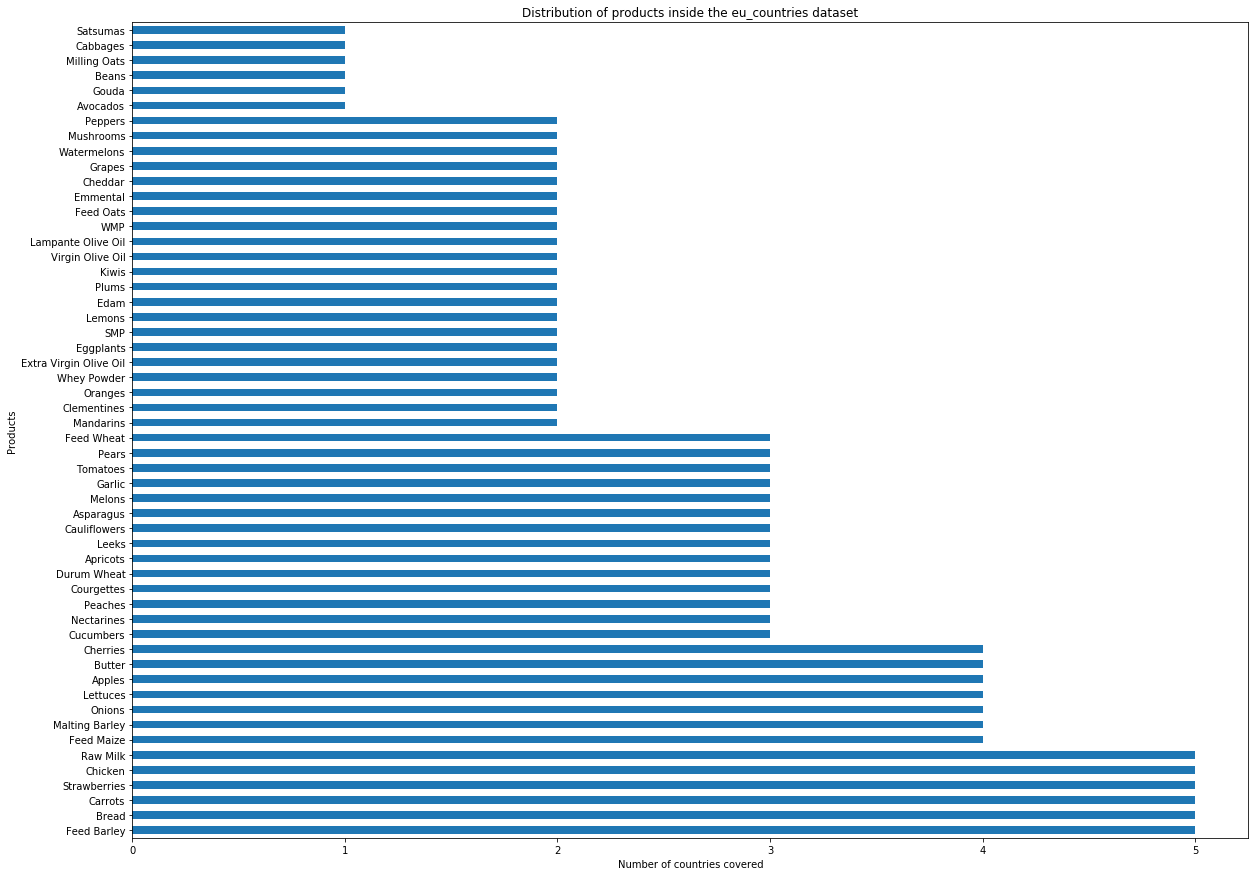

In [181]:
plt.figure(figsize=(20, 15))
eu_prices.Product.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the eu_countries dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

**Merging didn't solve the situation.**  
As a consequence, we decide to **drop all the products with not at least 4 counts** and put our *imputing efforts* just on them.

In [182]:
counts_eu = eu_prices.Product.value_counts()
possible_products = counts_eu[counts_eu >= len(best_countries) - 1].index
eu_prices = eu_prices[eu_prices.Product.isin(possible_products)]

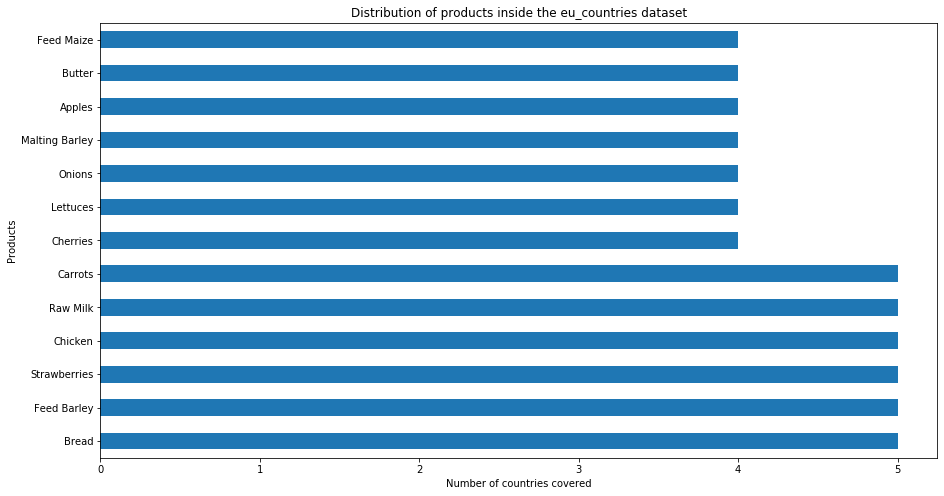

In [183]:
# replot to zoom on our interested products
eu_prices.Product.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the eu_countries dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

Printing the counts to understand which countries to impute. A country with all products should count **13 products**

In [184]:
eu_prices.Country.value_counts()

ES    13
IT    12
DE    12
FR    11
UK    10
Name: Country, dtype: int64

Only Spain has all the needed products. We need to impute all the others. We therefore proceed to print all the missing points in the other countries:

In [185]:
# set difference between the products
need_it = set(possible_products) - set(eu_prices[eu_prices.Country=="IT"].Product.values)
need_de = set(possible_products) - set(eu_prices[eu_prices.Country=="DE"].Product.values)
need_fr = set(possible_products) - set(eu_prices[eu_prices.Country=="FR"].Product.values)
need_uk = set(possible_products) - set(eu_prices[eu_prices.Country=="UK"].Product.values)

# printing
print("Missing product in Italy:", need_it)
print("Missing product in Germany:", need_de)
print("Missing product in France:", need_fr)
print("Missing product in United Kingdom:", need_uk)

Missing product in Italy: {'Malting Barley'}
Missing product in Germany: {'Onions'}
Missing product in France: {'Lettuces', 'Butter'}
Missing product in United Kingdom: {'Apples', 'Feed Maize', 'Cherries'}


#### Italy
We need to impute the **Malting Barley**. The actual italian price can be found [here](https://www.clal.it/en/index.php?section=conf_cereali#orzo), where the price (on the day of writing) is 189 EUR/ton. We multiply by 1.10 to have the price in USD.

In [186]:
barley_italy = pd.DataFrame(np.array([["IT", "Vegetal Products", "Malting Barley", '%.2f'%(189*1.10)]]), columns=["Country", "Category", "Product", "Price"])
eu_prices = eu_prices.append(barley_italy).reset_index(drop=True)

#### Germany
We need to impute the **Onions**. We can easily expect that onions won't be part of our diet, so we can drop them for all of the countries.

In [187]:
eu_prices = eu_prices[~(eu_prices.Product=="Onions")]

#### France
We need to impute **Lettuce** and **Butter**. For the second one, we can drop the aliment because it won't be part of the diet for sure. For the Lettuces, we can look at the FAO data directly from the [website](http://www.fao.org/faostat/en/#data/PP): 1296.3 in 2018

In [188]:
eu_prices = eu_prices[~(eu_prices.Product=="Butter")]
lettuce_france = pd.DataFrame(np.array([["FR", "Vegetable Products", "Lettuces", '%.2f'%(1269.3)]]), columns=["Country", "Category", "Product", "Price"])
eu_prices = eu_prices.append(lettuce_france).reset_index(drop=True)

In [189]:
eu_prices[(eu_prices.Product=="Feed Maize")]

Country          Category     Product   Price
7       DE  Vegetal Products  Feed Maize  161.88
16      ES  Vegetal Products  Feed Maize  170.38
24      FR  Vegetal Products  Feed Maize  153.65
33      IT  Vegetal Products  Feed Maize  149.64

#### United Kingdom
We need to impute **Apples**, **Cherries** and **Feed Maize**. For Apples and cherries we can use FAO data: 1343.4 and 4574.9 respectively. The price of Maize can be found [here](https://ahdb.org.uk/cereals-oilseeds-markets), 195\$ per ton.

In [190]:
apples_uk = pd.DataFrame(np.array([["UK", "Fruit Products", "Apples", '%.2f'%(1343.4)]]), columns=["Country", "Category", "Product", "Price"])
cherries_uk = pd.DataFrame(np.array([["UK", "Fruit Products", "Cherries", '%.2f'%(4574.9)]]), columns=["Country", "Category", "Product", "Price"])
maize_uk = pd.DataFrame(np.array([["UK", "Vegetal Products", "Feed Maize", '%.2f'%(195)]]), columns=["Country", "Category", "Product", "Price"])

eu_prices = eu_prices.append(apples_uk)
eu_prices = eu_prices.append(cherries_uk)
eu_prices = eu_prices.append(maize_uk).reset_index(drop=True)

Check if everything went right:

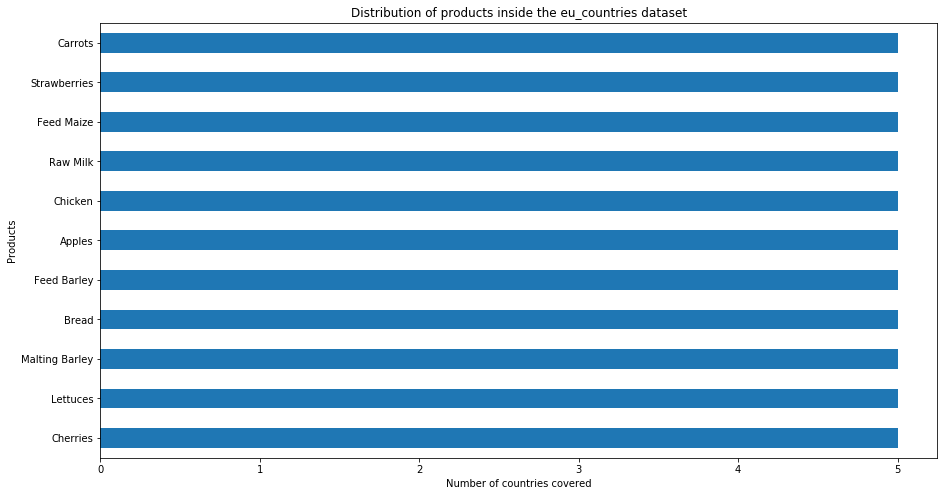

In [191]:
# replot to zoom on our interested products
eu_prices.Product.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the eu_countries dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

As we can see, the **Vegetables** category is not well represented by our actual dataset. For this reason, we consider **FAO data for vegetables** in order to fill the gaps:

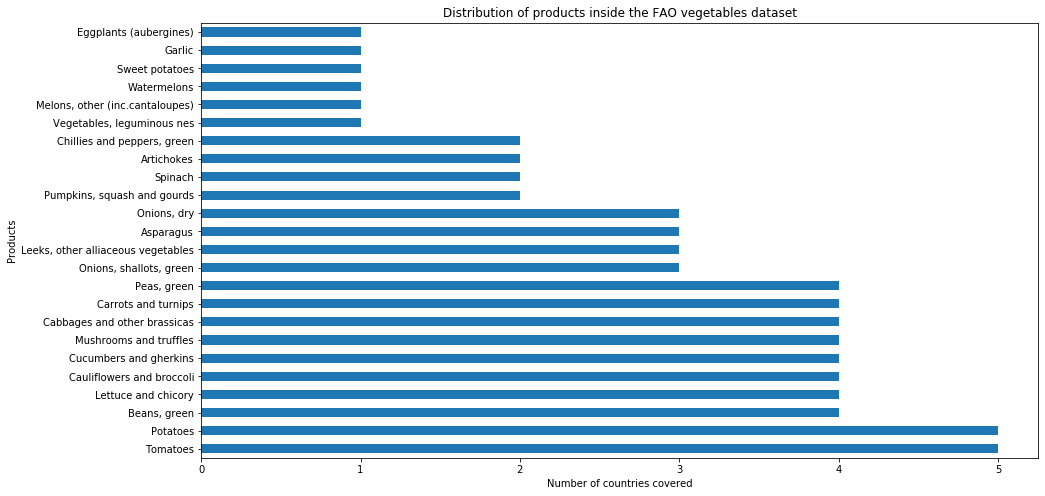

In [192]:
fao_vegetables_prc = pd.read_csv("data/raw/fao_vegetables_prices_201418.csv", usecols=["Area", "Item", "Value", "Year"])
fao_vegetables_prc = fao_vegetables_prc[fao_vegetables_prc.Area.isin(best_countries)]

fao_vegetables_prc = fao_vegetables_prc.sort_values("Year", ascending=False).groupby(["Area", "Item"])\
                      .first().reset_index().drop(columns="Year")

# plotting
fao_vegetables_prc.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO vegetables dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

As we did before, we take only the products present in at least **4 countries** for the next analysis:

In [193]:
counts_fao_veg = fao_vegetables_prc.Item.value_counts()
possible_products_veg = counts_fao_veg[counts_fao_veg >= len(best_countries) - 1].index
fao_vegetables_prc = fao_vegetables_prc[fao_vegetables_prc.Item.isin(possible_products_veg)]

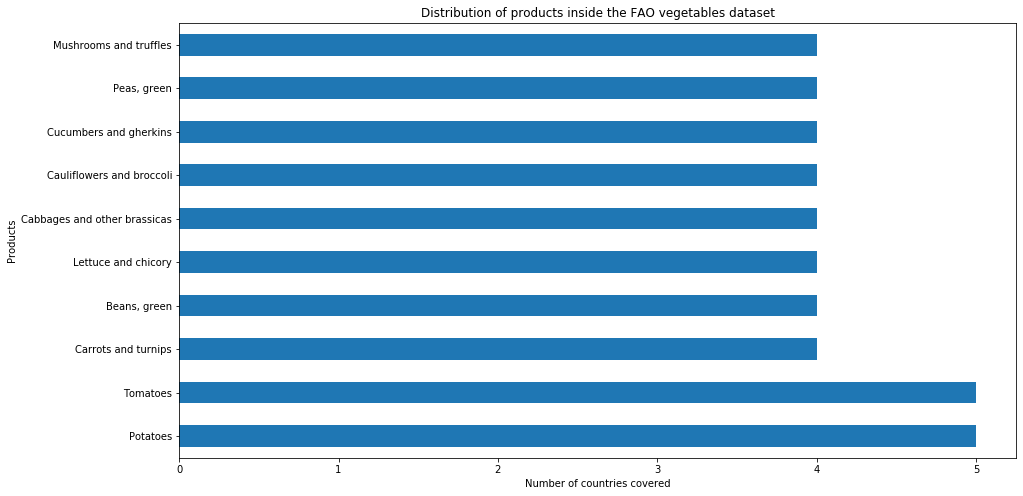

In [194]:
# replot to zoom on our interested products
fao_vegetables_prc.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO vegetables dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

We can also drop **Carrots** and **Lettuce** before already present in the precedent dataset:

In [195]:
fao_vegetables_prc = fao_vegetables_prc[~(fao_vegetables_prc.Item.isin(["Carrots and turnips", "Lettuce and chicory"]))]
possible_products_veg = possible_products_veg[~(possible_products_veg.isin(["Carrots and turnips", "Lettuce and chicory"]))]

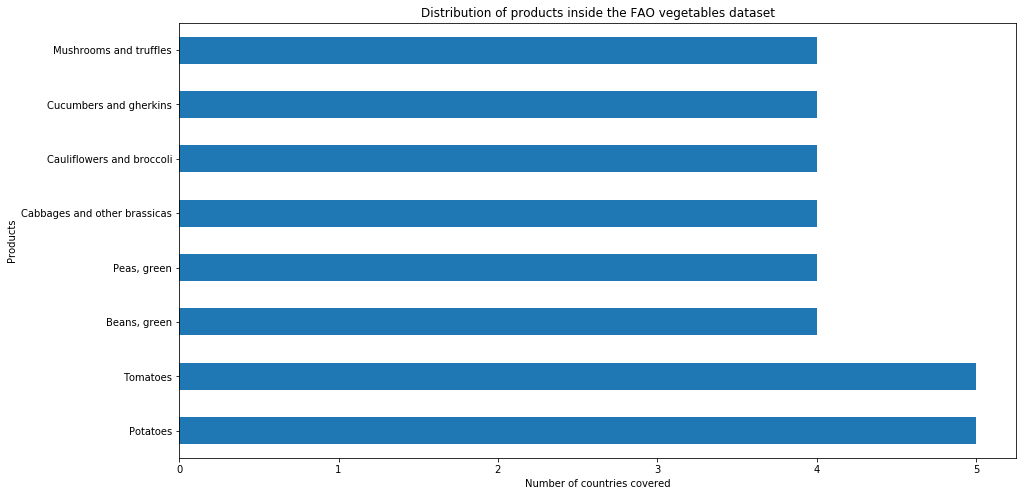

In [196]:
# replot to zoom on our interested products
fao_vegetables_prc.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO vegetables dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

Let's see how these products are represented:

In [197]:
fao_vegetables_prc.Area.value_counts()

Germany           8
France            8
United Kingdom    8
Spain             8
Italy             2
Name: Area, dtype: int64

The only country in which products are missing is **Italy**. We need to impute manually the prices of these products:

In [198]:
# set difference between the products
need_it = set(possible_products_veg) - set(fao_vegetables_prc[fao_vegetables_prc.Area=="Italy"].Item.values)

# printing
print("Missing product in Italy:", need_it)

Missing product in Italy: {'Mushrooms and truffles', 'Cauliflowers and broccoli', 'Cabbages and other brassicas', 'Peas, green', 'Beans, green', 'Cucumbers and gherkins'}


### Imputing Italy

The price for the **cucumbers** and the **cauliflowers** can be found in the `eu_prices` dataset

In [199]:
eu_prices2 = pd.read_csv("data/raw/europe_food_prices.csv", usecols=["Category", "Product desc", "Unit", "Country", "Period", "MP Market Price"])\
            .rename(columns={"Product desc": "Product", "MP Market Price":"Price"})
eu_prices2 = eu_prices2[eu_prices2.Country.isin(best_countries_code)]
eu_prices2 = eu_prices2[eu_prices2.Period.between(201400, 201910)]
eu_prices2 = eu_prices2.sort_values("Period", ascending=False).groupby(["Country", "Category", "Product"])\
                      .first().reset_index().drop(columns="Period")

In [200]:
eu_prices2[eu_prices2.Product=="Cucumbers"]

Country            Category    Product                 Unit   Price
63       ES  Vegetable Products  Cucumbers  €/100 kg net weight   49.81
101      FR  Vegetable Products  Cucumbers  €/100 kg net weight  114.55
144      IT  Vegetable Products  Cucumbers  €/100 kg net weight   68.00

In [201]:
eu_prices2[eu_prices2.Product=="Cauliflowers"]

Country            Category       Product                 Unit  Price
61       ES  Vegetable Products  Cauliflowers  €/100 kg net weight  25.20
99       FR  Vegetable Products  Cauliflowers  €/100 kg net weight  40.68
142      IT  Vegetable Products  Cauliflowers  €/100 kg net weight  62.71

In [202]:
#prices are in Eur/100 kg, we need usd/tonnes
cucumbers = pd.DataFrame(np.array([["Italy", "Cucumbers and gherkins", 68.00*1.10*10]]), columns=["Area", "Item", "Value"])
cauliflowers = pd.DataFrame(np.array([["Italy", "Cauliflowers and broccoli", 62.71*1.10*10]]), columns=["Area", "Item", "Value"])


fao_vegetables_prc = fao_vegetables_prc.append(cucumbers)
fao_vegetables_prc = fao_vegetables_prc.append(cauliflowers).reset_index(drop=True)

For the **peas** and the **beans** of 2017 in Italy can be found [here](http://www.codima.info/trunk/nor_file_107_decreto-ministeriale-n.-0031908-del-29-dicembre-2016-prezzi_parte_1-.pdf) (page in Italian).  
The price is **120.33€/100kg** for the peas and **175.56€/100kg** for the beans.

In [203]:
#prices are in Eur/100 kg, we need usd/tonnes
peas = pd.DataFrame(np.array([["Italy", "Peas, green", 120.33*1.10*10]]), columns=["Area", "Item", "Value"])
beans = pd.DataFrame(np.array([["Italy", "Beans, green", 175.56*1.10*10]]), columns=["Area", "Item", "Value"])


fao_vegetables_prc = fao_vegetables_prc.append(peas)
fao_vegetables_prc = fao_vegetables_prc.append(beans).reset_index(drop=True)

Unfortunately, we didn't find any reliable price for **Cabbages and mushrooms**, so we drop them:

In [204]:
fao_vegetables_prc = fao_vegetables_prc[~(fao_vegetables_prc.Item.isin(["Cabbages and other brassicas", "Mushrooms and truffles"]))]

Final check on these products

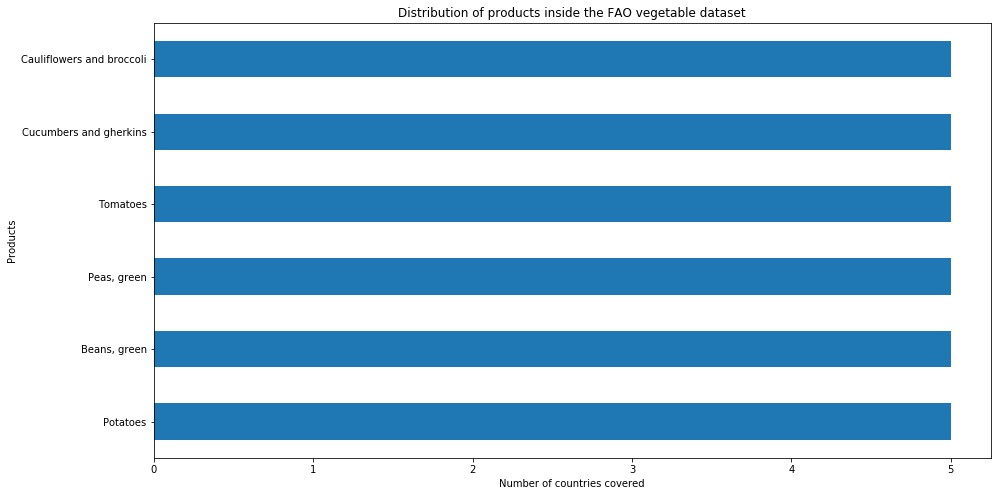

In [205]:
fao_vegetables_prc.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO vegetable dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

We also now rename the codes in  `eu_prices` to proper names of nations before merging.

In [206]:
dict_country = dict(zip(best_countries_code, best_countries))
eu_prices = eu_prices.replace({"Country":dict_country})

Final step is combining the three dataframe together. We modify the needed products from the FAO datasets and adapt it to `eu_prices`

In [207]:
counts_fao = fao_prices.Item.value_counts()
fao_products = counts_fao[counts_fao == len(best_countries)].index
fao_prices = fao_prices[fao_prices.Item.isin(fao_products)]

In [208]:
# dropping the no longer needed category column from eu
eu_prices.drop(columns="Category", inplace=True)

In [209]:
fao_prices = fao_prices.replace({"Item":{"Rice, paddy": "Rice", "Meat, cattle": "Meat"}})
fao_prices = fao_prices[["Area", "Item", "Value"]]
fao_prices = fao_prices.rename(columns={"Item": "Product", "Area":"Country", "Value":"Price"})
fao_vegetables_prc = fao_vegetables_prc.replace({"Item":{"Cauliflowers and broccoli": "Cauliflowers", "Peas, green": "Peas", "Beans, green": "Beans", "Cucumbers and gherkins": "Cucumbers"}})
fao_vegetables_prc = fao_vegetables_prc[["Area", "Item", "Value"]]
fao_vegetables_prc = fao_vegetables_prc.rename(columns={"Item": "Product", "Area":"Country", "Value":"Price"})
prices = eu_prices.append(fao_prices).append(fao_vegetables_prc).sort_values(by="Product").reset_index(drop=True)
prices.head()

Country Product    Price
0  United Kingdom  Apples  1343.40
1         Germany  Apples  597.443
2           Spain  Apples   898.04
3          France  Apples  1029.79
4           Italy  Apples  713.743

In [210]:
print("The final products present in the dataset are: {}".format(prices.Product.unique()))

The final products present in the dataset are: ['Apples' 'Beans' 'Bread' 'Carrots' 'Cauliflowers' 'Cherries' 'Chicken'
 'Cucumbers' 'Feed Barley' 'Feed Maize' 'Lettuces' 'Malting Barley' 'Meat'
 'Meat, pig' 'Oats' 'Peas' 'Potatoes' 'Raw Milk' 'Rice' 'Strawberries'
 'Tomatoes' 'Wheat']


We have finally build our **final prices dataset!**

## 3) Filtering the food dataset  
Now that we know the set of products between we can choose, it's time to filter the `USDA_food` accordingly

In [211]:
# defining the set of foods between we can choose
foods = prices.Product.unique()

In [212]:
food_properties[food_properties["Food Name"].str.contains('|'.join(foods), case=False)]

Food Group                                          Food Name  \
1     Poultry Products  Chicken, broilers or fryers, meat and skin and...   
6     Poultry Products    Chicken, broilers or fryers, meat and skin, raw   
11    Poultry Products        Chicken, broilers or fryers, meat only, raw   
15    Poultry Products        Chicken, broilers or fryers, skin only, raw   
20    Poultry Products          Chicken, broilers or fryers, giblets, raw   
...                ...                                                ...   
4052     Beef Products          Beef, ground, 95% lean meat / 5% fat, raw   
4057     Beef Products         Beef, ground, 90% lean meat / 10% fat, raw   
4062     Beef Products         Beef, ground, 85% lean meat / 15% fat, raw   
4067     Beef Products         Beef, ground, 80% lean meat / 20% fat, raw   
4072     Beef Products         Beef, ground, 75% lean meat / 25% fat, raw   

      Protein (g)  Carbohydrates (g)  Fat (g)  
1           18.33               0.13    14.83  
6           18.60               0.00    15.06  
11          21.39               0.00     3.08  
15          13.33               0.00    32.35  
20          17.88               1.80     4.47  
...           ...                ...      ...  
4052        21.41               0.00     5.00  
4057        20.00               0.00    10.00  
4062        18.59               0.00    15.00  
4067        17.17               0.00    20.00  
4072        15.76               0.00    25.00  

[269 rows x 5 columns]

269 rows, but there are multiple matches. Let's look to the elements that don't have a match:

In [213]:
# find the set of total foods and set to lower
total_foods = food_properties["Food Name"].unique()
total_foods = [t.lower() for t in total_foods]

# consider also foods to lower fo check the match
foods = [f.lower()for f in foods]

In [214]:
# find set of not matching
not_matching = [f for f in foods if not any(f in t for t in total_foods)]
len(not_matching)

10

In [215]:
not_matching

['cauliflowers',
 'cucumbers',
 'feed barley',
 'feed maize',
 'lettuces',
 'malting barley',
 'meat, pig',
 'oats',
 'raw milk',
 'wheat']

We can try to divide the multiple words, also remove duplicates after that

In [216]:
foods = [f.replace(",","").replace("(", "").replace(")", "").split() for f in foods]
foods = [l for sublist in foods for l in sublist]
foods = list(set(foods))

Second step is removing all generated stopwords and add singulars

In [217]:
stop_words = stopwords.words('english')
stop_words += ["feed", "raw"]
foods = [f for f in foods if f not in stop_words]
lem = WordNetLemmatizer()
singular = [lem.lemmatize(f) for f in foods]
foods += singular
foods = list(set(foods))
foods = [f for f in foods if f not in stop_words]

In [218]:
# printing the set of food
foods

['cauliflowers',
 'chicken',
 'lettuces',
 'beans',
 'carrots',
 'milk',
 'bread',
 'pea',
 'bean',
 'lettuce',
 'malting',
 'peas',
 'cherries',
 'pig',
 'potato',
 'meat',
 'potatoes',
 'maize',
 'tomatoes',
 'tomato',
 'wheat',
 'strawberry',
 'oats',
 'apples',
 'carrot',
 'cherry',
 'rice',
 'cucumber',
 'strawberries',
 'cauliflower',
 'oat',
 'apple',
 'cucumbers',
 'barley']

It's possible to note that _"meat"_ is too generic for our purpose, as we considered cow or beef in analyzing the prices. For this reason, we remove meat and add "cow" and "beef"

In [219]:
foods = [f for f in foods if f!="meat"]
foods += ["beef", "cow"]

New matching check:

In [220]:
food_properties[food_properties["Food Name"].str.contains('|'.join(foods), case=False)]

Food Group                                          Food Name  \
1     Poultry Products  Chicken, broilers or fryers, meat and skin and...   
6     Poultry Products    Chicken, broilers or fryers, meat and skin, raw   
11    Poultry Products        Chicken, broilers or fryers, meat only, raw   
15    Poultry Products        Chicken, broilers or fryers, skin only, raw   
20    Poultry Products          Chicken, broilers or fryers, giblets, raw   
...                ...                                                ...   
4142     Beef Products  Beef, round, tip round, roast, separable lean ...   
4145     Beef Products  Beef, flank, steak, separable lean only, trimm...   
4146     Beef Products  Beef, flank, steak, separable lean only, trimm...   
4147     Beef Products  Beef, brisket, flat half, separable lean and f...   
4148     Beef Products  Beef, brisket, flat half, separable lean and f...   

      Protein (g)  Carbohydrates (g)  Fat (g)  
1           18.33               0.13    14.83  
6           18.60               0.00    15.06  
11          21.39               0.00     3.08  
15          13.33               0.00    32.35  
20          17.88               1.80     4.47  
...           ...                ...      ...  
4142        21.38               0.00     3.35  
4145        21.57               0.00     5.47  
4146        21.43               0.00     5.00  
4147        18.12               0.12    22.15  
4148        17.77               0.00    22.21  

[602 rows x 5 columns]

We have a good set of products now, so we can stop here for the next considerations

In [221]:
poss_diet = food_properties[food_properties["Food Name"].str.contains('|'.join(foods), case=False)]

Check of our residue groups:

In [222]:
poss_diet["Food Group"].unique()

array(['Poultry Products', 'Fruits and Fruit Juices',
       'Vegetables and Vegetable Products', 'Beef Products',
       'Finfish and Shellfish Products', 'Legumes and Legume Products',
       'Lamb, Veal, and Game Products', 'Cereal Grains and Pasta'],
      dtype=object)

Fish products seems a bit strange for what we analyzed so far, check on it:

In [223]:
poss_diet[poss_diet["Food Group"] == "Finfish and Shellfish Products"]

Food Group                     Food Name  \
2312  Finfish and Shellfish Products  Fish, anchovy, european, raw   
2364  Finfish and Shellfish Products           Fish, milkfish, raw   
2437  Finfish and Shellfish Products   Fish, turbot, european, raw   

      Protein (g)  Carbohydrates (g)  Fat (g)  
2312        20.35                0.0     4.84  
2364        20.53                0.0     6.73  
2437        16.05                0.0     2.95

Finfish and Shellfish Products is not really represented by our prices database, so we drop the category

In [224]:
poss_diet = poss_diet[~poss_diet["Food Group"].isin(["Finfish and Shellfish Products"])].reset_index(drop=True)

Let's now adjust the units. The grams of proteins in 100g serve **[grams of proteins/100g]** times the kcalalories in 1 gram of proteins **[kcal/g of proteins]** will result in the kilocalories obtained from proteins for 100g serve **[kcal/100g]**. Same argument che be extended to carbohydrates and fat.  <br /> According to the [National Agriculture Library](https://www.nal.usda.gov/fnic/how-many-calories-are-one-gram-fat-carbohydrate-or-protein):
 - 1 gram of protein corresponds to **4 kcal**
 - 1 gram of carbohydrates corresponds to **4 kcal**
 - 1 gram of fat corresponds to **9 kcal**

According to what has been said above, we will multiply the values and obtain a new dataframe `diet_kcal` in which values have units of **[kcal/100g]**

In [225]:
#multiply values with vector of kcal/g, merging to keep Food 
kcal_g = np.array([4,4,9])
diet_kcal = poss_diet[["Food Group", "Food Name"]].merge(poss_diet[poss_diet.columns[2:]].multiply(kcal_g),left_index=True, right_index=True)
diet_kcal.rename(columns={'Protein (g)':'Protein (kcal/100g)',
                          'Carbohydrates (g)':'Carbohydrates (kcal/100g)',
                          'Fat (g)':'Fat (kcal/100g)'}, 
                 inplace=True)
diet_kcal.head()

Food Group                                          Food Name  \
0  Poultry Products  Chicken, broilers or fryers, meat and skin and...   
1  Poultry Products    Chicken, broilers or fryers, meat and skin, raw   
2  Poultry Products        Chicken, broilers or fryers, meat only, raw   
3  Poultry Products        Chicken, broilers or fryers, skin only, raw   
4  Poultry Products          Chicken, broilers or fryers, giblets, raw   

   Protein (kcal/100g)  Carbohydrates (kcal/100g)  Fat (kcal/100g)  
0                73.32                       0.52           133.47  
1                74.40                       0.00           135.54  
2                85.56                       0.00            27.72  
3                53.32                       0.00           291.15  
4                71.52                       7.20            40.23

The next point we are going to do now is trying to give a rank to each product taking into account the necessity that each person, in their diet, should have: 
* 55% from proteins
* 25% from carbohydrates 
* 20% from fats.
(Data adapted from [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1479724/))  
In order to do so, we apply a greedy ranking based on how well a particular food is is representing these shares.

In [226]:
def rank_food(food):
    prot = food['Protein (kcal/100g)']
    carb = food['Carbohydrates (kcal/100g)']
    fat = food['Fat (kcal/100g)']
    
    if (prot == 0 and carb == 0 and fat == 0):
        return -1
    
    tot = prot + carb + fat
    
    err_prot = abs(tot*0.55/4 - prot) / 100
    err_carb = abs(tot*0.25/4 - carb) / 100
    err_fat = abs(tot*0.20/9 - fat) / 100
    
    avg_err = (err_prot + err_carb + err_fat)/3
    
    return avg_err

In [227]:
diet_kcal['rank'] = diet_kcal.apply(rank_food, axis=1)

In the next step we take the best **3** out of each group (because there may be inconsistencies in the results due to the filtering process).  
From these, we then choose our **representative product for each group**. We will use this to compute the final diet in the next and final step.

In [228]:
diet_kcal.groupby(["Food Group"]).apply(lambda x: x.sort_values(['rank'])\
                                 .reset_index(drop=True).groupby("Food Group").head(3)).reset_index(drop=True)

Food Group  \
0                       Beef Products   
1                       Beef Products   
2                       Beef Products   
3             Cereal Grains and Pasta   
4             Cereal Grains and Pasta   
5             Cereal Grains and Pasta   
6             Fruits and Fruit Juices   
7             Fruits and Fruit Juices   
8             Fruits and Fruit Juices   
9       Lamb, Veal, and Game Products   
10      Lamb, Veal, and Game Products   
11      Lamb, Veal, and Game Products   
12        Legumes and Legume Products   
13        Legumes and Legume Products   
14        Legumes and Legume Products   
15                   Poultry Products   
16                   Poultry Products   
17                   Poultry Products   
18  Vegetables and Vegetable Products   
19  Vegetables and Vegetable Products   
20  Vegetables and Vegetable Products   

                                            Food Name  Protein (kcal/100g)  \
0   Beef, New Zealand, imported, variety meats and...                59.44   
1     Beef, variety meats and by-products, tripe, raw                48.28   
2   Beef, New Zealand, imported, variety meats and...                62.72   
3                                      Wild rice, raw                58.92   
4                                Barley, pearled, raw                39.64   
5                                       Oat bran, raw                69.20   
6                                    Rose-apples, raw                 2.40   
7                      Pitanga, (surinam-cherry), raw                 3.20   
8                                   Strawberries, raw                 2.68   
9        Lamb, New Zealand, imported, sweetbread, raw                44.00   
10                                          Goat, raw                82.40   
11         Game meat, beefalo, composite of cuts, raw                93.20   
12                  SILK Banana-Strawberry soy yogurt                 9.40   
13                         SILK Strawberry soy yogurt                 9.40   
14        Beans, kidney, all types, mature seeds, raw                94.32   
15                 Chicken, gizzard, all classes, raw                70.64   
16          Chicken, broilers or fryers, giblets, raw                71.52   
17      Chicken, roasting, light meat, meat only, raw                88.80   
18                              Cucumber, peeled, raw                 2.36   
19  Lettuce, butterhead (includes boston and bibb ...                 5.40   
20                             Lettuce, red leaf, raw                 5.32   

    Carbohydrates (kcal/100g)  Fat (kcal/100g)      rank  
0                        0.00            17.82  0.232495  
1                        0.00            33.21  0.245225  
2                        0.00            23.76  0.260241  
3                      299.60             9.72  0.954696  
4                      310.88            10.44  1.002436  
5                      264.88            63.27  1.030167  
6                       22.80             2.70  0.081908  
7                       29.96             3.60  0.107667  
8                       30.72             2.70  0.108818  
9                        0.00            28.44  0.217991  
10                       0.00            20.79  0.310525  
11                       0.00            43.20  0.410463  
12                      68.24            10.62  0.247061  
13                      72.96            10.62  0.263624  
14                     240.04             7.47  0.887067  
15                       0.00            18.54  0.268366  
16                       7.20            40.23  0.309951  
17                       0.00            14.67  0.311368  
18                       8.64             1.44  0.032252  
19                       8.92             1.98  0.042259  
20                       9.04             1.98  0.042363

Let's further analyze this results.  
We can start from the category that is less represented (2 results instead of 3): **Lamb, Veal, and Game Products**

In [229]:
diet_kcal[diet_kcal["Food Group"] == "Lamb, Veal, and Game Products"]

Food Group  \
298  Lamb, Veal, and Game Products   
299  Lamb, Veal, and Game Products   
300  Lamb, Veal, and Game Products   

                                        Food Name  Protein (kcal/100g)  \
298    Game meat, beefalo, composite of cuts, raw                 93.2   
299                                     Goat, raw                 82.4   
300  Lamb, New Zealand, imported, sweetbread, raw                 44.0   

     Carbohydrates (kcal/100g)  Fat (kcal/100g)      rank  
298                        0.0            43.20  0.410463  
299                        0.0            20.79  0.310525  
300                        0.0            28.44  0.217991

As we can see, this category doesn't really have a representation. The residue results are here just as consequence of the filtering process (using `str.contains` caused this).
**For this reason, we drop it**, than we increase the range of possible products from 3 to **5** and reprint.

In [230]:
diet_kcal = diet_kcal[~diet_kcal["Food Group"].isin(["Lamb, Veal, and Game Products"])].reset_index(drop=True)

In [231]:
diet_kcal.groupby(["Food Group"]).apply(lambda x: x.sort_values(['rank'])\
                                 .reset_index(drop=True).groupby("Food Group").head(5)).reset_index(drop=True)

Food Group  \
0                       Beef Products   
1                       Beef Products   
2                       Beef Products   
3                       Beef Products   
4                       Beef Products   
5             Cereal Grains and Pasta   
6             Cereal Grains and Pasta   
7             Cereal Grains and Pasta   
8             Cereal Grains and Pasta   
9             Cereal Grains and Pasta   
10            Fruits and Fruit Juices   
11            Fruits and Fruit Juices   
12            Fruits and Fruit Juices   
13            Fruits and Fruit Juices   
14            Fruits and Fruit Juices   
15        Legumes and Legume Products   
16        Legumes and Legume Products   
17        Legumes and Legume Products   
18        Legumes and Legume Products   
19        Legumes and Legume Products   
20                   Poultry Products   
21                   Poultry Products   
22                   Poultry Products   
23                   Poultry Products   
24                   Poultry Products   
25  Vegetables and Vegetable Products   
26  Vegetables and Vegetable Products   
27  Vegetables and Vegetable Products   
28  Vegetables and Vegetable Products   
29  Vegetables and Vegetable Products   

                                            Food Name  Protein (kcal/100g)  \
0   Beef, New Zealand, imported, variety meats and...                59.44   
1     Beef, variety meats and by-products, tripe, raw                48.28   
2   Beef, New Zealand, imported, variety meats and...                62.72   
3     Beef, variety meats and by-products, lungs, raw                64.80   
4   Beef, variety meats and by-products, kidneys, raw                69.60   
5                                      Wild rice, raw                58.92   
6                                Barley, pearled, raw                39.64   
7                                       Oat bran, raw                69.20   
8                      Rice, brown, medium-grain, raw                30.00   
9            Rice, white, medium-grain, raw, enriched                26.44   
10                                   Rose-apples, raw                 2.40   
11                     Pitanga, (surinam-cherry), raw                 3.20   
12                                  Strawberries, raw                 2.68   
13                 Acerola, (west indian cherry), raw                 1.60   
14                  Strawberries, frozen, unsweetened                 1.72   
15                  SILK Banana-Strawberry soy yogurt                 9.40   
16                         SILK Strawberry soy yogurt                 9.40   
17        Beans, kidney, all types, mature seeds, raw                94.32   
18  Lima beans, thin seeded (baby), mature seeds, raw                82.48   
19                    Beans, white, mature seeds, raw                93.44   
20                 Chicken, gizzard, all classes, raw                70.64   
21          Chicken, broilers or fryers, giblets, raw                71.52   
22      Chicken, roasting, light meat, meat only, raw                88.80   
23                  Chicken, roasting, meat only, raw                81.32   
24  Chicken, dark meat, drumstick, meat only, with...                76.76   
25                              Cucumber, peeled, raw                 2.36   
26  Lettuce, butterhead (includes boston and bibb ...                 5.40   
27                             Lettuce, red leaf, raw                 5.32   
28   Lettuce, iceberg (includes crisphead types), raw                 3.60   
29                           Cucumber, with peel, raw                 2.60   

    Carbohydrates (kcal/100g)  Fat (kcal/100g)      rank  
0                        0.00            17.82  0.232495  
1                        0.00            33.21  0.245225  
2                        0.00            23.76  0.260241  
3                        0.00            22.50  0.262708  
4                        1.16            

Now the shape of our final diet is **way more clear**:
- From the _**Beef Products**_ category we have a great variety of meats. We can take **the median over the first 10 rows** to have our representative beef nutrients.
- From the _**Cereal Grains and Pasta**_ group, a good product would be one of **rice, bearley** or **oat**. We keep all of them for now. Further analysis will be in the next section.
- From the _**Fruits and Fruit Juices**_ category, we take the **Strawberries** and **Apples** (not rose-apples as shown here but apples, as there are some in the dataframe). The other products are probably shown due to some inconsistence with the food items presented before.
- From **_Poultry Products_**, we take **Chicken, roasting, light meat, meat only, raw** as it's the most simple one.
- For the _**Legumes and Legume Products**_ and _**Vegetables and Vegetable Products**_, we need further analysis (because these two categories can be very useful for our analysis):
    - From _**Legumes and Legume Products**_ we go for sure for **Beans**, but the yogurt there presented is an inconsistency. Therefore, we need further explorations.
    - From _**Vegetables and Vegetable Products**_ we could take **Lettuce, green leaf, raw** and **cucumber**. We should analyze if there's the possibility to take other products.

We can now build the **final dataframe** with nutrient for each product.

In [232]:
prod_diet_final = pd.DataFrame(columns=["Product", "Protein (kcal/100g)", "Carbohydrates (kcal/100g)","Fat (kcal/100g)"])

#### Beef Products

In [233]:
# taking an average over the first 5 beef product
best_beef = diet_kcal[diet_kcal["Food Group"]=="Beef Products"].sort_values(by="rank").head(10)
beef_repr = [best_beef["Protein (kcal/100g)"].median(),\
             best_beef["Carbohydrates (kcal/100g)"].median(),\
             best_beef["Fat (kcal/100g)"].median()]
beef_list = ["Beef Meat"] + beef_repr
beef = pd.DataFrame(np.array([beef_list]), columns=["Product", "Protein (kcal/100g)", "Carbohydrates (kcal/100g)","Fat (kcal/100g)"])
prod_diet_final = prod_diet_final.append(beef)

#### Cereal Grains and Pasta

In [234]:
# taking the top 3 in cereals (rice, bearley, oat)
best_cereal = diet_kcal[diet_kcal["Food Group"]=="Cereal Grains and Pasta"].sort_values(by="rank").head(3)
best_cereal = best_cereal.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
best_cereal = best_cereal.replace({"Product":{"Wild rice, raw": "Rice", "Barley, pearled, raw": "Barley", "Oat bran, raw": "Oats"}})
prod_diet_final = prod_diet_final.append(best_cereal)

#### Fruits and Fruit Juices
By further analysis, we discovered that it's possible to add also **cherries** to the possible diet. So we keep those too.

In [235]:
# taking apples, cherries and strawberries 
fruits = diet_kcal[(diet_kcal["Food Name"]=="Apples, raw, with skin") | (diet_kcal["Food Name"]=="Strawberries, raw") | (diet_kcal["Food Name"]=="Cherries, sour, red, raw")]
fruits = fruits.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
fruits = fruits.replace({"Product":{"Apples, raw, with skin": "Apples", "Cherries, sour, red, raw": "Cherries", "Strawberries, raw": "Strawberries"}})
prod_diet_final = prod_diet_final.append(fruits)

#### Poultry Products

In [236]:
# just take Chicken, roasting, light meat, meat only, raw
poultry = diet_kcal[diet_kcal["Food Name"]=="Chicken, roasting, light meat, meat only, raw"]
poultry = poultry.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
poultry = poultry.replace({"Product":{"Chicken, roasting, light meat, meat only, raw": "Chicken"}})
prod_diet_final = prod_diet_final.append(poultry)

#### Legumes and Legume Products

In [237]:
check_leg = diet_kcal[diet_kcal["Food Group"]=="Legumes and Legume Products"]
check_leg[check_leg["Food Name"].str.contains("bean", case=False)].head(5)

Food Group                                    Food Name  \
261  Legumes and Legume Products             Beans, adzuki, mature seeds, raw   
262  Legumes and Legume Products              Beans, black, mature seeds, raw   
263  Legumes and Legume Products       Beans, black turtle, mature seeds, raw   
264  Legumes and Legume Products  Beans, cranberry (roman), mature seeds, raw   
265  Legumes and Legume Products             Beans, french, mature seeds, raw   

     Protein (kcal/100g)  Carbohydrates (kcal/100g)  Fat (kcal/100g)      rank  
261                79.48                     251.60             4.77  0.888678  
262                86.40                     249.44            12.78  0.903830  
263                85.00                     253.00             8.10  0.897296  
264                92.12                     240.20            11.07  0.890270  
265                75.24                     256.44            18.18  0.907044

In [238]:
check_leg[check_leg["Food Name"].str.contains("pea", case=False)].head(5)

Food Group  \
278  Legumes and Legume Products   
279  Legumes and Legume Products   
280  Legumes and Legume Products   
287  Legumes and Legume Products   
288  Legumes and Legume Products   

                                             Food Name  Protein (kcal/100g)  \
278  Chickpeas (garbanzo beans, bengal gram), matur...                81.88   
279                Cowpeas, catjang, mature seeds, raw                95.40   
280  Cowpeas, common (blackeyes, crowder, southern)...                94.08   
287              Peas, green, split, mature seeds, raw                95.28   
288                            Peanuts, all types, raw               103.20   

     Carbohydrates (kcal/100g)  Fat (kcal/100g)      rank  
278                     251.80            54.36  1.006030  
279                     238.56            18.63  0.914122  
280                     240.12            11.34  0.895844  
287                     254.96            10.44  0.935096  
288                      64.52           443.16  1.583763

As we can see, we have both the product we mentioned before. As **only 2 types of legumes** were chosen, because their **nutriments provision is usually high**, we decide to keep both of them for our next analysis.

In [239]:
# Taking one for beans and one for peas
beans = diet_kcal[diet_kcal["Food Name"]=="Beans, adzuki, mature seeds, raw"]
beans = beans.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
beans = beans.replace({"Product":{"Beans, adzuki, mature seeds, raw": "Beans"}})

peas = diet_kcal[diet_kcal["Food Name"]=="Peas, green, split, mature seeds, raw"]
peas = peas.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
peas = peas.replace({"Product":{"Peas, green, split, mature seeds, raw": "Peas"}})

prod_diet_final = prod_diet_final.append(beans)
prod_diet_final = prod_diet_final.append(peas)

#### Vegetables and Vegetable Products

In [240]:
diet_kcal[diet_kcal["Food Group"]=="Vegetables and Vegetable Products"].sort_values(by="rank").head(10)

Food Group  \
104  Vegetables and Vegetable Products   
107  Vegetables and Vegetable Products   
111  Vegetables and Vegetable Products   
109  Vegetables and Vegetable Products   
103  Vegetables and Vegetable Products   
133  Vegetables and Vegetable Products   
110  Vegetables and Vegetable Products   
132  Vegetables and Vegetable Products   
90   Vegetables and Vegetable Products   
108  Vegetables and Vegetable Products   

                                             Food Name  Protein (kcal/100g)  \
104                              Cucumber, peeled, raw                 2.36   
107  Lettuce, butterhead (includes boston and bibb ...                 5.40   
111                             Lettuce, red leaf, raw                 5.32   
109   Lettuce, iceberg (includes crisphead types), raw                 3.60   
103                           Cucumber, with peel, raw                 2.60   
133                              Tomatoes, yellow, raw                 3.92   
110                           Lettuce, green leaf, raw                 5.44   
132                              Tomatoes, orange, raw                 4.64   
90               Balsam-pear (bitter gourd), pods, raw                 4.00   
108                       Lettuce, cos or romaine, raw                 4.92   

     Carbohydrates (kcal/100g)  Fat (kcal/100g)      rank  
104                       8.64             1.44  0.032252  
107                       8.92             1.98  0.042259  
111                       9.04             1.98  0.042363  
109                      11.88             1.26  0.043400  
103                      14.52             0.99  0.046952  
133                      11.92             2.34  0.047133  
110                      11.48             1.35  0.047367  
132                      12.72             1.71  0.049441  
90                       14.80             1.53  0.052707  
108                      13.16             2.70  0.053874

As we can see, the list of most viable **10 vegetables** includes **Lettuce, cucumber and tomatoes** (different kinds for the latter).  
We decide to take the three (we search for the red one in the case of tomatoes, as it is the most common).

In [241]:
# take Lettuce, green leaf, raw and Cucumber
lettuce = diet_kcal[diet_kcal["Food Name"]=="Lettuce, green leaf, raw"]
lettuce = lettuce.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
lettuce = lettuce.replace({"Product":{"Lettuce, green leaf, raw": "Lettuces"}})

cucumber = diet_kcal[diet_kcal["Food Name"]=="Cucumber, peeled, raw"]
cucumber = cucumber.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
cucumber = cucumber.replace({"Product":{"Cucumber, peeled, raw": "Cucumbers"}})

prod_diet_final = prod_diet_final.append(lettuce)
prod_diet_final = prod_diet_final.append(cucumber)

In [242]:
#average over tomatoes
tomatoes = diet_kcal[diet_kcal["Food Name"].str.contains("tomatoe", case=False)]
tomatoes

Food Group  \
125  Vegetables and Vegetable Products   
126  Vegetables and Vegetable Products   
132  Vegetables and Vegetable Products   
133  Vegetables and Vegetable Products   

                                        Food Name  Protein (kcal/100g)  \
125                          Tomatoes, green, raw                 4.80   
126  Tomatoes, red, ripe, raw, year round average                 3.52   
132                         Tomatoes, orange, raw                 4.64   
133                         Tomatoes, yellow, raw                 3.92   

     Carbohydrates (kcal/100g)  Fat (kcal/100g)      rank  
125                      20.40             1.80  0.070000  
126                      15.56             1.80  0.054133  
132                      12.72             1.71  0.049441  
133                      11.92             2.34  0.047133

Found the name for the red tomatoe. Add it to the dataset:

In [243]:
tomatoes = diet_kcal[diet_kcal["Food Name"]=="Tomatoes, red, ripe, raw, year round average"]
tomatoes = tomatoes.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
tomatoes = tomatoes.replace({"Product":{"Tomatoes, red, ripe, raw, year round average": "Tomatoes"}})

prod_diet_final = prod_diet_final.append(tomatoes).reset_index(drop=True).set_index("Product")

We can finally look at **our final diet dataframe** `prod_diet_final`. This dataframe will be used in the next section to build an optimal diet **based on the production prices**

In [244]:
prod_diet_final

Protein (kcal/100g) Carbohydrates (kcal/100g) Fat (kcal/100g)
Product                                                                   
Beef Meat                  70.24                       0.0           28.98
Rice                       58.92                     299.6            9.72
Barley                     39.64                    310.88           10.44
Oats                        69.2                    264.88           63.27
Apples                      1.04                     55.24            1.53
Cherries                       4                     48.72             2.7
Strawberries                2.68                     30.72             2.7
Chicken                     88.8                         0           14.67
Beans                      79.48                     251.6            4.77
Peas                       95.28                    254.96           10.44
Lettuces                    5.44                     11.48            1.35
Cucumbers                   2.36                      8.64            1.44
Tomatoes                    3.52                     15.56             1.8

In [245]:
# making sure all the values are float
prod_diet_final["Protein (kcal/100g)"] = prod_diet_final["Protein (kcal/100g)"].astype(float)
prod_diet_final["Carbohydrates (kcal/100g)"] = prod_diet_final["Carbohydrates (kcal/100g)"].astype(float)
prod_diet_final["Fat (kcal/100g)"] = prod_diet_final["Fat (kcal/100g)"].astype(float)

Saving the result into a pickle:

In [246]:
prod_diet_final.to_pickle("data/processed/prod_diet_final.pkl")

Plotting the results:

In [247]:
#Creating an exploded version of prod_diet_final 
plot_diet_exploxed = prod_diet_final.copy()
#Resetting index
plot_diet_exploxed.reset_index()
#Unstack result, converting to dataframe and reset index
plot_diet_exploxed = plot_diet_exploxed.unstack().to_frame().reset_index(level=['Product',0])
#Casting values column to float
#plot_diet_exploxed[0]= plot_diet_exploxed[0].astype(float)
#renaming columns
plot_diet_exploxed = plot_diet_exploxed.rename(columns={"level_0":"Macronutrient",0:"Value"})
#showing results
plot_diet_exploxed.head()

Macronutrient    Product  Value
0  Protein (kcal/100g)  Beef Meat  70.24
1  Protein (kcal/100g)       Rice  58.92
2  Protein (kcal/100g)     Barley  39.64
3  Protein (kcal/100g)       Oats  69.20
4  Protein (kcal/100g)     Apples   1.04

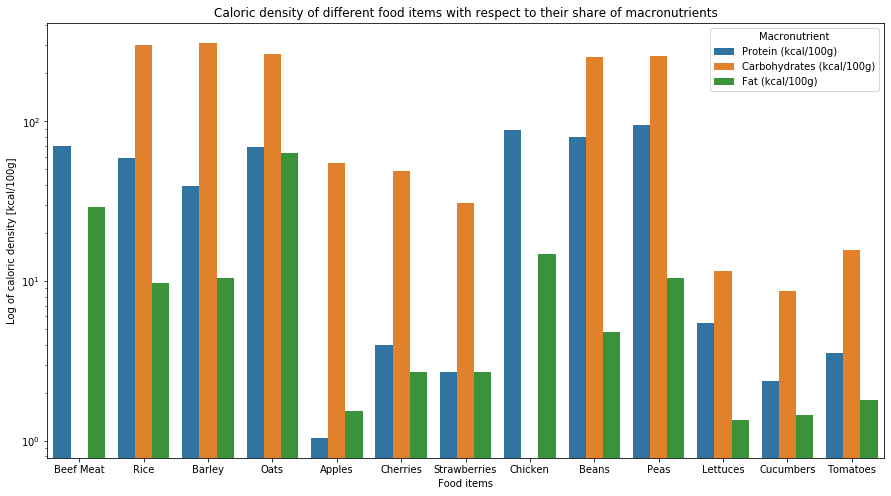

In [248]:
#Initialize bar plot 
bp = sns.barplot(x='Product', y="Value", hue='Macronutrient', data=plot_diet_exploxed)
#Set log axis in order to show more values since with have both big numbers and very small numbers
bp.set(yscale="log") 
plt.ylabel('Log of caloric density [kcal/100g]')
plt.xlabel('Food items')
plt.title('Caloric density of different food items with respect to their share of macronutrients');

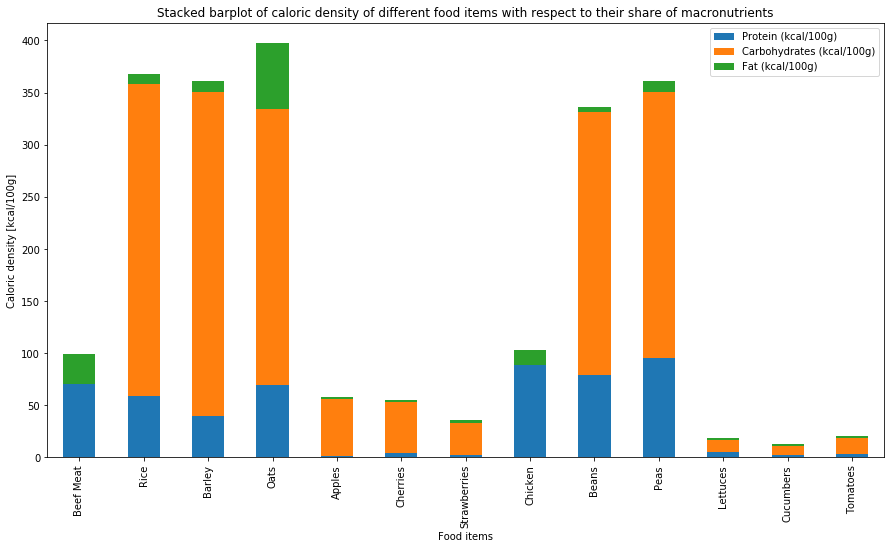

In [249]:
prod_diet_final.plot(kind='bar',stacked=True)
plt.ylabel('Caloric density [kcal/100g]')
plt.xlabel('Food items')
plt.title('Stacked barplot of caloric density of different food items with respect to their share of macronutrients');

In [318]:
#fig = px.scatter_3d(prod_diet_final, x='Protein (kcal/100g)', y='Carbohydrates (kcal/100g)', z='Fat (kcal/100g)')
#fig.show()


import plotly.graph_objects as go



t = np.linspace(0, 20, 13)

fig = go.Figure(data=[go.Scatter3d(
    text=prod_diet_final.index.values,
    x=prod_diet_final["Protein (kcal/100g)"],
    y=prod_diet_final["Carbohydrates (kcal/100g)"],
    z=prod_diet_final["Fat (kcal/100g)"],
    hoverinfo=["text","x" ,"y","z"],
    mode="markers",
    marker=dict(
        size=8,
        color=t,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])


camera = dict(
    eye=dict(x=-1.4, y=-1.4, z=0.1)
)

name = 'Shares of macronutrients in each food item"'

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene_camera=camera, title=name)

## 4) Final filter on the prices to retain only the needed ones
We need now to prepare the prices matrix for the next section. In order to do so, we filter the product we have in the `prices` dataframe accordingly with what we have delined in the last part.  
Theoretically, we should have **65 elements** in the final dataframe (5 countries, 13 products)

In [251]:
# a conversion in float for all the prices just to be sure
prices.Price = prices.Price.apply(lambda x: float(x))

In [252]:
prices_final = prices[prices.Product.isin(prod_diet_final.index.values)]
prices_final.index.size

55

We miss **2** products. We must investigate over those:

In [253]:
print("Set of missing product in prices:", set(prod_diet_final.index.values) - set(prices_final.Product.unique()))

Set of missing product in prices: {'Barley', 'Beef Meat'}


Probably these products have another name in the previous dataframe (as example, _"Beef Meat"_ was set as _"Meat"_ by us).  
We look into these problems and manually solve them

In [254]:
# check for Meat
prices[prices.Product.str.contains("Meat")]

Country    Product   Price
60          France       Meat  4549.5
61         Germany       Meat  4033.1
62           Italy       Meat  3762.0
63  United Kingdom       Meat  5328.2
64           Spain       Meat  2774.8
65           Spain  Meat, pig  1350.8
66         Germany  Meat, pig  1685.6
67           Italy  Meat, pig  2844.8
68  United Kingdom  Meat, pig  1983.0
69          France  Meat, pig  1469.0

As expected, we have _"Meat"_ instead of _"Beef Meat"_. Fixing it:

In [255]:
prices = prices.replace({"Product":{"Meat": "Beef Meat"}})

In [256]:
# check for Barley
prices[prices.Product.str.contains("Barley")]

Country         Product   Price
40           Italy     Feed Barley  172.92
41         Germany     Feed Barley  156.54
42  United Kingdom     Feed Barley  155.11
43           Spain     Feed Barley  175.67
44          France     Feed Barley  171.22
55          France  Malting Barley  195.27
56         Germany  Malting Barley  209.30
57           Spain  Malting Barley  180.00
58           Italy  Malting Barley  207.90
59  United Kingdom  Malting Barley  177.60

For this case, we have _"Feed Barley"_ and _"Malting Barley"_ from which choose. As we don't know from which kind of barley is derived the one we are considering in the `USDA_food` we decide to take an **average** between the two prices

In [257]:
barleys = prices[prices.Product.str.contains("Barley")]
barleys = barleys.groupby(["Country"]).mean().reset_index()
barleys["Product"] = "Barley"
barleys = barleys[["Country", "Product", "Price"]]
prices = prices.append(barleys)

After the final fix, we can now print the **`prices_final` dataframe** for the prices for our interesting product for all the countries

In [258]:
prices_final = prices[prices.Product.isin(prod_diet_final.index.values)]
prices_final.head()

Country Product        Price
0  United Kingdom  Apples  1343.400000
1         Germany  Apples   597.443000
2           Spain  Apples   898.040000
3          France  Apples  1029.792500
4           Italy  Apples   713.742857

We need to elaborate on this dataframe. For our subsequent section, we need a **matrix with countries as index and product as columns**. We therefore work on the last dataframe a bit and produce a final one named `final_prices`

In [259]:
# reshaping with pivot
final_prices = pd.pivot_table(prices_final, index="Country", columns="Product", aggfunc="first")

#cleaning
final_prices.index = final_prices.index.to_flat_index()
final_prices.columns = final_prices.columns.get_level_values(1)
final_prices.columns.name = None

# final print
final_prices

Apples   Barley    Beans  Beef Meat  Cherries  Chicken  \
Country                                                                       
France          1029.792500  183.245   262.90     4549.5   4450.60  2530.00   
Germany          597.443000  182.920  2347.80     4033.1   3648.37  3174.38   
Italy            713.742857  190.410  1931.16     3762.0   2134.00  2244.77   
Spain            898.040000  177.835  1921.40     2774.8   1815.00  1671.23   
United Kingdom  1343.400000  166.355  2907.00     5328.2   4574.90  1845.69   

                Cucumbers  Lettuces   Oats     Peas   Rice  Strawberries  \
Country                                                                    
France              951.7   1269.30  145.7   356.80  372.0       3438.60   
Germany             753.1    473.22  182.7  2848.30  345.9       3404.50   
Italy               748.0   1159.29  272.3  1323.63  403.7       1952.83   
Spain               644.8    906.62  171.3   506.40  344.6       1259.06   
United Kingdom     1218.0    893.75  193.4  2861.60  380.7       2949.54   

                Tomatoes  
Country                   
France             779.0  
Germany           1945.3  
Italy             1003.4  
Spain              372.4  
United Kingdom    1320.7

*Final footnote*: the values here reported are **USD/tonnes**

Loading the result into a pickle

In [260]:
final_prices.to_pickle('data/processed/final_prices.pkl')

*Final footnote*: the values here reported are **USD/tonnes**

# Composing the optimal DIET for every helper country

The composition of the diet is one of the **key steps** of our analysis. We decide to compute the amount of product by minimizing the acutal costs of shipments that every European country has to meet. In order to model the problem we need to define an objective function which in this case will be the **non-negative weighted sum of products' cost**.

The problem we want to model is a **Linear Program**. The library we will use to solve is **PICOS** and the solver will be GUROBI.

In particular:
- $Y$ is a matrix in $R^{mxn}$ in which $m$ is the number of products in our diet and $n$ is the number of African countries. Each entry $y_{ij}$ of the matrix $Y\in{R^{mxn}}$ is the amount [tonne] of food product $i\in{1,...,m}$ sent by the country $j\in{1,...,n}$
- The weights are the unit cost of each product [USD/tonne]. We will name the costs $c\in{R^{mx1}}$.
- The objective function is $\sum_{i=1}^{m}\sum_{j=1}^{n}{c_jy_{ij}}$
- The constraints can be considered a restriction on the value that our decision variable will assume. By restricting the feasibile set we will impose the following limits: 
  - non-negativity
  - supply and demand must be met according to the correct shares of proteins,carbs and fats 
  - even distribution of resources

The strategy is to take advantage of the results we obtained from the previous optimization problem (`food_opt_distribution_df`) and use them a starting point for the computation of the **ideal diet** for every country.
- The term **ideal** is used because the output of the problem will be the cheapest solution to meet African food demand considering the limitations of our model and the approximation used so far.
- The term **diet** is used to indicate the set of products that will be sent from every European country to the African ones based on the optimal distribution computed before. Since retrieving the prices for every product in different country, the list of food items available to choose is restricted (`final_prices`). 


A last note is that the problem will be solved 5 times, one for each of `best_countries`. We will have 5 outputs to analyse. Let's do it.

In [261]:
italy_giveup_val = food_opt_distribution_df.loc["Italy"].values
italy_giveup_index = food_opt_distribution_df.loc["Italy"].index

In [262]:
italy_prices_val = final_prices.loc["Italy"].values.reshape(-1,1)
italy_prices_index = final_prices.loc["Italy"].index

In [263]:
prod_diet_index = prod_diet_final.index
prod_diet_val = prod_diet_final.to_numpy()/10**-6

First off, we initialize the problem `prob`. Secondly, we add the decision variable $Y\in{R^{mxn}}$:

In [264]:
prob = pic.Problem() #initalize convex problem
Y = prob.add_variable('Y', (italy_prices_val.size,italy_giveup_val.size)) #definition of decision matrix of variables nxm

The go on setting the objective function `obj` and the nature of the problem `minimization`:

In [265]:
obj = pic.sum(italy_prices_val.T * Y) #define obj function 
prob.set_objective("min", obj) #set objective function 

With regards to the constrains:
- Non-negativity is required because **phisically-speaking it doesn't make sense** to ship negative quantity of food. In addition, by a mathematical point of view we will have to set a lower bound for the objective function, otherwise the optimization will push the optimal value to $-\infty$.
- The second constraint is modeled to make sure that **every African country receives the right shares of its demand in terms of macronutrients**.
- The third constraint will ensure that the problem's resolution yields attendible results. To guarantee this, one important assumption has to be taken: **For every country, the amount of each product should cover a share between 0.1% to 21% of kilocalories demand**. In this way, we will have an even distribution of products for every single country.

In [266]:
#Initialize constraints
constraints = []

#Define non-negativity constraint
constraints.append(prob.add_constraint(Y>=0))

#Define constraints proteins,carbs and fats
#Define shares of proteins,carbs and fat as an absolute variable (not subject to optimization)
shares = np.array([0.55,0.25,0.2])
for i in range(0,italy_giveup_val.size):
     for j in range(0,shares.size):
        constraints.append(prob.add_constraint(Y[:,i].T*prod_diet_val[:,j].reshape(-1,1)==shares[j]*italy_giveup_val[i])) 
#Define constraints to provide an upper bound (every product has to be sent at most to cover the 20% of the final demand) 
for i in range(0,italy_giveup_val.size):
    for j in range(0,italy_prices_val.size):
        constraints.append(prob.add_constraint(pic.sum(Y[j,i]*prod_diet_val[j,:].reshape(1,-1))<=0.355*italy_giveup_val[i])) 
        constraints.append(prob.add_constraint(pic.sum(Y[j,i]*prod_diet_val[j,:].reshape(1,-1))>=0.0001*italy_giveup_val[i]))

Let's have a look at the problem:

In [267]:
#print(prob)

In [268]:
#Solving problem with gurobi solver (License available for free academic use)
solution = prob.solve(verbose=0, solver = 'gurobi')
Y_opt_ITdiet = Y.value
print('The solution of the problem is:')
print(Y_opt_ITdiet);

Using license file /Users/riccardovasapollo/gurobi.lic
Academic license - for non-commercial use only
Reset all parameters
The solution of the problem is:
[ 1.18e+04  4.93e+03  4.04e+03  3.67e+03  2.83e+03  2.33e+03  2.14e+03 ... ]
[ 4.51e+01  1.88e+01  1.54e+01  1.40e+01  1.08e+01  8.86e+00  8.15e+00 ... ]
[ 9.17e-01  3.82e-01  3.13e-01  2.84e-01  2.20e-01  1.80e-01  1.66e-01 ... ]
[ 2.96e+03  1.23e+03  1.01e+03  9.16e+02  7.08e+02  5.81e+02  5.35e+02 ... ]
[ 5.73e+00  2.38e+00  1.95e+00  1.77e+00  1.37e+00  1.13e+00  1.04e+00 ... ]
[ 5.97e+00  2.49e+00  2.04e+00  1.85e+00  1.43e+00  1.17e+00  1.08e+00 ... ]
[ 9.32e+02  3.88e+02  3.18e+02  2.89e+02  2.23e+02  1.83e+02  1.68e+02 ... ]
[ 8.77e+03  3.65e+03  2.99e+03  2.72e+03  2.10e+03  1.72e+03  1.58e+03 ... ]
[ 9.86e-01  4.10e-01  3.36e-01  3.05e-01  2.36e-01  1.94e-01  1.78e-01 ... ]
[ 9.18e-01  3.82e-01  3.13e-01  2.84e-01  2.20e-01  1.80e-01  1.66e-01 ... ]
[ 1.81e+01  7.54e+00  6.18e+00  5.61e+00  4.34e+00  3.56e+00  3.28e+00 ... 

Converting the solution into a more agile dataframe:

In [269]:
result_ITdiet = np.array(Y_opt_ITdiet)
result_ITdiet_df= pd.DataFrame(data=result_ITdiet, index = prod_diet_index)
result_ITdiet_df.columns = italy_giveup_index
result_ITdiet_df

Ethiopia        Kenya  United Republic of Tanzania  \
Product                                                                
Beef Meat     11842.726527  4929.557696                  4036.559600   
Rice             45.083489    18.766089                    15.366579   
Barley            0.916988     0.381698                     0.312553   
Oats           2957.179630  1230.931709                  1007.946253   
Apples            5.725581     2.383284                     1.951548   
Cherries          5.972498     2.486064                     2.035709   
Strawberries    931.839402   387.879944                   317.614806   
Chicken        8765.817141  3648.788246                  2987.803801   
Beans             0.985547     0.410236                     0.335921   
Peas              0.917700     0.381994                     0.312795   
Lettuces         18.116906     7.541197                     6.175096   
Cucumbers        26.607385    11.075375                     9.069051   
Tomatoes         15.852292     6.598547                     5.403209   

               Madagascar       Zambia        Sudan       Uganda         Chad  \
Product                                                                         
Beef Meat     3669.489481  2834.821002  2327.114171  2141.220573  1889.108393   
Rice            13.969198    10.791740     8.858976     8.151306     7.191553   
Barley           0.284130     0.219501     0.180190     0.165796     0.146275   
Oats           916.287269   707.866968   581.090394   534.671965   471.718472   
Apples           1.774081     1.370546     1.125086     1.035212     0.913324   
Cherries         1.850589     1.429651     1.173605     1.079856     0.952711   
Strawberries   288.732065   223.056566   183.107891   168.480940   148.643611   
Chicken       2716.103739  2098.294044  1722.496694  1584.900906  1398.291069   
Beans            0.305373     0.235913     0.193661     0.178191     0.157211   
Peas             0.284351     0.219672     0.180329     0.165924     0.146388   
Lettuces         5.613555     4.336686     3.560000     3.275622     2.889942   
Cucumbers        8.244345     6.369072     5.228392     4.810740     4.244313   
Tomatoes         4.911860     3.794600     3.115000     2.866169     2.528700   

               Mozambique      Senegal  ...       Congo  \
Product                                 ...               
Beef Meat     1550.068388  1375.436180  ...  545.353426   
Rice             5.900879     5.236080  ...    2.076079   
Barley           0.120022     0.106501  ...    0.042227   
Oats           387.058728   343.452316  ...  136.177091   
Apples           0.749409     0.664980  ...    0.263661   
Cherries         0.781727     0.693657  ...    0.275031   
Strawberries   121.966407   108.225553  ...   42.910879   
Chicken       1147.338496  1018.078228  ...  403.662822   
Beans            0.128996     0.114463  ...    0.045384   
Peas             0.120116     0.106583  ...    0.042260   
Lettuces         2.371282     2.104131  ...    0.834277   
Cucumbers        3.482582     3.090231  ...    1.225261   
Tomatoes         2.074872     1.841115  ...    0.729993   

              Central African Republic     Liberia     Namibia        Togo  \
Product                                                                      
Beef Meat                   480.677541  269.889804  234.821184  227.798787   
Rice                          1.829868    1.027430    0.893929    0.867196   
Barley                        0.037219    0.020898    0.018182    0.017639   
Oats                        120.027245   67.392642   58.635857   56.882334   
Apples                        0.232392    0.130483    0.113529    0.110133   
Cherries                      0.242414    0.136110    0.118425    0.114883   
Strawberries                 37.821888   21.236153   18.476795   17.924241   
Chicken                     355.790655  199.768580  173.811289  168.613410   
Beans                         0.040002    0.022460    0

In [270]:
#Don't run
import LPSolverDietEurope as lp
diet_dict_eu_countries = {name: lp.LPSolverDietEurope(name) for name in best_countries}
for countries in best_countries:
    diet_dict_eu_countries[countries].to_pickle("data/processed/" + countries + "_opt_diet.pkl")

Reset all parameters
Reset all parameters
Reset all parameters
Reset all parameters
Reset all parameters


In [2]:
#Loading pickle of solutions
import pandas as pd
It = pd.read_pickle("data/processed/Italy_opt_diet.pkl")
Ge = pd.read_pickle("data/processed/Germany_opt_diet.pkl")
Fr = pd.read_pickle("data/processed/France_opt_diet.pkl")
Sp = pd.read_pickle("data/processed/Spain_opt_diet.pkl")
UK = pd.read_pickle("data/processed/United Kingdom_opt_diet.pkl")

In [3]:
Sp

Ethiopia        Kenya  United Republic of Tanzania  \
Product                                                                
Beef Meat     11172.154280  4649.840286                  3807.330271   
Rice             42.530720    17.701247                    14.493937   
Barley            0.865065     0.360039                     0.294803   
Oats           2789.734863  1161.085071                   950.706706   
Apples            5.401381     2.248050                     1.840723   
Cherries          5.634317     2.344997                     1.920105   
Strawberries    879.075739   365.870510                   299.578003   
Chicken        8269.469135  3441.745411                  2818.131523   
Beans             0.929742     0.386958                     0.316844   
Peas              0.865737     0.360319                     0.295032   
Lettuces         17.091070     7.113287                     5.824423   
Cucumbers        25.100791    10.446926                     8.554035   
Tomatoes         14.954686     6.224127                     5.096370   

               Madagascar       Zambia        Sudan       Uganda         Chad  \
Product                                                                         
Beef Meat     3461.013461  2673.535239  2194.532996  2019.149400  1781.291069   
Rice            13.175561    10.177749     8.354259     7.686600     6.781109   
Barley           0.267988     0.207013     0.169924     0.156344     0.137926   
Oats           864.229912   667.593221   547.984306   504.190269   444.796023   
Apples           1.673290     1.292569     1.060987     0.976194     0.861198   
Cherries         1.745451     1.348312     1.106742     1.018293     0.898337   
Strawberries   272.328227   210.365871   172.675803   158.875827   140.160055   
Chicken       2561.792764  1978.912624  1624.362001  1494.545566  1318.486224   
Beans            0.288024     0.222490     0.182628     0.168033     0.148238   
Peas             0.268196     0.207174     0.170056     0.156465     0.138033   
Lettuces         5.294630     4.089952     3.357179     3.088878     2.725004   
Cucumbers        7.775956     6.006706     4.930519     4.536479     4.002076   
Tomatoes         4.632801     3.578708     2.937531     2.702768     2.384379   

               Mozambique      Senegal  ...       Congo  \
Product                                 ...               
Beef Meat     1461.419614  1296.660714  ...  513.508951   
Rice             5.563406     4.936193  ...    1.954852   
Barley           0.113158     0.100401  ...    0.039761   
Oats           364.922749   323.781744  ...  128.225388   
Apples           0.706550     0.626894  ...    0.248265   
Cherries         0.737020     0.653929  ...    0.258972   
Strawberries   114.991119   102.027142  ...   40.405212   
Chicken       1081.721939   959.769753  ...  380.091996   
Beans            0.121619     0.107908  ...    0.042734   
Peas             0.113246     0.100479  ...    0.039792   
Lettuces         2.235668     1.983621  ...    0.785562   
Cucumbers        3.283412     2.913244  ...    1.153715   
Tomatoes         1.956209     1.735668  ...    0.687367   

              Central African Republic     Liberia     Namibia        Togo  \
Product                                                                      
Beef Meat                   452.489693  253.619414  220.533495  213.908128   
Rice                          1.722561    0.965491    0.839538    0.814316   
Barley                        0.035036    0.019638    0.017076    0.016563   
Oats                        112.988618   63.329856   55.068160   53.413777   
Apples                        0.218764    0.122617    0.106621    0.103418   
Cherries                      0.228199    0.127905    0.111219    0.107878   
Strawberries                 35.603940   19.955925   17.352575   16.831261   
Chicken                     334.926412  187.725471  163.235745  158.331743   
Beans                         0.037656    0.021106    0

In [4]:
test_df = Sp.copy()
test_df = test_df.apply(pd.to_numeric)
test_df = test_df.stack().to_frame().reset_index()
test_df = test_df.rename(columns = {"level_1": "af_countries", 0:"val"})
levels = ['Product', 'af_countries'] # levels used for the hierarchical chart
color_columns = ['val']
value_column = 'val'

In [6]:
import numpy as np
def build_hierarchical_dataframe(df, levels, value_column, color_columns=None):
    """
   Build a hierarchy of levels for Sunburst or Treemap charts.
 
   Levels are given starting from the bottom to the top of the hierarchy,
   ie the last level corresponds to the root.
   """
    df_all_trees = pd.DataFrame(columns=['id', 'parent', 'value', 'real_values','color'])
    for i, level in enumerate(levels):
        df_tree = pd.DataFrame(columns=['id', 'parent', 'value','real_values', 'color'])
        dfg = df.groupby(levels[i:]).sum(numerical_only=True)
        dfg = dfg.reset_index()
        df_tree['id'] = dfg[level].copy()
        if i < len(levels) - 1:
            df_tree['parent'] = dfg[levels[i+1]].copy()
        else:
            df_tree['parent'] = 'total'
        df_tree['real_values'] = np.log1p(dfg[value_column])
        df_tree['value'] = dfg[value_column]
        df_tree['color'] = dfg[color_columns[0]]
        df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
    total = pd.Series(dict(id='total', parent='',
                              value=df[value_column].sum(),
                              color=df[color_columns[0]].sum()))
    df_all_trees = df_all_trees.append(total, ignore_index=True)
    return df_all_trees
 
df_all_trees = build_hierarchical_dataframe(test_df, levels, value_column, color_columns)
df_all_trees

id                    parent         value  \
0                         Apples                    Angola      0.311232   
1                         Apples                  Botswana      0.059207   
2                         Apples  Central African Republic      0.218764   
3                         Apples                      Chad      0.861198   
4                         Apples                     Congo      0.248265   
..                           ...                       ...           ...   
346                       Uganda                     total   4197.251117   
347  United Republic of Tanzania                     total   7914.382775   
348                       Zambia                     total   5557.537628   
349                     Zimbabwe                     total   1912.502926   
350                        total                            84226.505193   

     real_values         color  
0       0.270967      0.311232  
1       0.057520      0.059207  
2       0.197838      0.218764  
3       0.621220      0.861198  
4       0.221755      0.248265  
..           ...           ...  
346     8.342423   4197.251117  
347     8.976563   7914.382775  
348     8.623090   5557.537628  
349     7.556691   1912.502926  
350          NaN  84226.505193  

[351 rows x 5 columns]

In [9]:
 import plotly.offline as py
# average_score = test_df['val'].sum()
 
# fig = make_subplots(1, 2, specs=[[{"type": "domain"}, {"type": "domain"}]],)
   
# fig.add_trace(go.Sunburst(
#     labels=df_all_trees['id'],
#     parents=df_all_trees['parent'],
#     values=df_all_trees['value'],
#     #branchvalues='total',
#     marker=dict(
#         colors=df_all_trees['color'],
#         colorscale='YlGnBu'),
#     hovertemplate='<b>%{label} </b> <br> Sales: %{value}<br> Success rate: %{color:.2f}',
#     name=''
#     ), 1, 1)
 
# fig.add_trace(go.Sunburst(
#     labels=df_all_trees['id'],
#     parents=df_all_trees['parent'],
#     values=df_all_trees['value'],
#     #branchvalues='total',
#     marker=dict(
#         colors=df_all_trees['color'],
#         colorscale='RdBu'),
#     hovertemplate='<b>%{label} </b> <br> Amount of food sent: %{real_values} tons<br>',
#     maxdepth=2
#     ), 1, 2)
 
# fig.update_layout(margin=dict(t=10, b=10, r=10, l=10))
# fig.show()
# #py.plot(fig, filename='scatter_gdp_surplus.html')

In [10]:
import plotly.graph_objects as go

fig =go.Figure(go.Sunburst(
    labels=df_all_trees.id,
    parents=df_all_trees.parent,
    values=df_all_trees.value,
    branchvalues='total',
))
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.show()
py.plot(fig, filename='scatter_gdp_surplus.html')

'scatter_gdp_surplus.html'